In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
import time

In [48]:
file_path = "Parameters_6_Fitted_FC_TmpDpn_RD_StrRt0.01.csv"
data = pd.read_csv(file_path)
filtered_data = data[data['PEEQ'] <= 3]
PEEQ = filtered_data["PEEQ"].to_numpy()
PEEQ_fit = np.linspace(np.min(PEEQ), np.max(PEEQ), 200)

Parameter: C1, R^2: 0.8038, Coefficients: [ 3.99295833e+00  1.34427475e+00  5.97900181e-02 -2.66227559e+02
  2.64046076e+02 -2.06698968e-03]
Parameter: C2, R^2: 0.1938, Coefficients: [ 0.00477044  0.0880848  -0.54192017  0.00633111 -0.00693015  1.22779817]
Parameter: C3, R^2: 0.6278, Coefficients: [ 0.07405298 -0.40389731  0.70119871  0.12925593  0.89218452 -0.03258276]
Parameter: C4, R^2: 0.7703, Coefficients: [ 1.19257356e+00  9.30487567e-01  4.01937288e-02  1.04061383e+03
 -1.04155712e+03  1.72660423e-04]


/root/coe-final-project/myenv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Parameter: C5, R^2: 0.3450, Coefficients: [-2.35960843e+03 -1.27331348e+05 -2.36430495e+04  5.37584592e+00
  2.41946707e+04 -1.74232164e-02]
Parameter: C6, R^2: 0.2288, Coefficients: [-2.56126350e+03 -8.67201165e+04 -4.10764813e+04  2.08752159e+00
  4.11719960e+04 -2.76908547e-02]


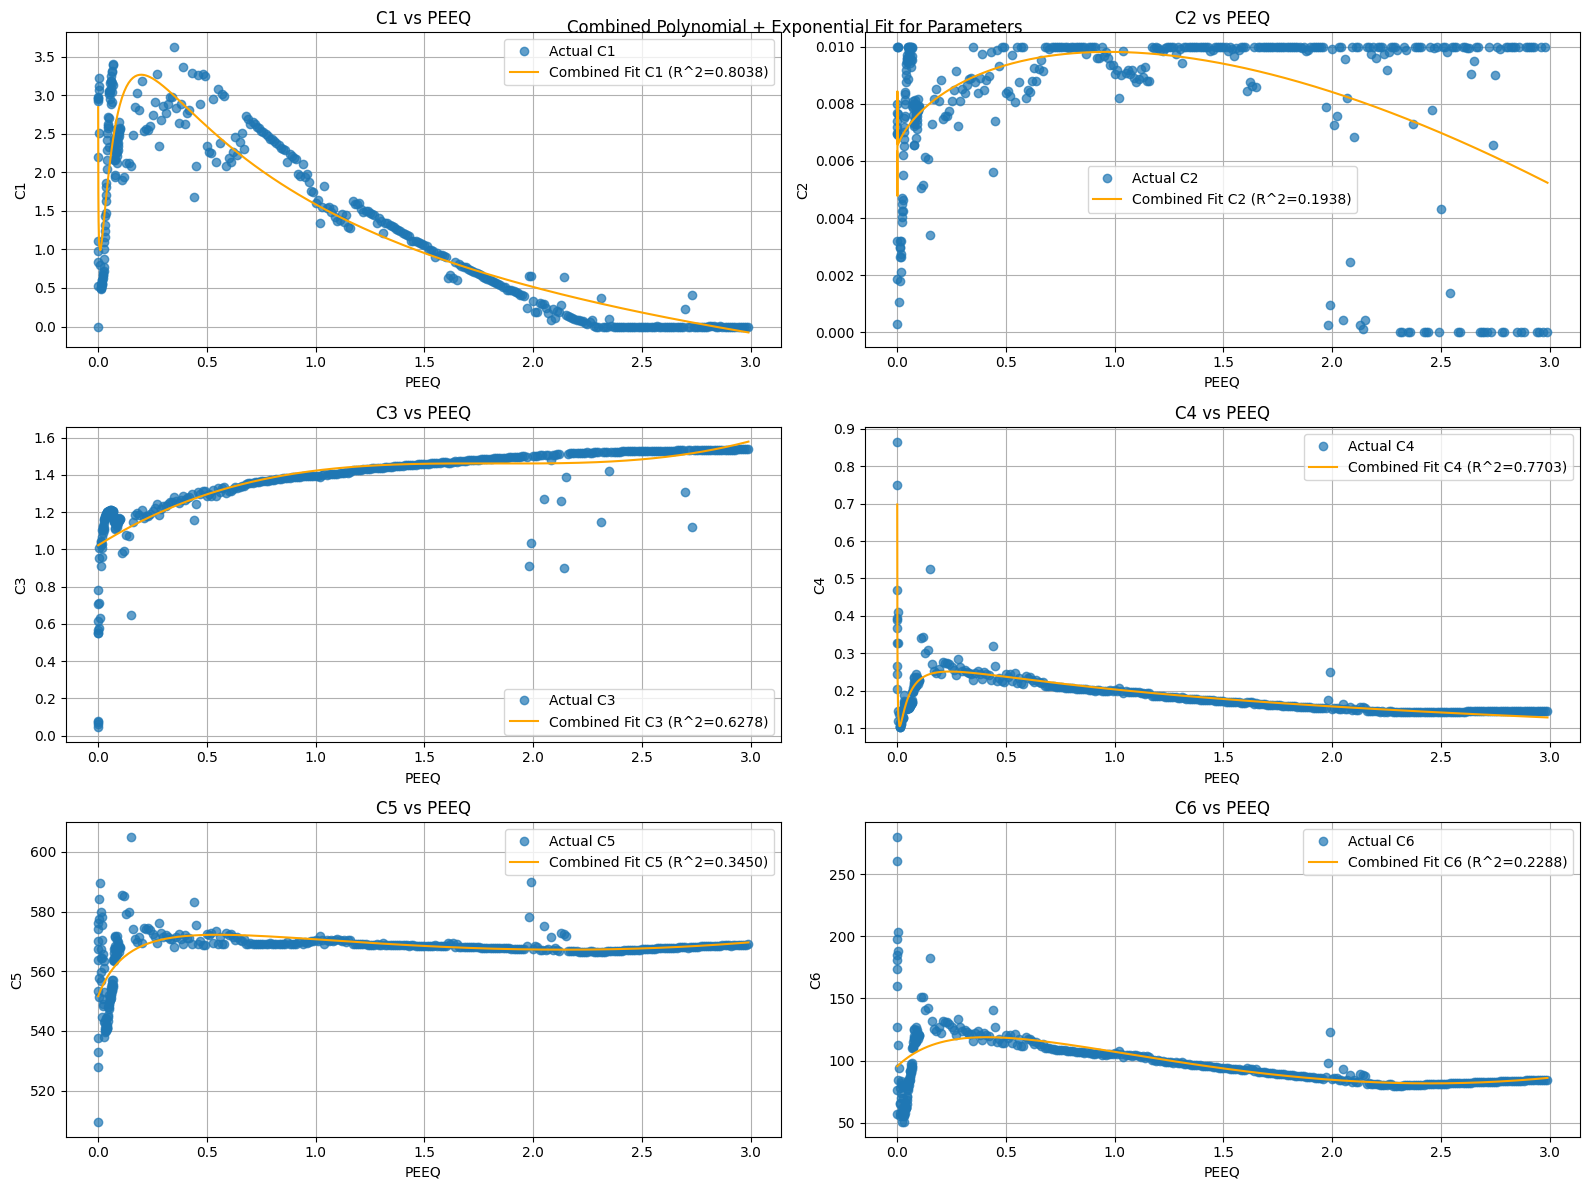

In [64]:
df_para_fit = pd.DataFrame(PEEQ, columns=["PEEQ"])

# Define the combined polynomial + exponential function
def combined_fit(x, a, b, c, d, e, f, C):
    if C == 'C4' or C == 'C2' or C == 'C1':
        return (a*x)/(x**b + c) + d + e * (x**f)
    elif C == 'C5' or C == 'C6': 
        #return a * (x**2) + b * x + c + d * np.exp(-e * x)
        return (a * (x**2) + b * x + c)/(d*x + 1) + e * np.exp(-f * x)
    else :
        return a * (x**3) + b * (x**2) + c * x + d + e * np.exp(-f * x)

# Function to fit the combined model and calculate R^2 score
def fit_combined_model(data, parameter):
    x = data['PEEQ']
    y = data[parameter]
    
    # Apply initial guesses and bounds only for 'C5' and 'C6'
    if parameter in ['C2']:
        initial_guess = [0.03, 0.1, -0.5, 0.01, -0.05, 1]
        bounds = ([0,0,-10,0,-1,0], [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf])
        fit_kwargs = {'p0': initial_guess, 'bounds': bounds}
    else:
        fit_kwargs = {}  # No initial guess or bounds for other parameters

    # Fit the combined model
    try:
        popt, _ = curve_fit(lambda x, a, b, c, d, e, f: combined_fit(x, a, b, c, d, e, f, parameter), x, y, maxfev=500000, **fit_kwargs)
        y_pred = combined_fit(x, *popt, parameter)
        r2 = r2_score(y, y_pred)
    except RuntimeError:
        popt = None
        y_pred = None
        r2 = -np.inf  # Indicate failed fit
    
    if popt is not None:
        print(f'Parameter: {parameter}, R^2: {r2:.4f}, Coefficients: {popt}')
    else:
        print(f'Parameter: {parameter} - Fit failed')
    
    return popt, y_pred, r2

# List of parameters to fit
parameters = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']

# Fit models and plot results
plt.figure(figsize=(16, 12))

for i, param in enumerate(parameters):
    popt, y_pred, r2 = fit_combined_model(data, param)
    x = data['PEEQ']
    y_actual = data[param]
    df_para_fit[param] = y_pred
    
    plt.subplot(3, 2, i + 1)
    plt.plot(x, y_actual, 'o', label=f'Actual {param}', alpha=0.7)
    
    # Plot fitted combined model if successful
    if y_pred is not None:
        plt.plot(x, y_pred, '-', color='orange', label=f'Combined Fit {param} (R^2={r2:.4f})')
    
    plt.xlabel('PEEQ')
    plt.ylabel(param)
    plt.title(f'{param} vs PEEQ')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.suptitle('Combined Polynomial + Exponential Fit for Parameters')
plt.show()

In [50]:
df_para_fit.to_csv('para_fit_results_0.01.csv', index=False)
# Assuming the file is one level up from the current directory
file_path = "Fitted_FC_TmpDpn_RD_StrRt0.01_ref.csv"
stress_data = pd.read_csv(file_path)

fitted_para = pd.read_csv('para_fit_results_0.01.csv')

Validation (better fit from 140th row)

[0.35395648 0.71718437 0.73340246 0.84894449 0.44089025]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


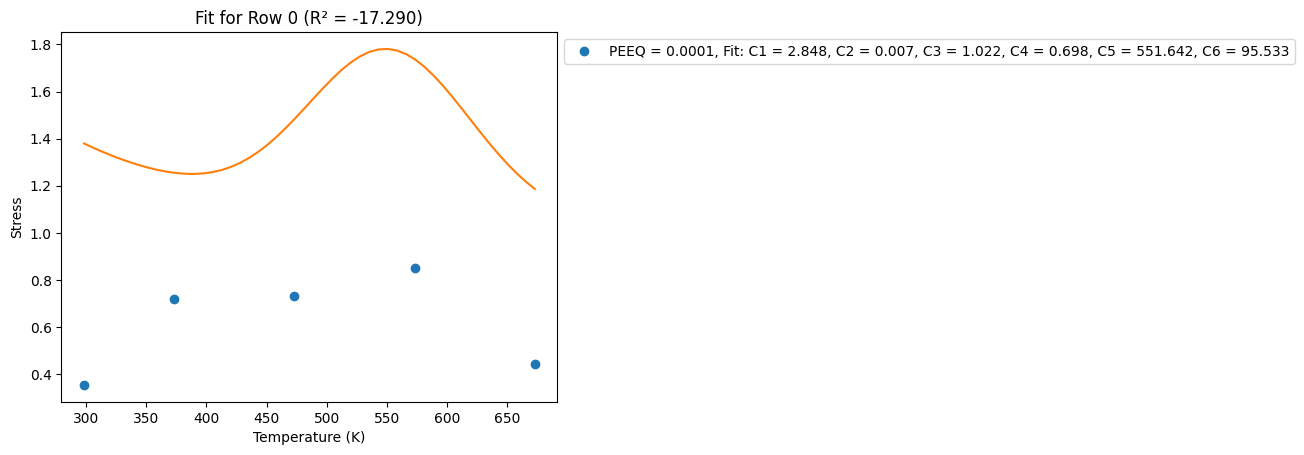

[0.63840811 0.80999341 0.85334548 0.91657997 0.68249243]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


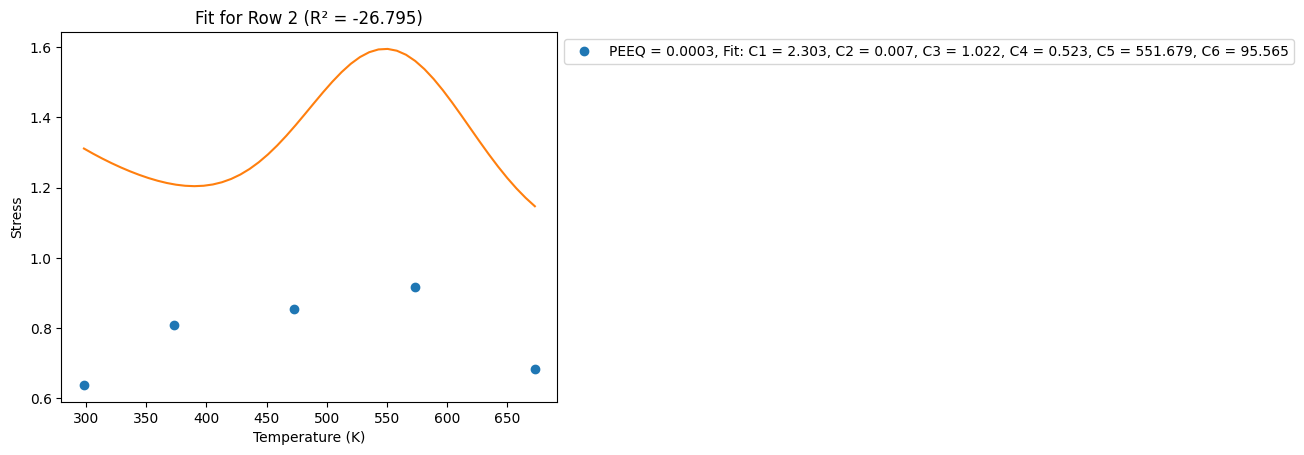

[0.84175786 0.83320907 0.8953506  0.9482615  0.76669728]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


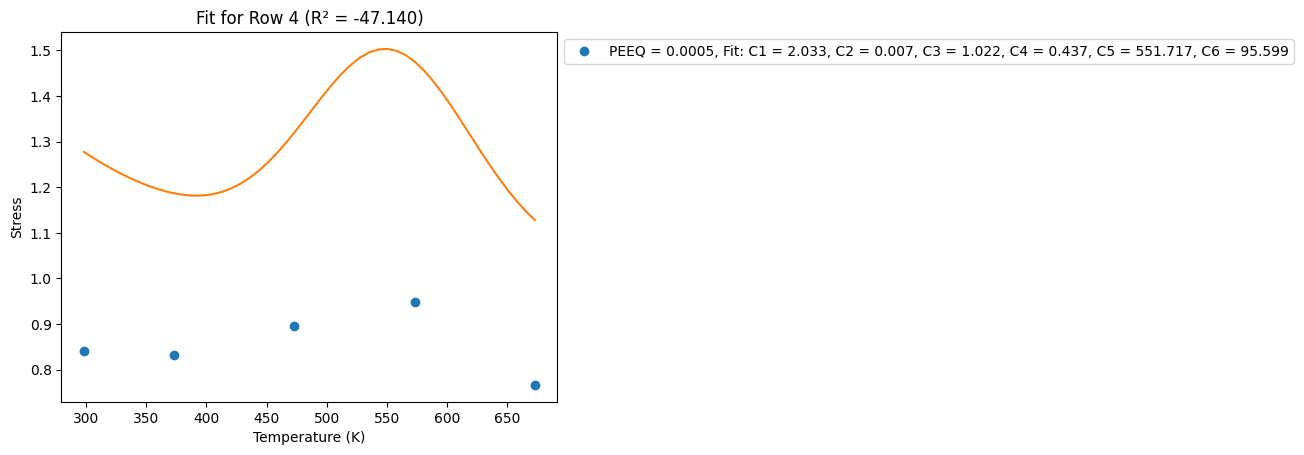

[0.91525036 0.8520262  0.92176414 0.96825508 0.81812719]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


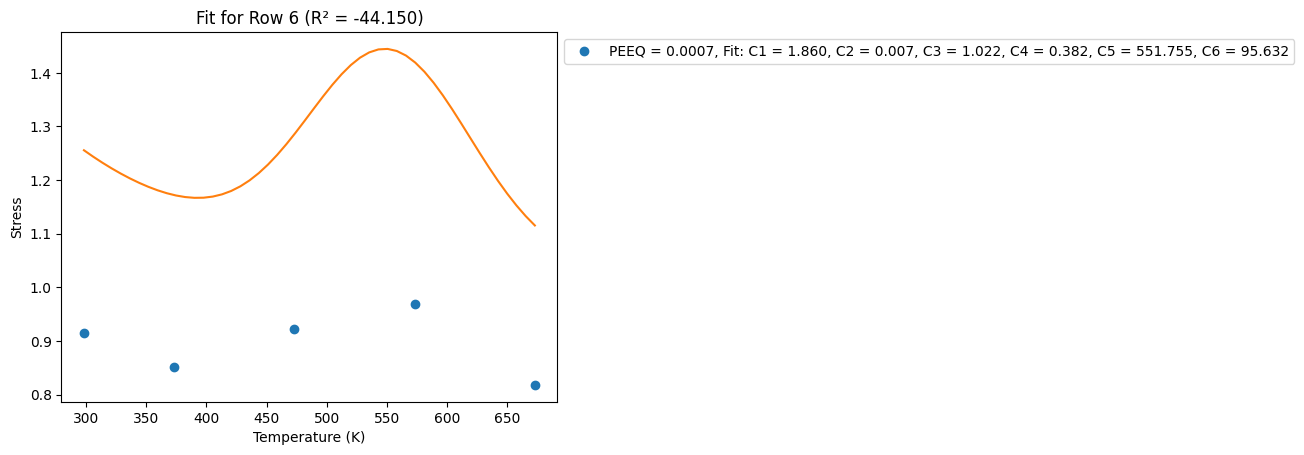

[0.94906928 0.86864539 0.94121956 0.9831531  0.85330767]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


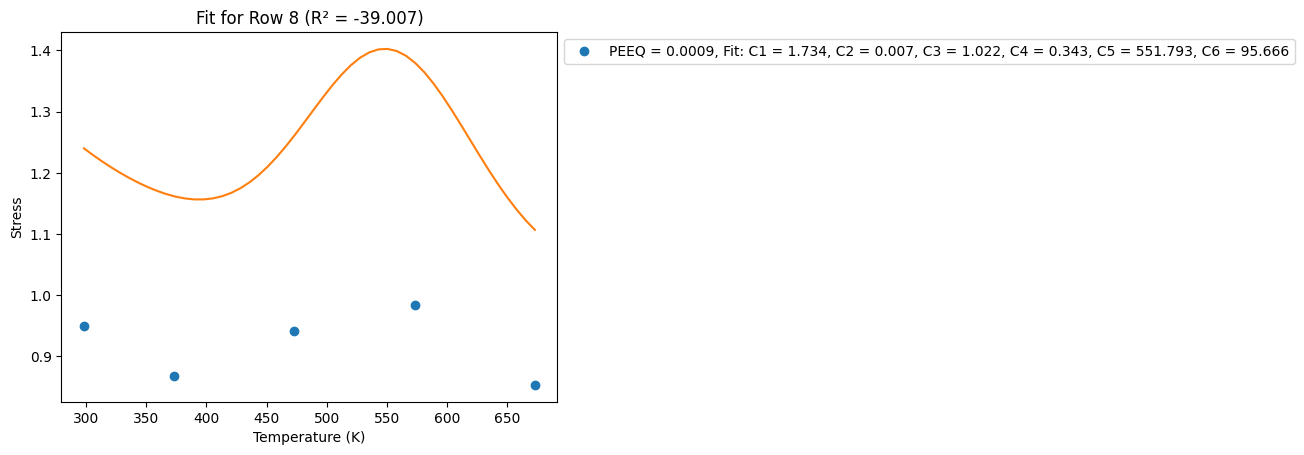

[0.97001281 0.88382475 0.95671045 0.99545736 0.87895781]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


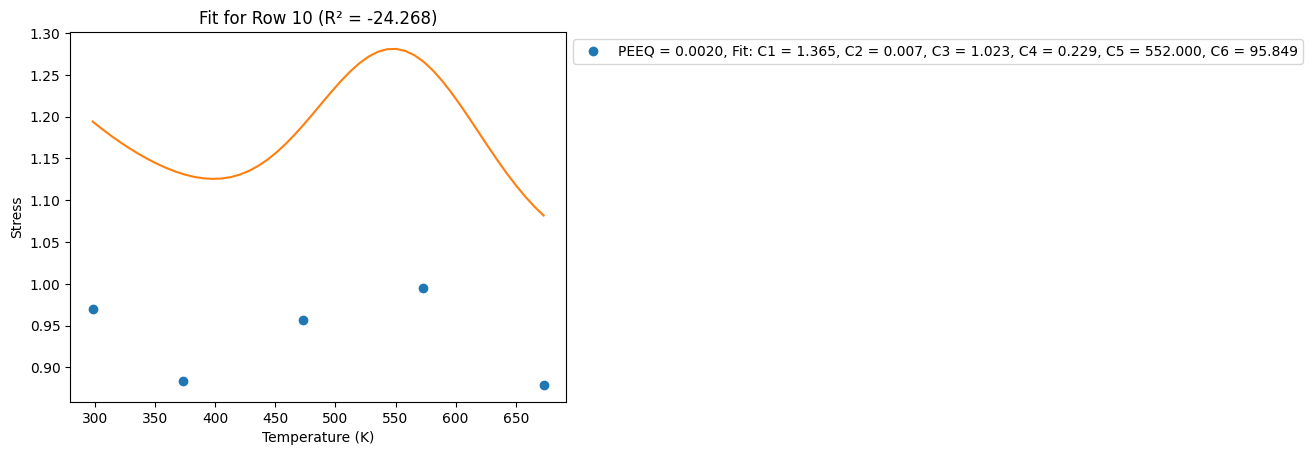

[1.07769468 0.9962407  1.03882649 1.07754977 0.98268043]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


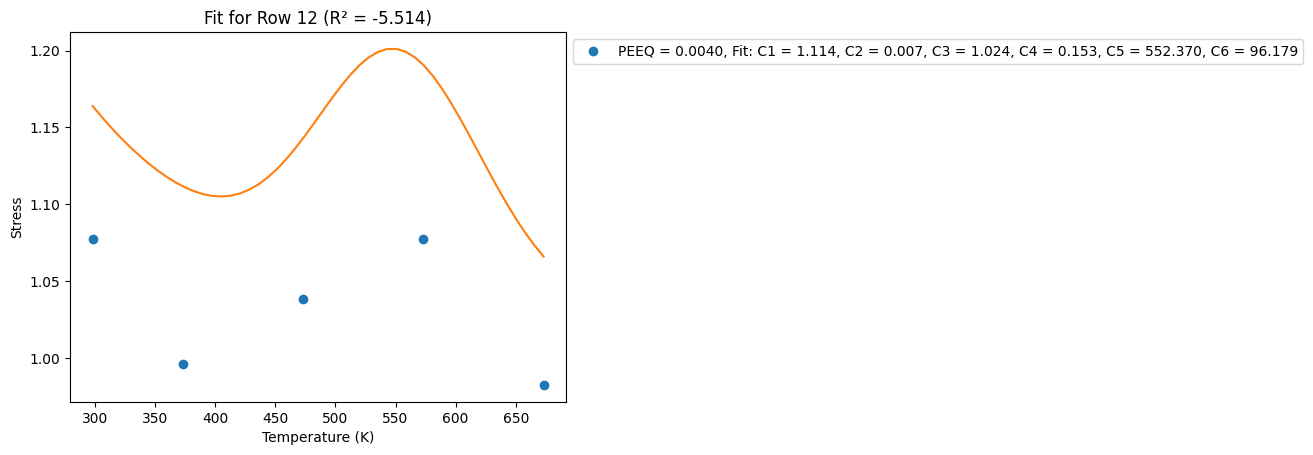

[1.13550081 1.06965551 1.0813155  1.12823447 1.02590483]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


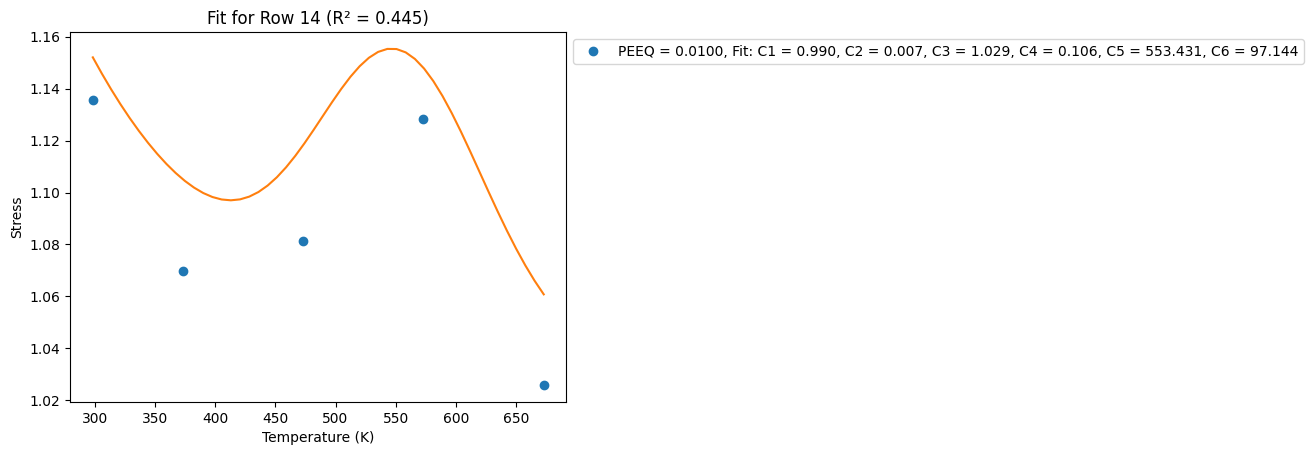

[1.22352627 1.18178115 1.1536442  1.20853756 1.09265547]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


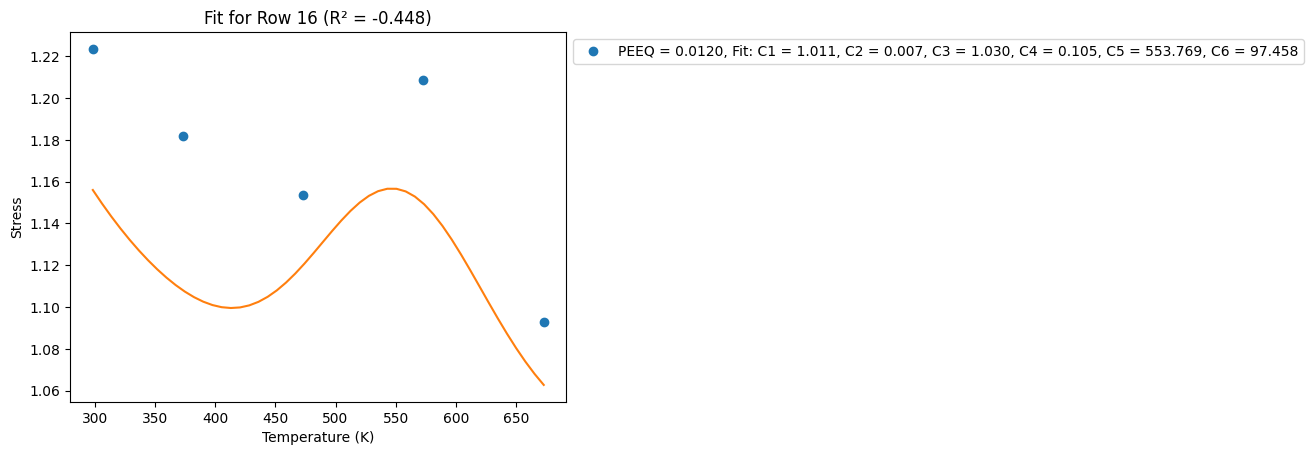

[1.24108421 1.20049175 1.16986524 1.22523046 1.10681631]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


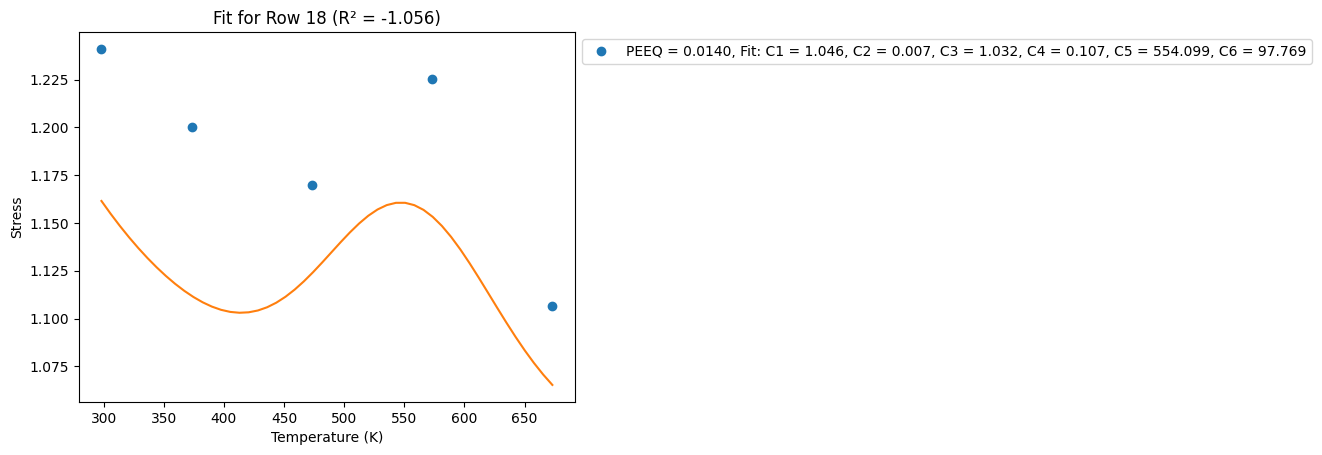

[1.25569601 1.21439984 1.18388844 1.23941293 1.11895021]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


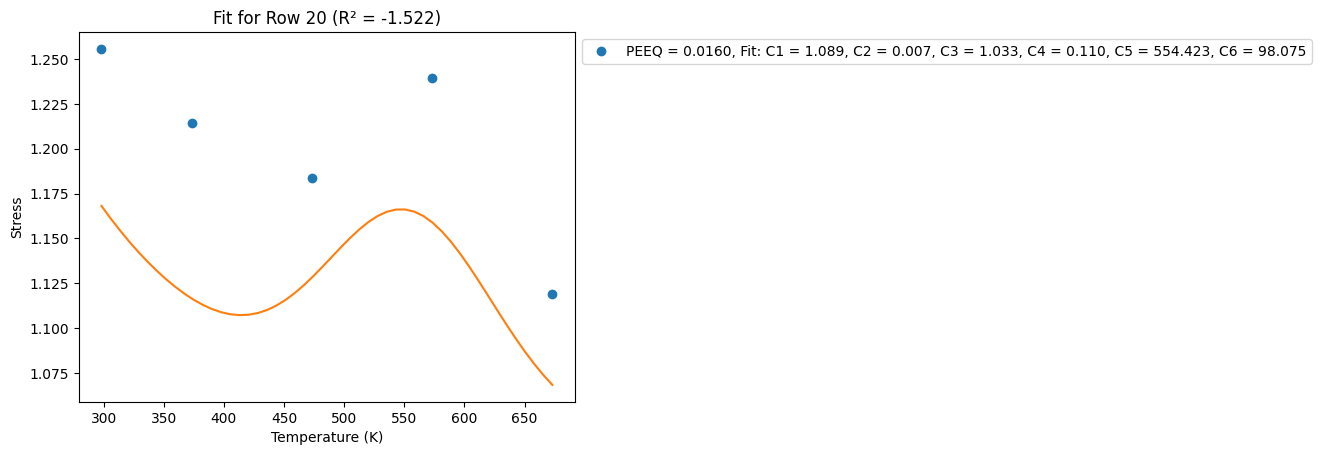

[1.26812889 1.22496115 1.19618799 1.25172634 1.12956545]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


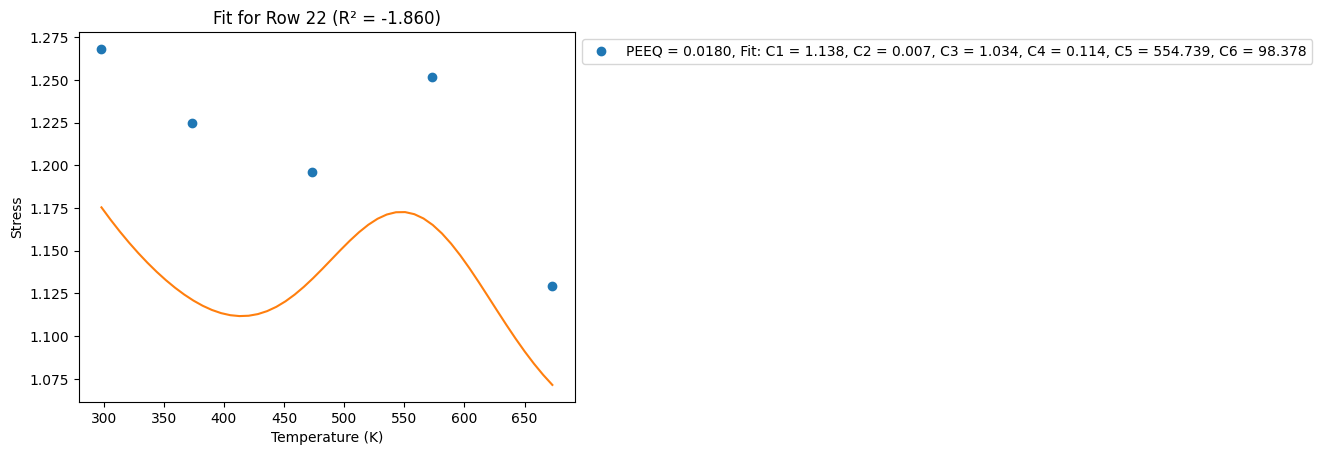

[1.2788934  1.23317314 1.20709433 1.26259555 1.13900025]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


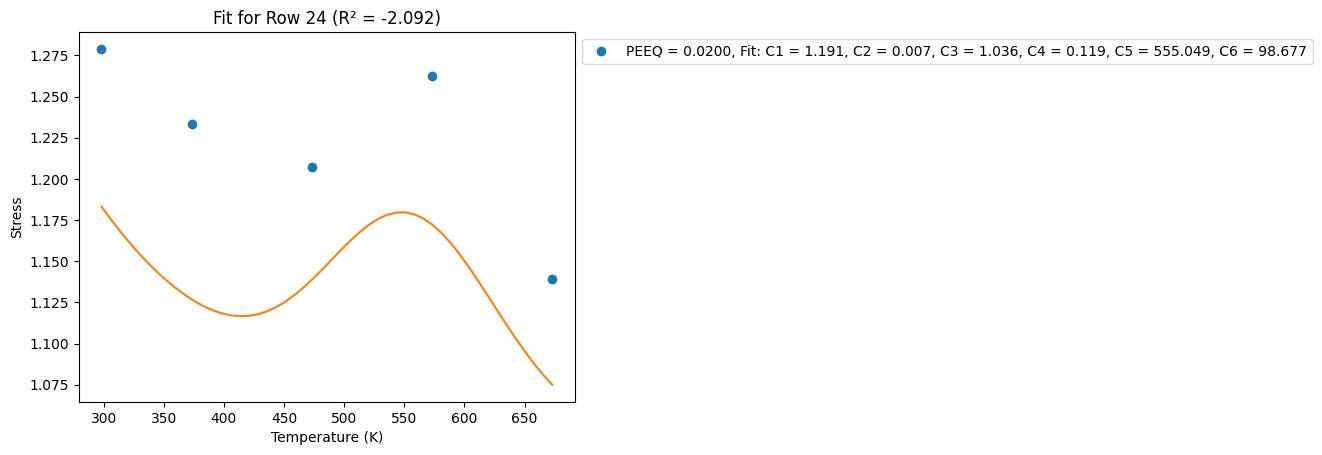

[1.28834482 1.23972258 1.21684953 1.27231623 1.14749108]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


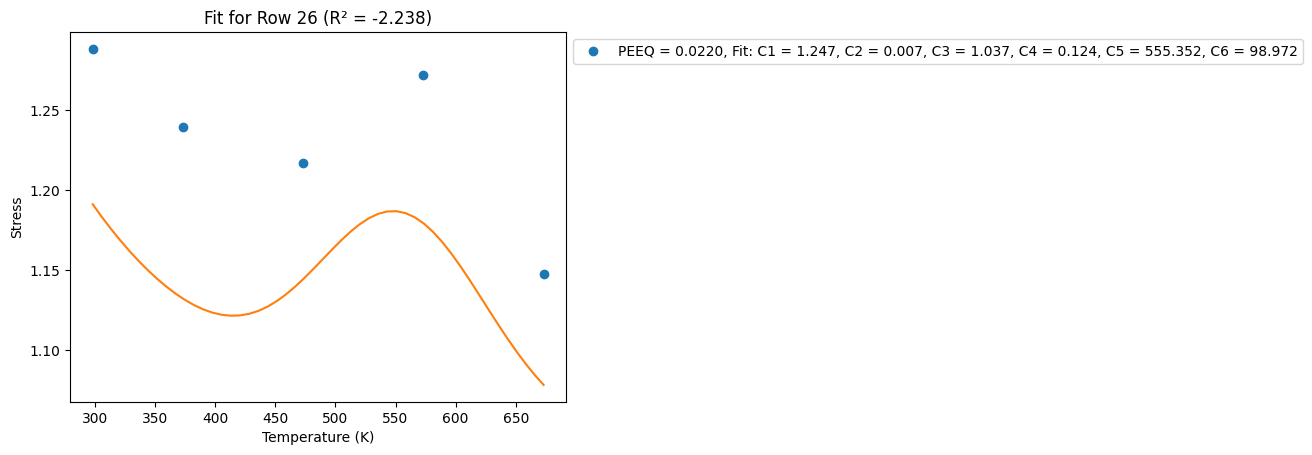

[1.29673945 1.24508428 1.22563778 1.28110231 1.15520978]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


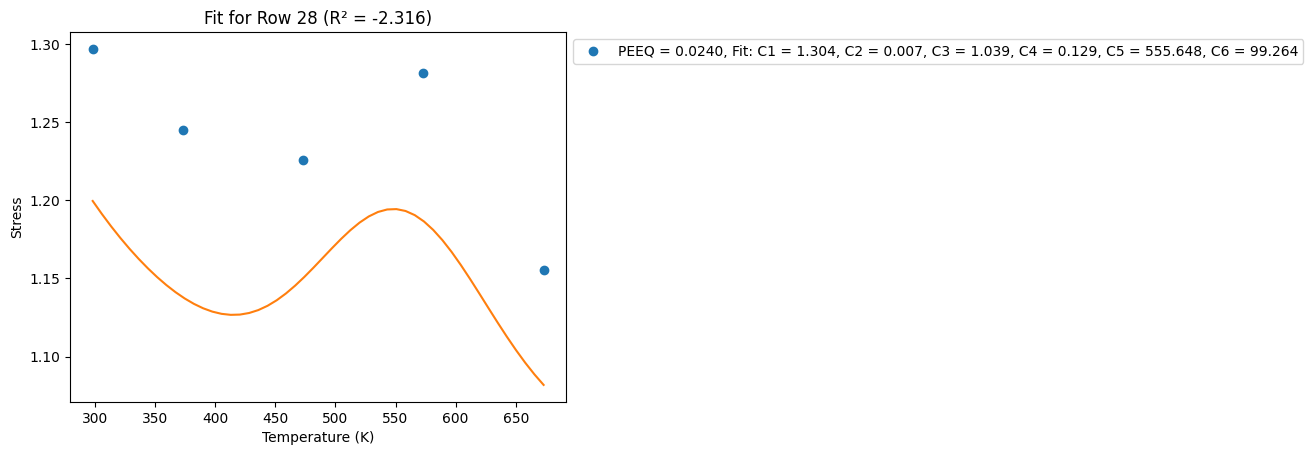

[1.30426768 1.24958794 1.23360336 1.28911346 1.16228516]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


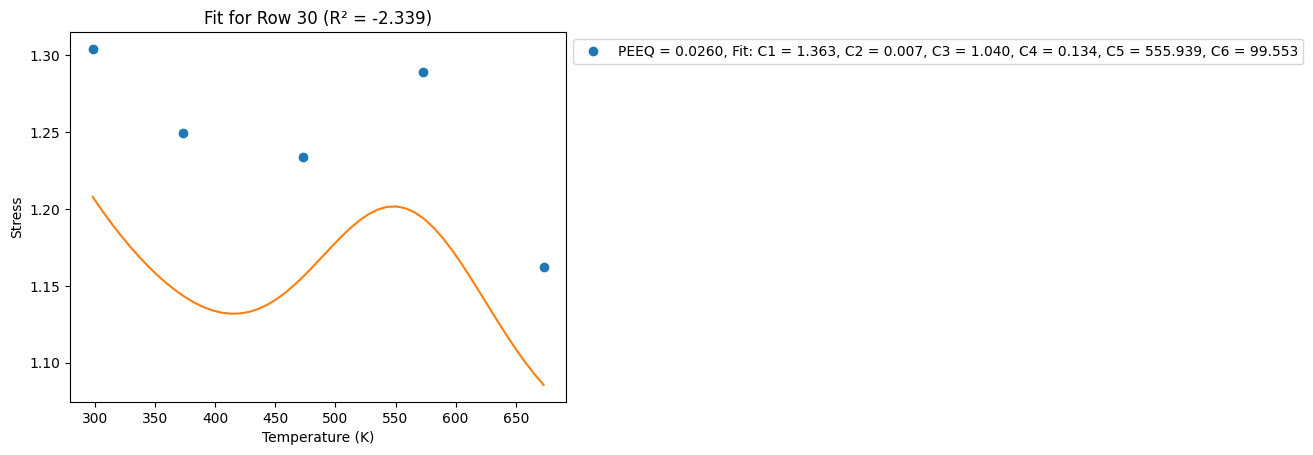

[1.31107442 1.25346354 1.24086185 1.29647195 1.16881625]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


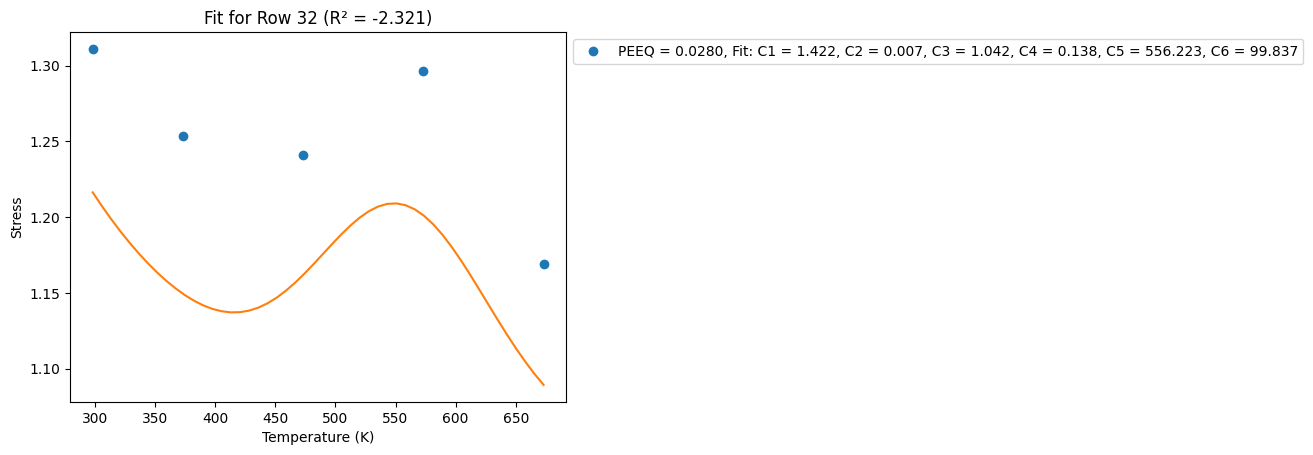

[1.31727231 1.25687232 1.24750759 1.30327346 1.17488085]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


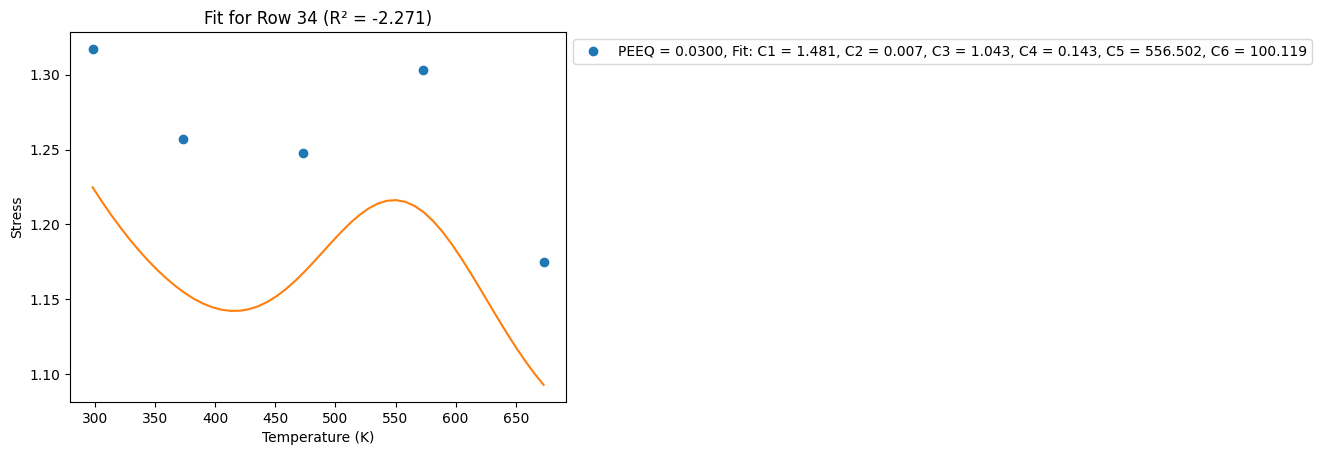

[1.32295047 1.25992804 1.25361863 1.30959421 1.18054118]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


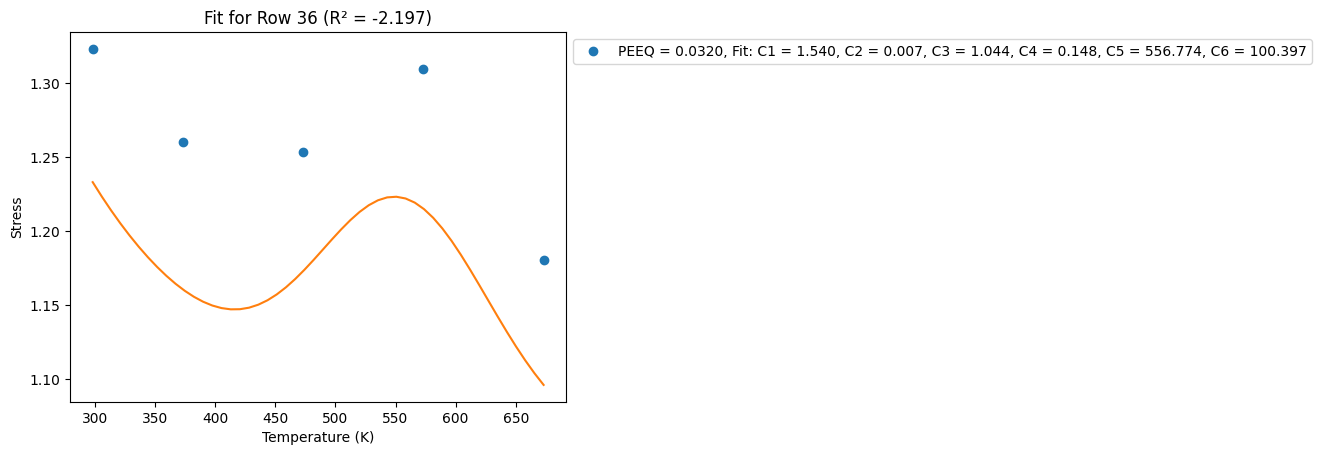

/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


[1.32818047 1.26271156 1.25926038 1.31549594 1.18584779]


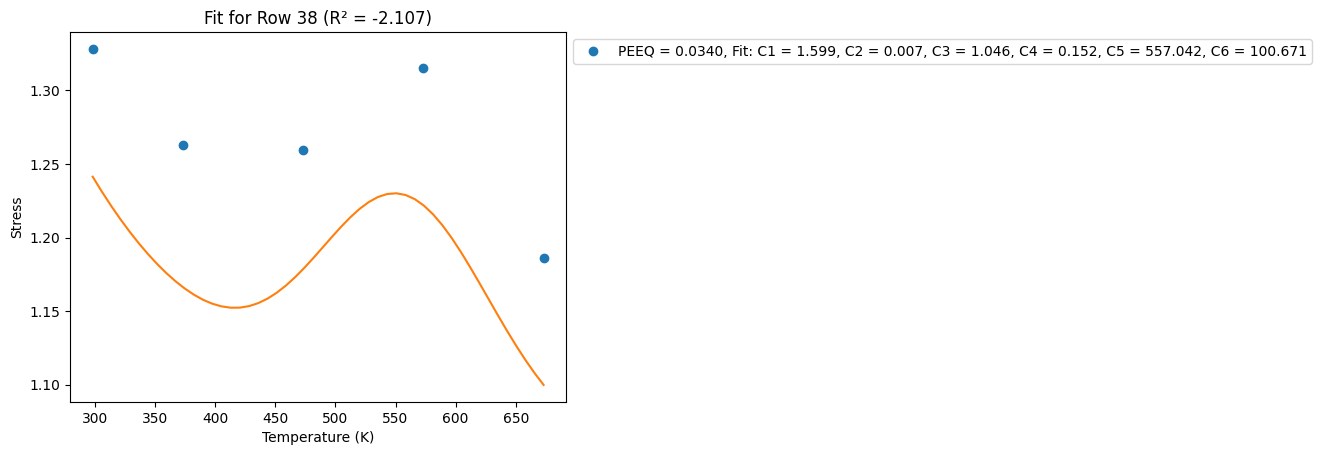

[1.33302062 1.26528083 1.26448812 1.32102928 1.1908423 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


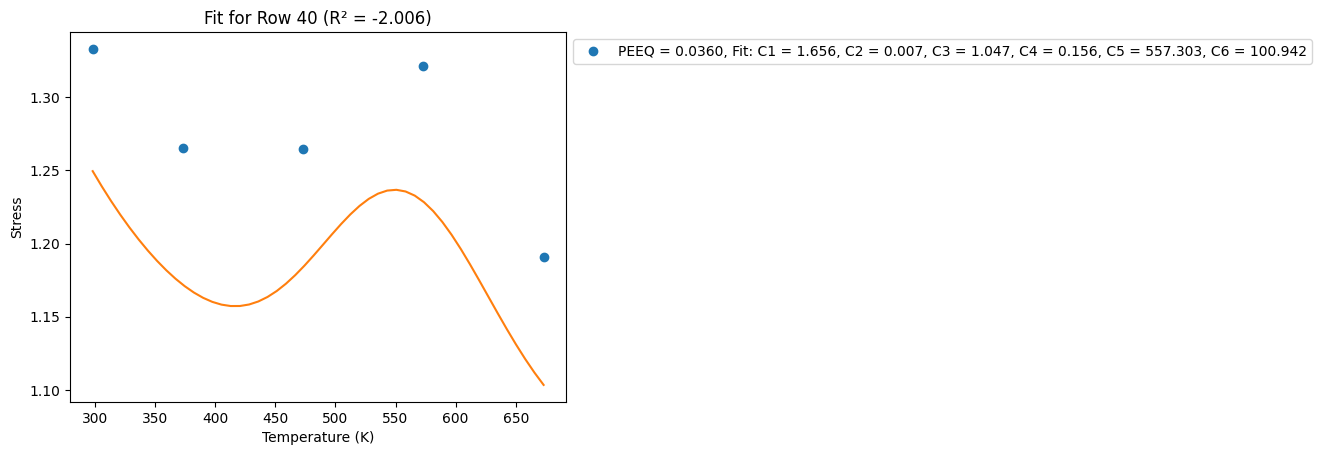

[1.33751896 1.26767785 1.26934902 1.3262363  1.1955594 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


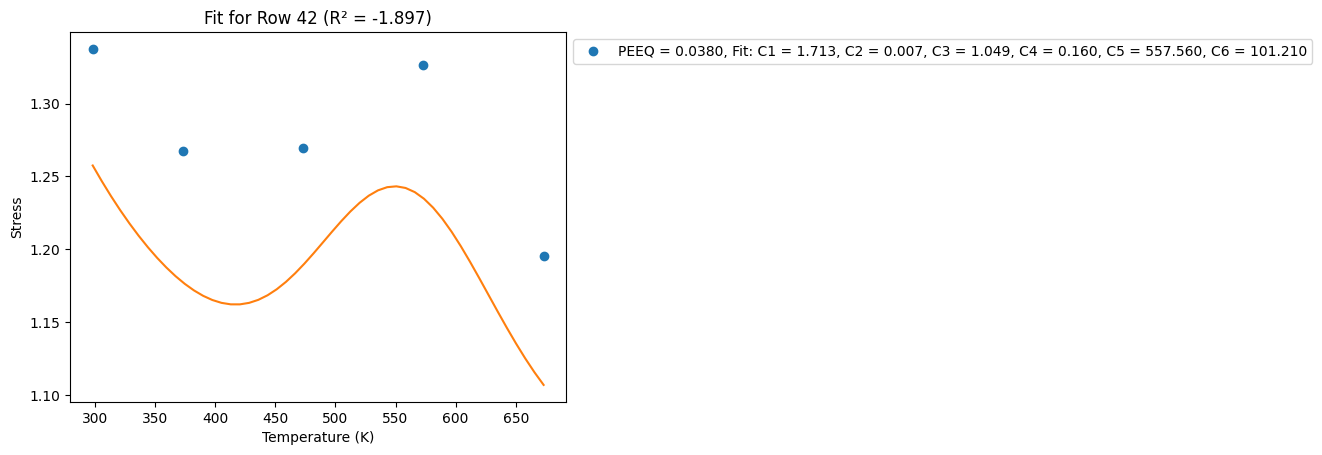

[1.34171551 1.26993338 1.27388355 1.33115231 1.20002829]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


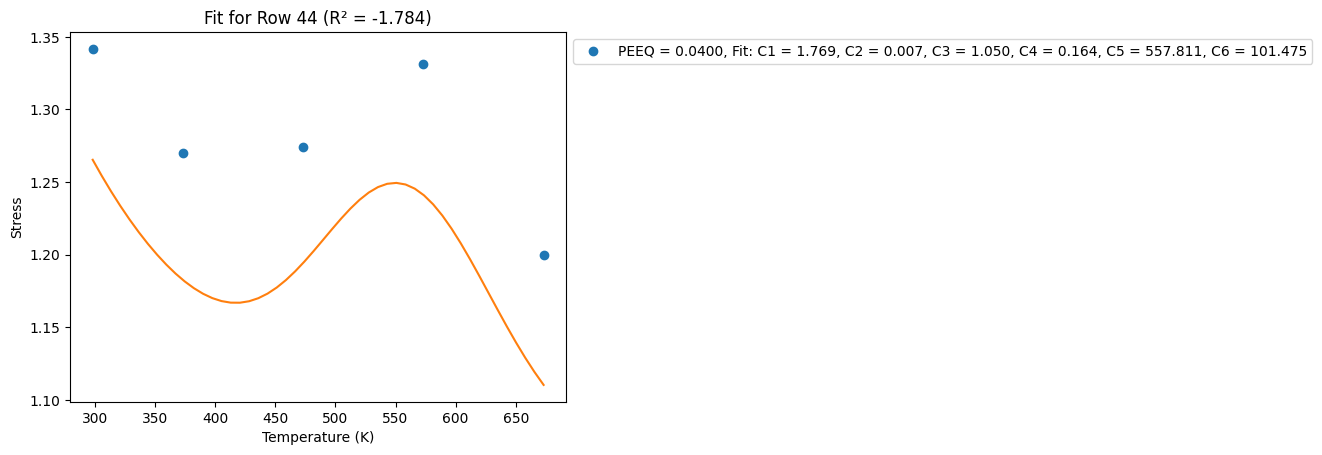

[1.34564391 1.2720703  1.27812665 1.33580723 1.20427379]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


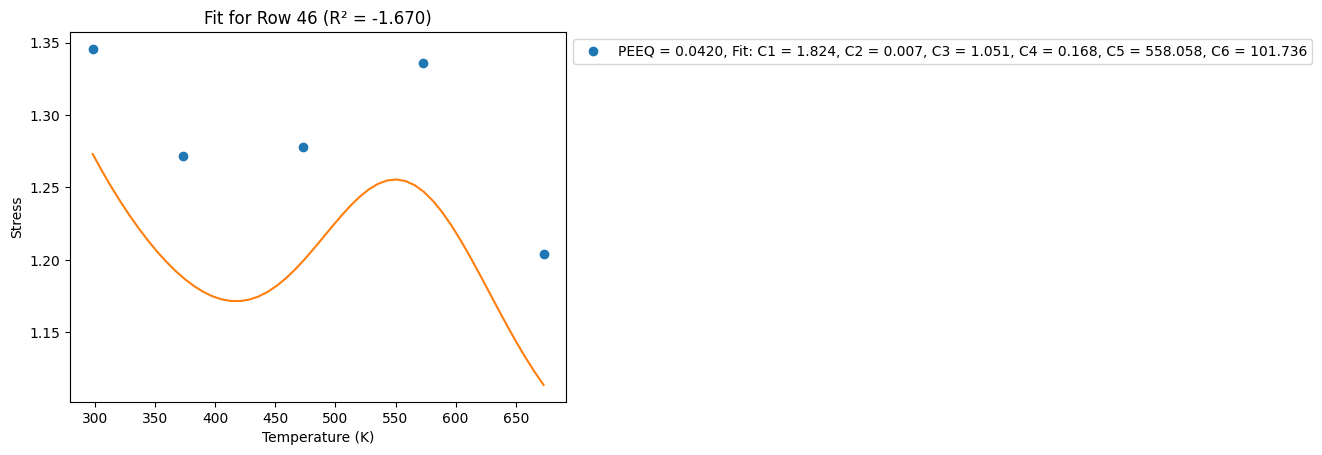

[1.34933272 1.27410588 1.28210865 1.34022665 1.20831717]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


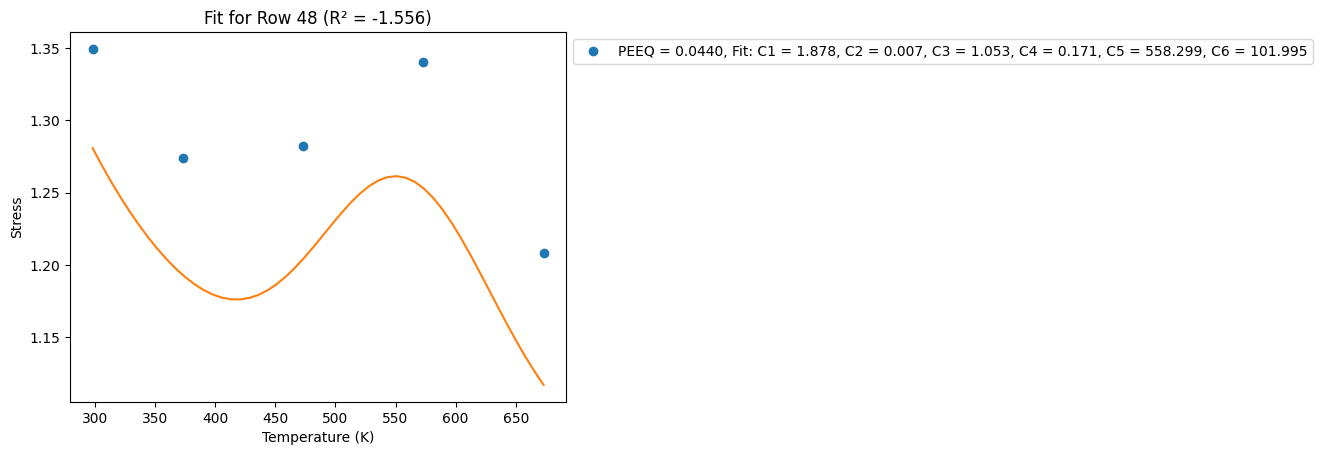

[1.35280632 1.27605336 1.28585599 1.34443258 1.21217682]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


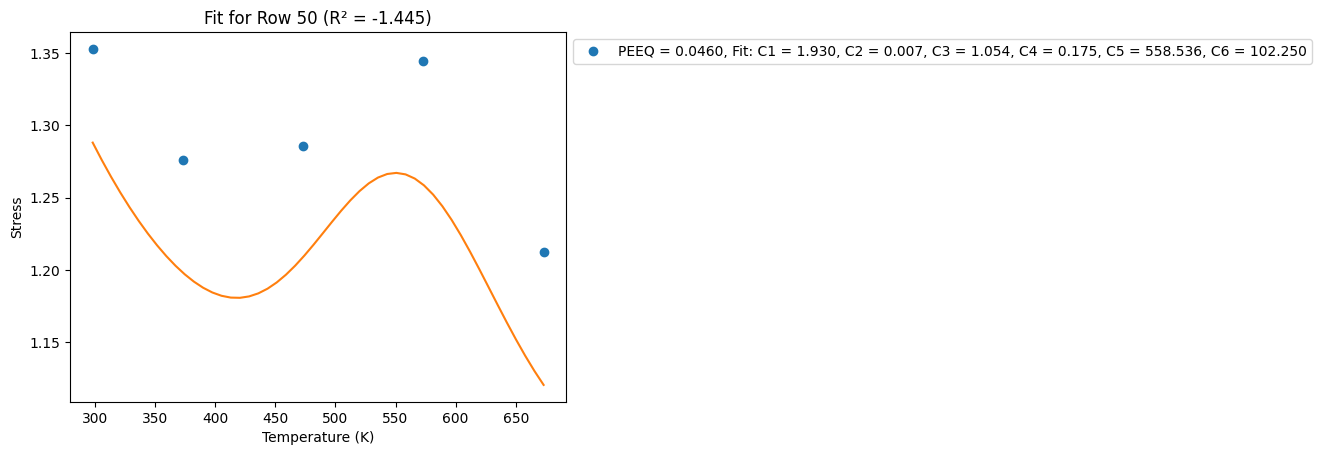

[1.35608571 1.27792312 1.2893918  1.34844413 1.2158687 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


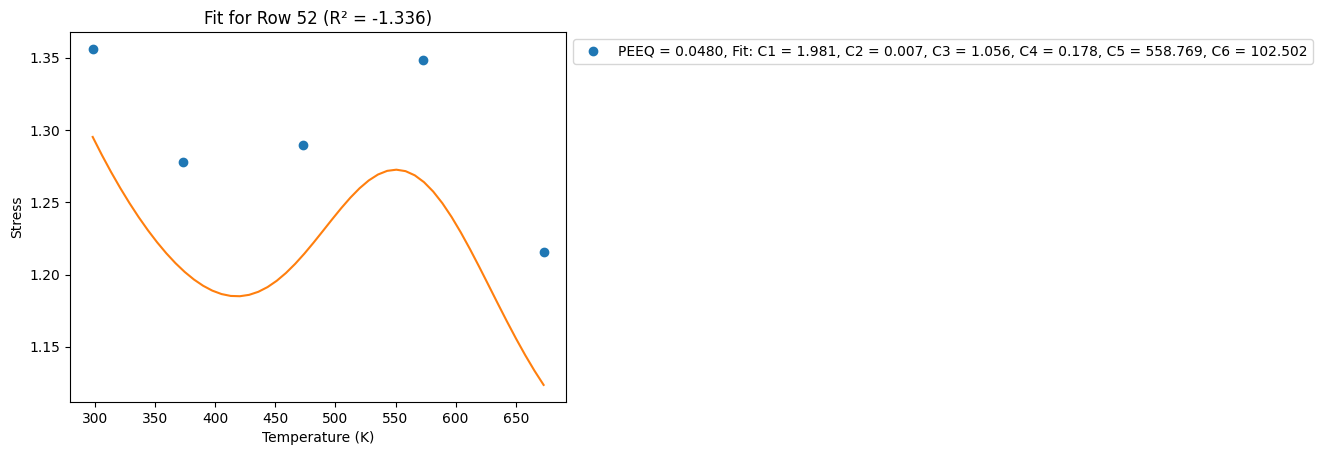

[1.35918907 1.27972339 1.29273639 1.35227796 1.21940679]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


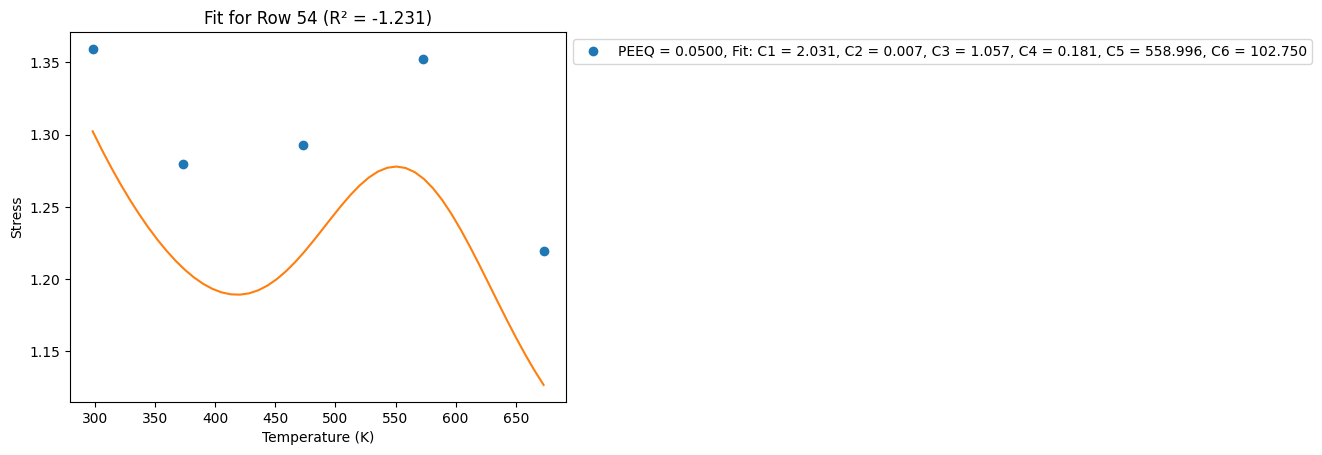

[1.36213227 1.28146086 1.29590764 1.35594872 1.22280341]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


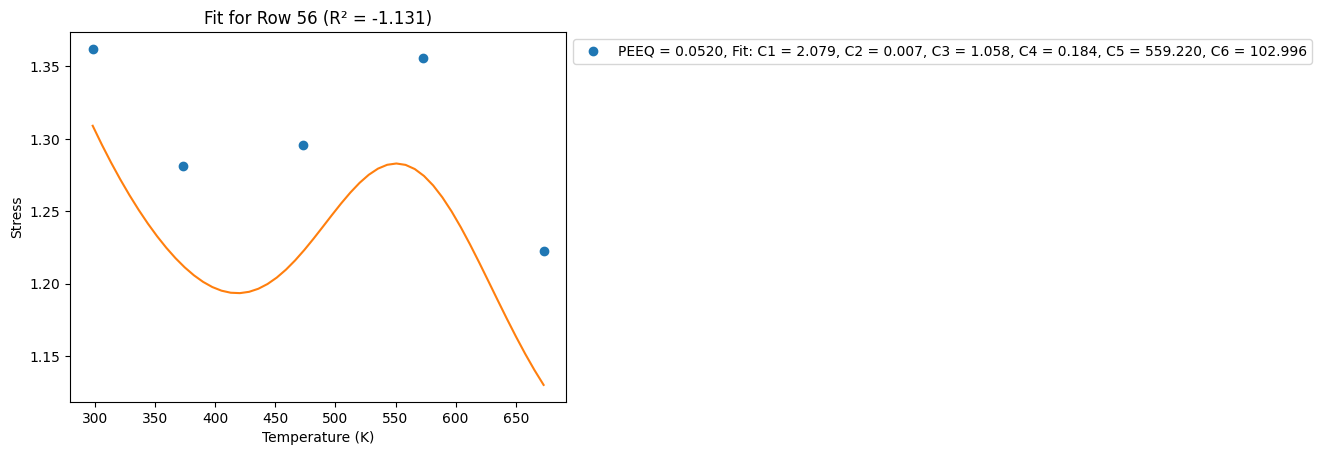

[1.36492918 1.28314107 1.29892136 1.35946932 1.22606942]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


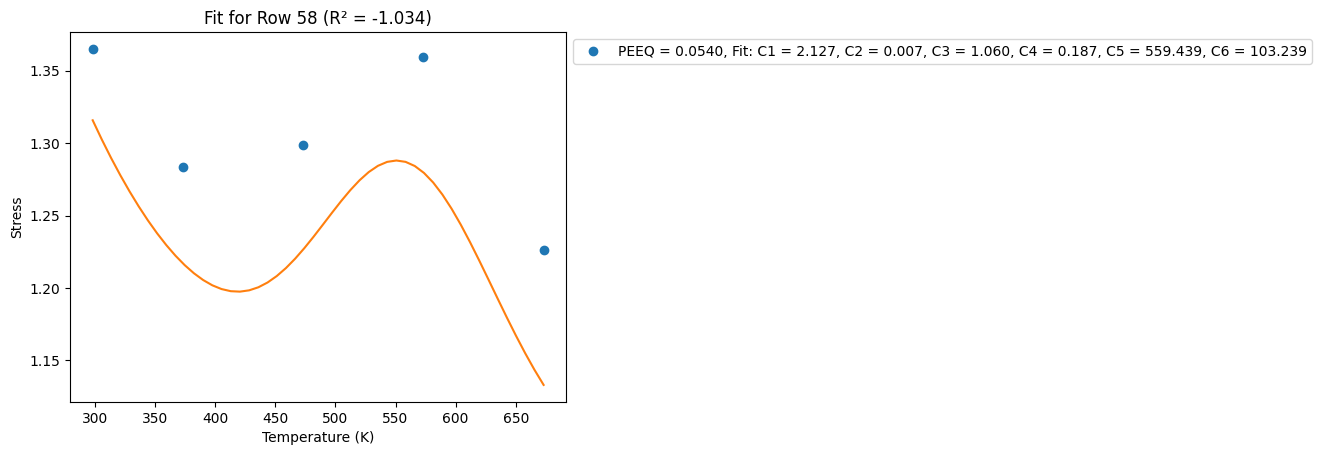

[1.36759205 1.28476865 1.30179154 1.36285121 1.2292145 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


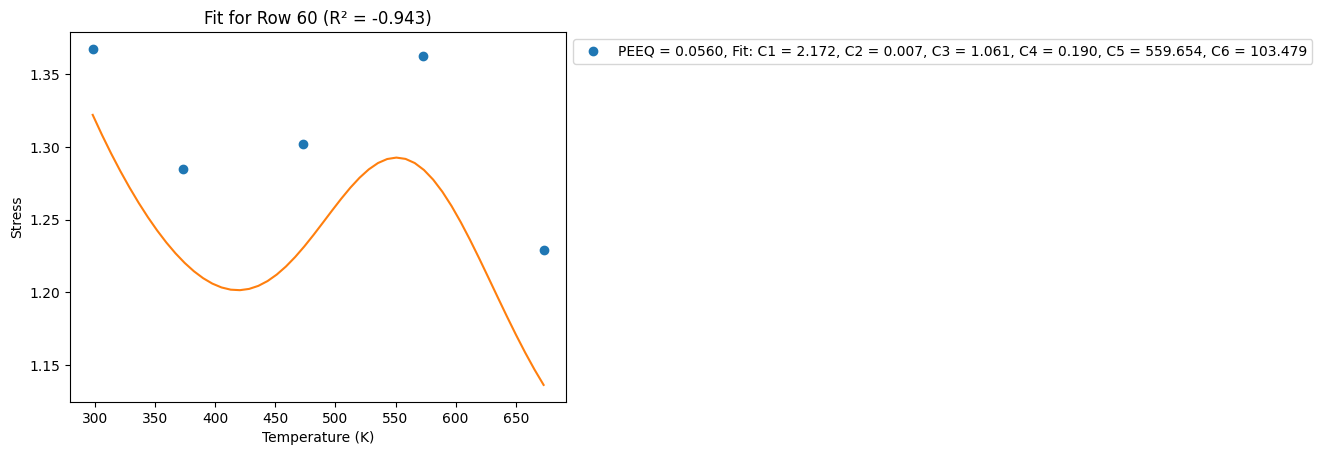

[1.3701317  1.28634757 1.30453061 1.3661046  1.2322473 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


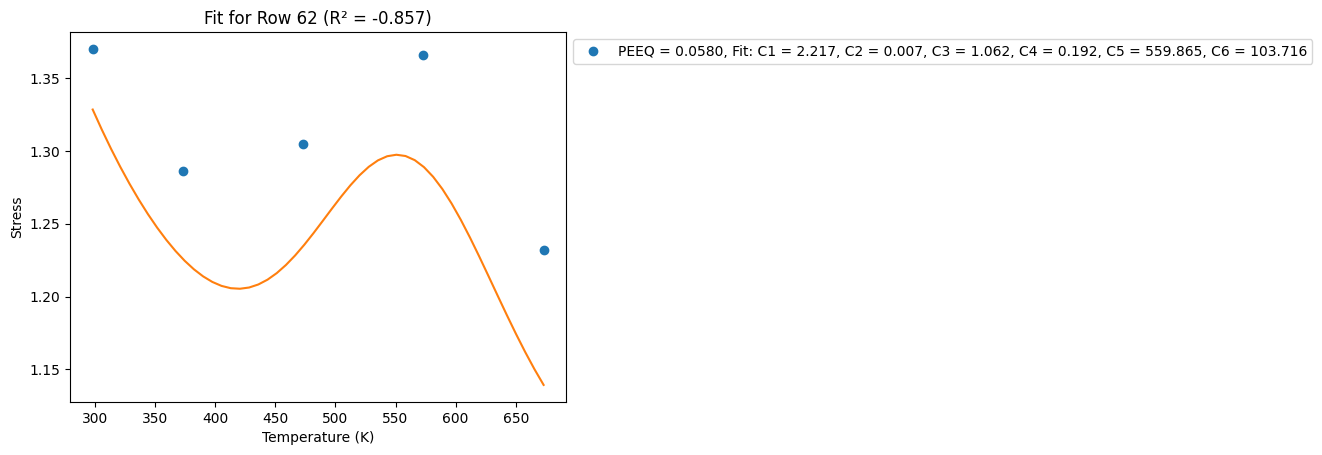

/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


[1.37255775 1.28788125 1.30714964 1.36923861 1.23517554]


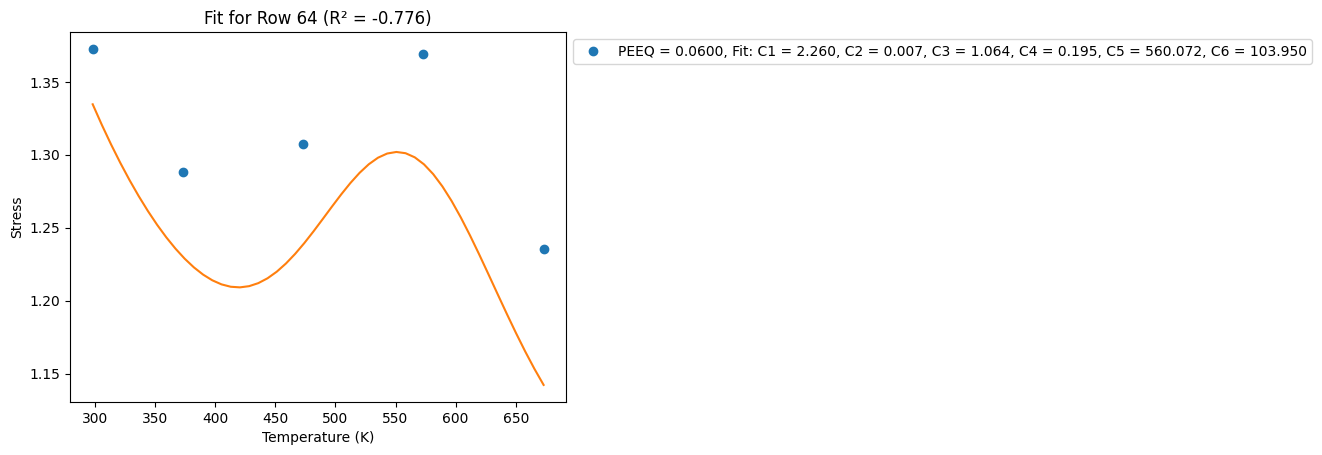

[1.37487877 1.28937269 1.30965849 1.37226144 1.23800621]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


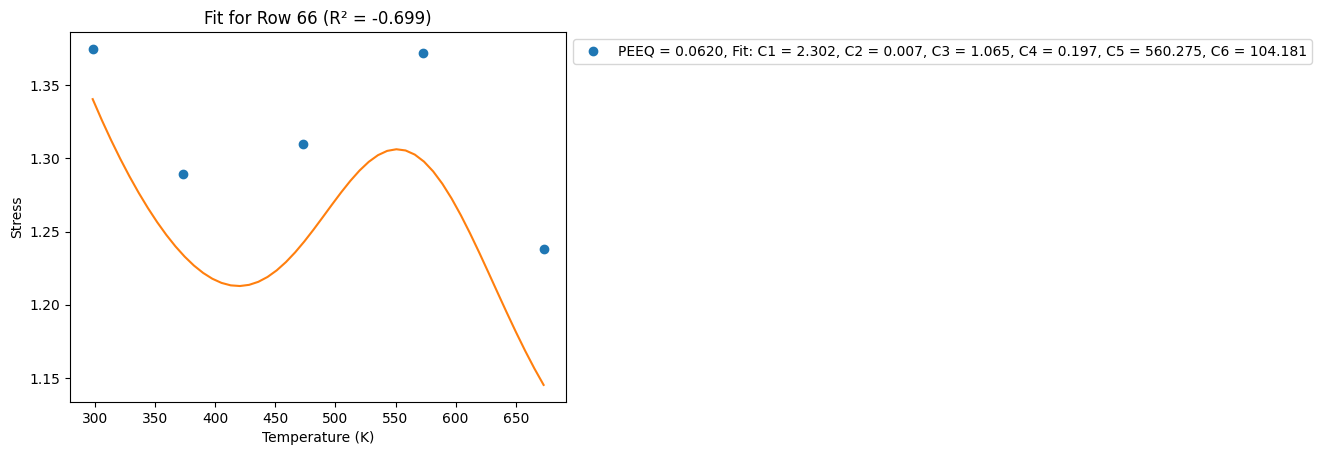

[1.37710245 1.29082455 1.31206597 1.37518049 1.24074559]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


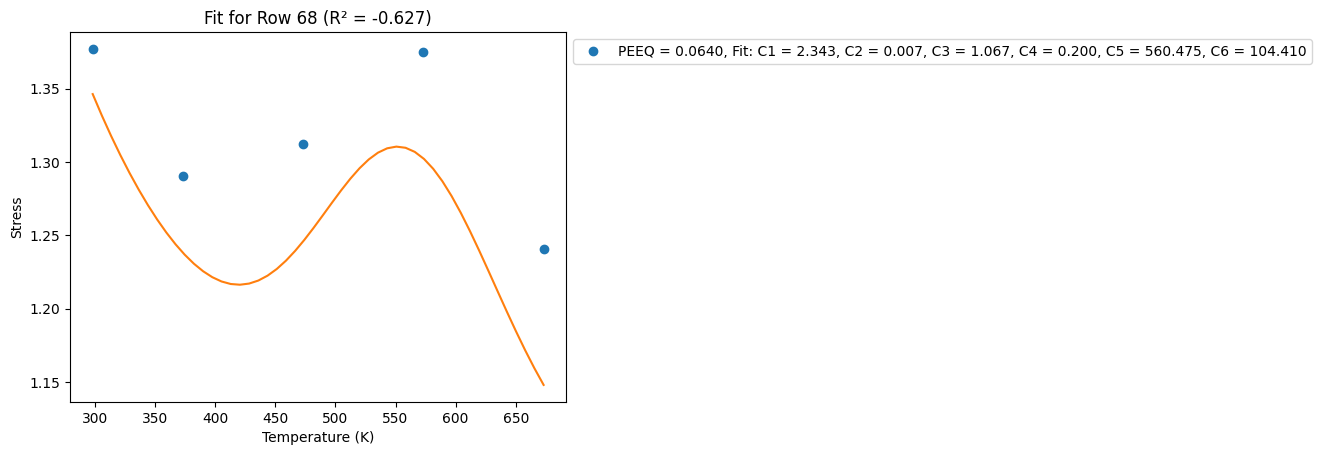

[1.37923571 1.2922392  1.31438001 1.37800243 1.24339939]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


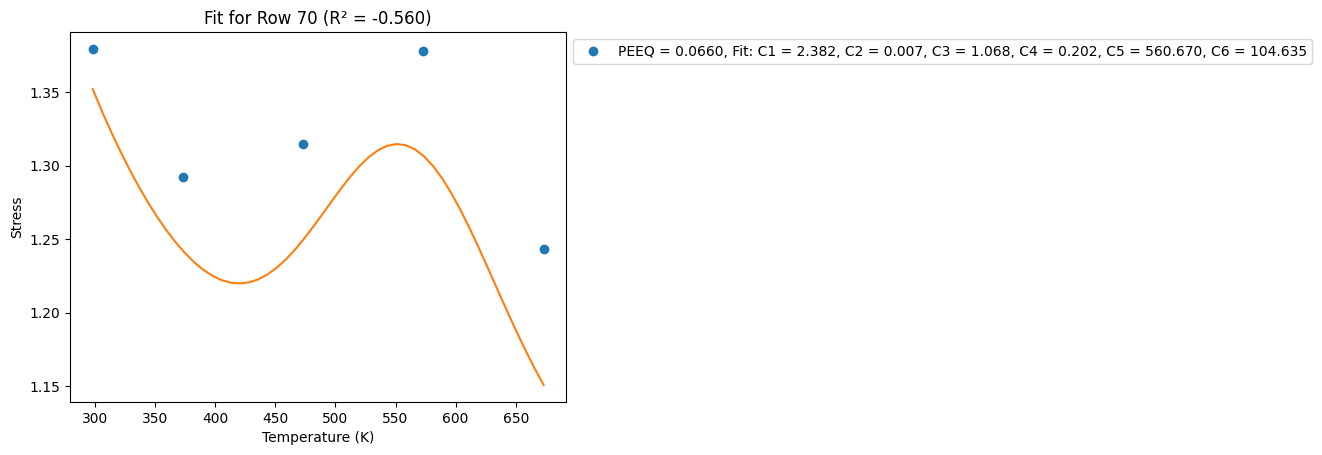

[1.38128476 1.29361877 1.31660767 1.38073333 1.2459728 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


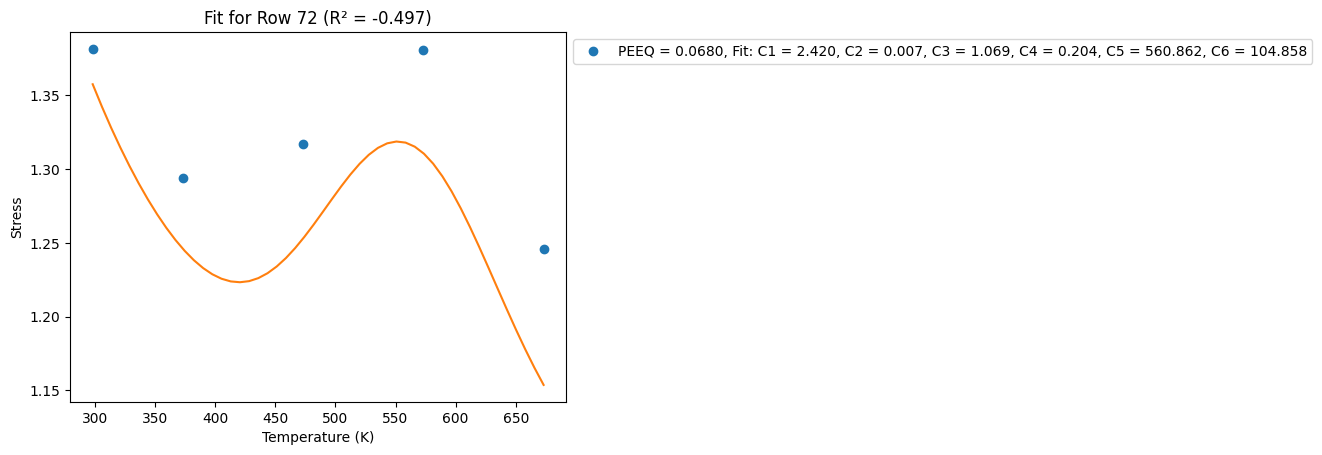

[1.38325525 1.2949652  1.31875536 1.38337871 1.24847054]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


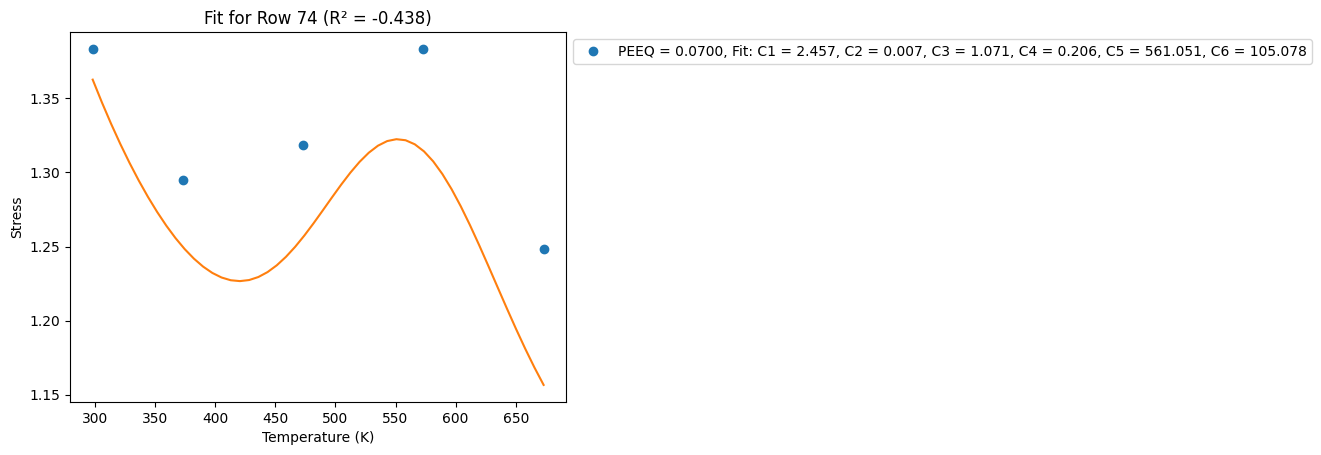

[1.38515227 1.29628024 1.3208288  1.3859436  1.25089694]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


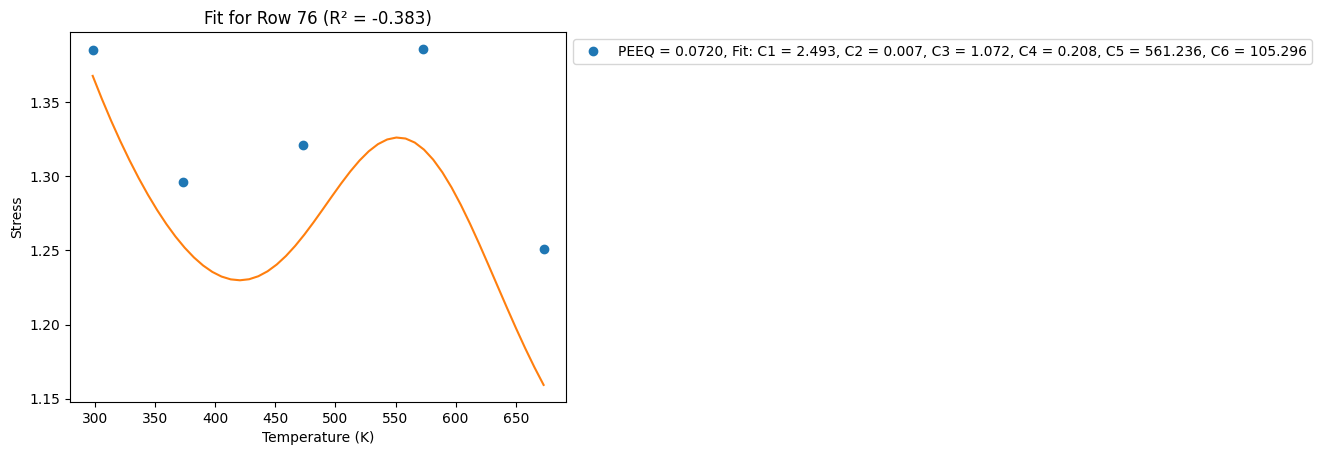

[1.38698049 1.29756551 1.3228332  1.38843263 1.25325595]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


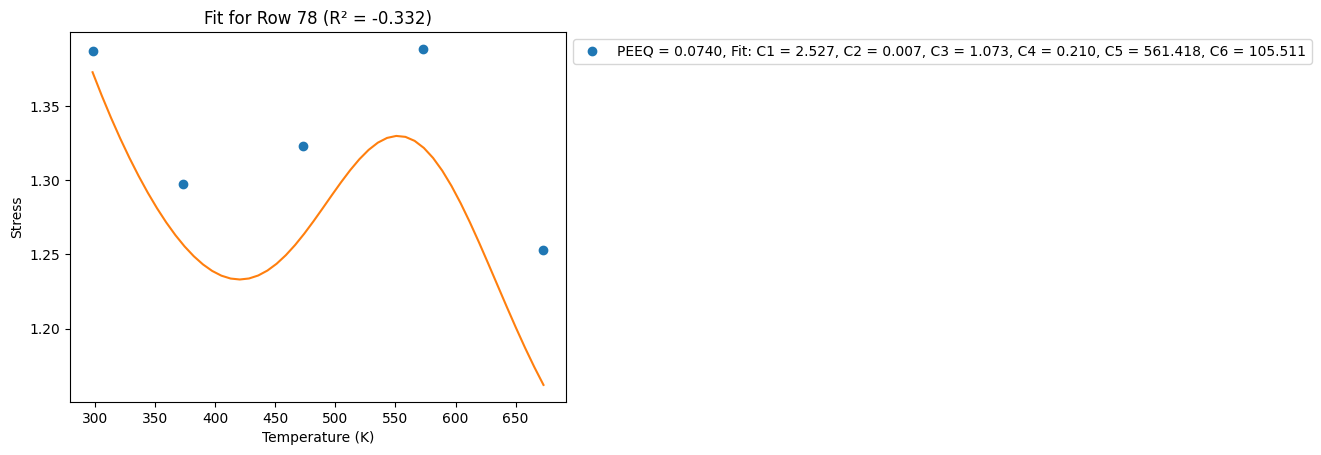

[1.38874414 1.29882249 1.32477324 1.39085    1.25555123]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


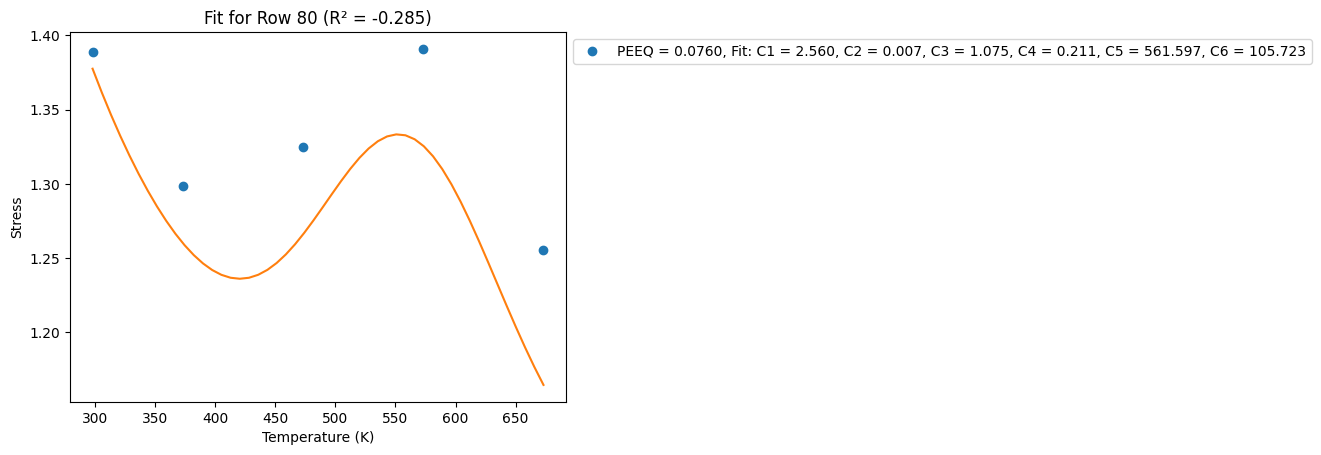

[1.3904471  1.30005255 1.32665319 1.39319962 1.25778613]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


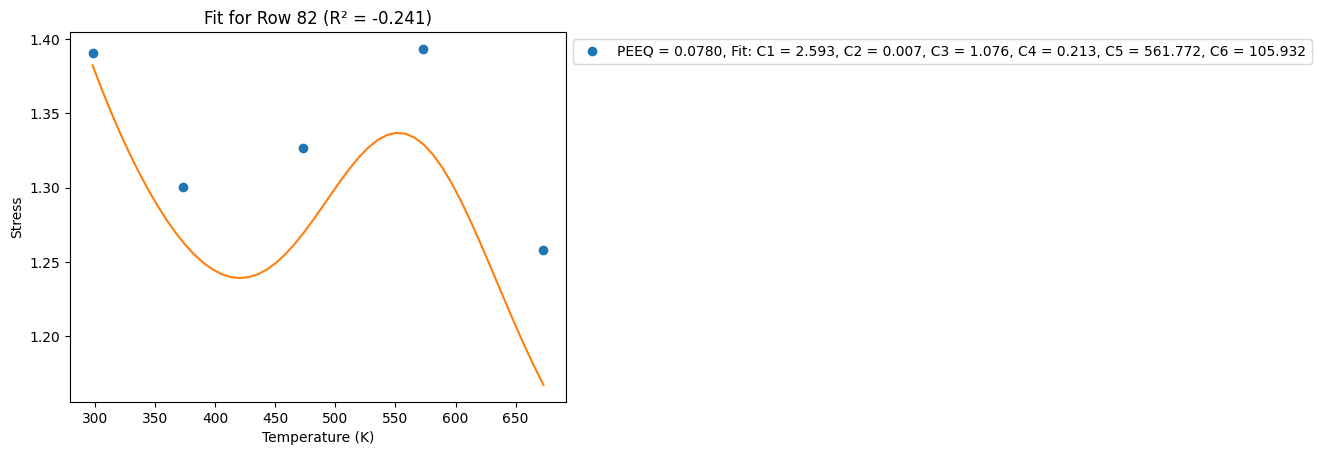

[1.39209292 1.30125694 1.3284769  1.39548506 1.25996373]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


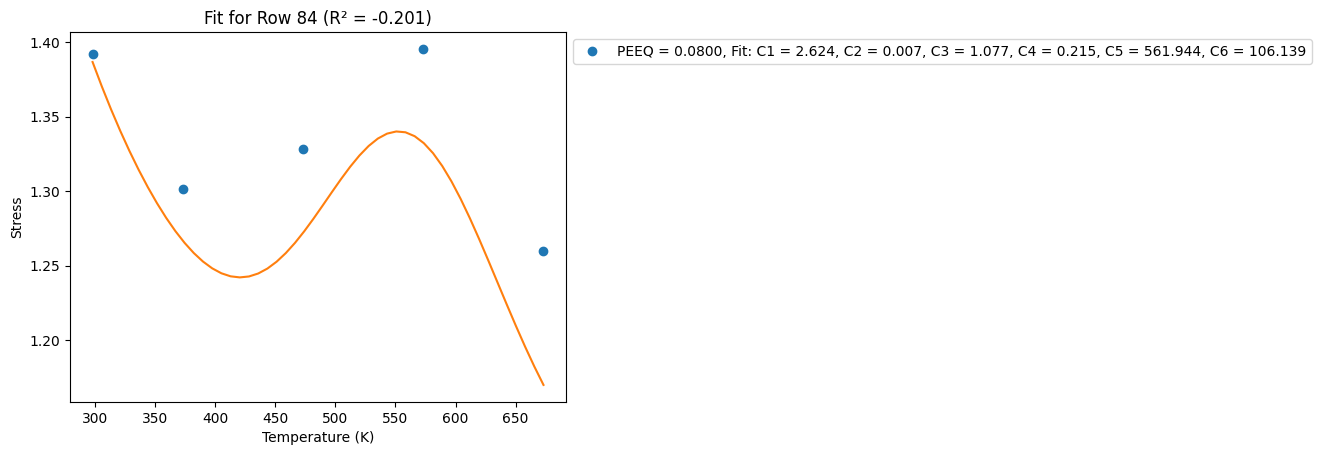

[1.39368486 1.30243683 1.33024788 1.39770964 1.26208691]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


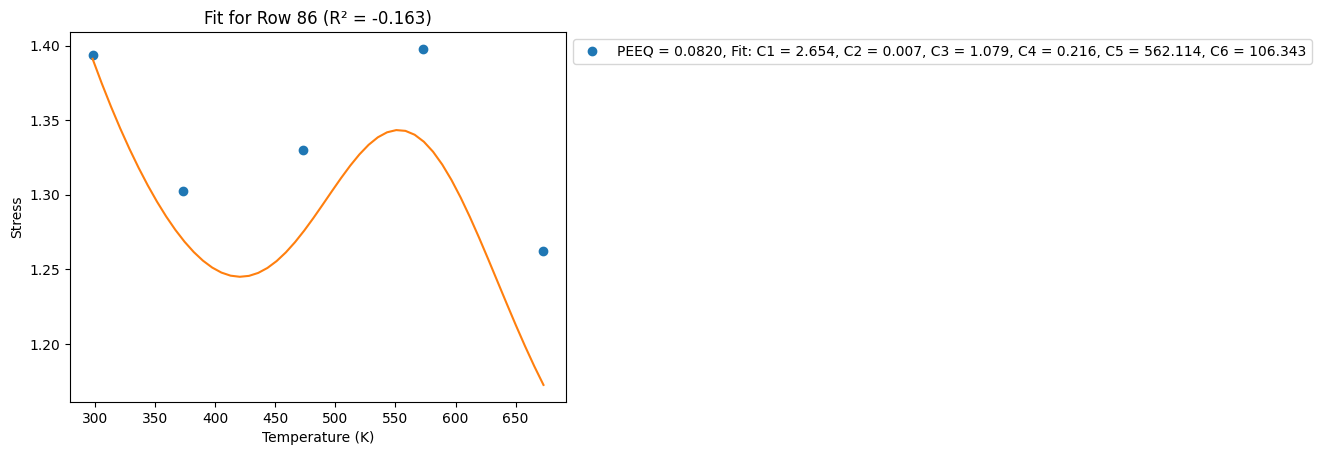

[1.39522594 1.30359333 1.33196934 1.3998764  1.26415833]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


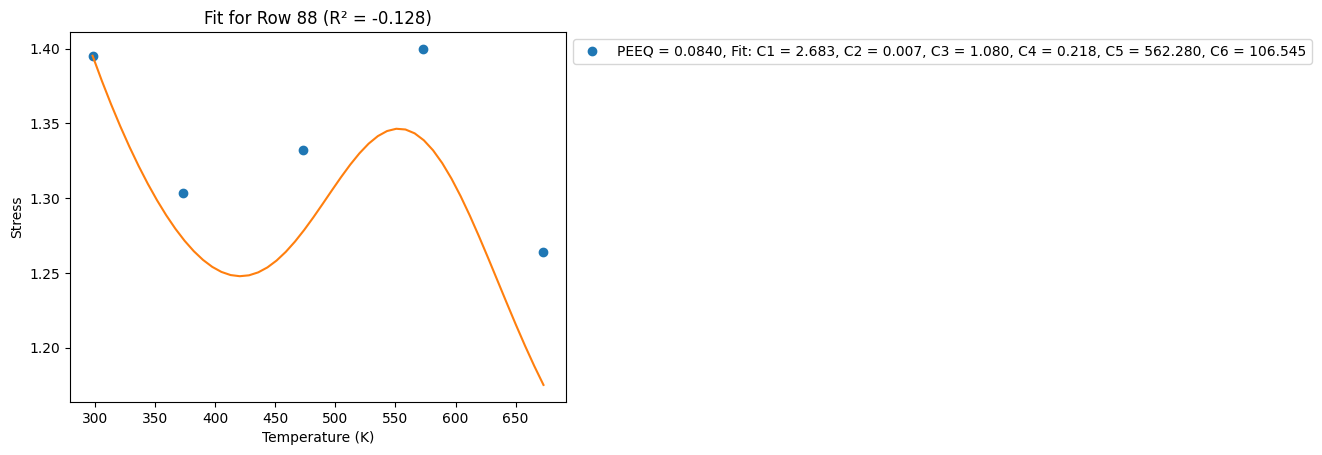

[1.39671891 1.30472743 1.3336442  1.40198821 1.26618043]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


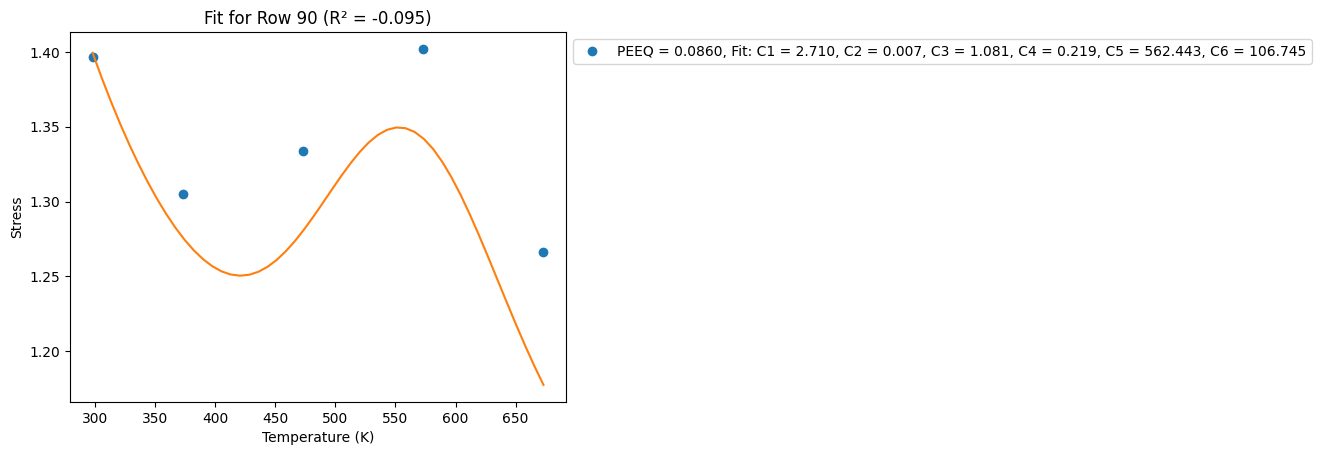

[1.39816635 1.30584009 1.33527513 1.40404768 1.26815552]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


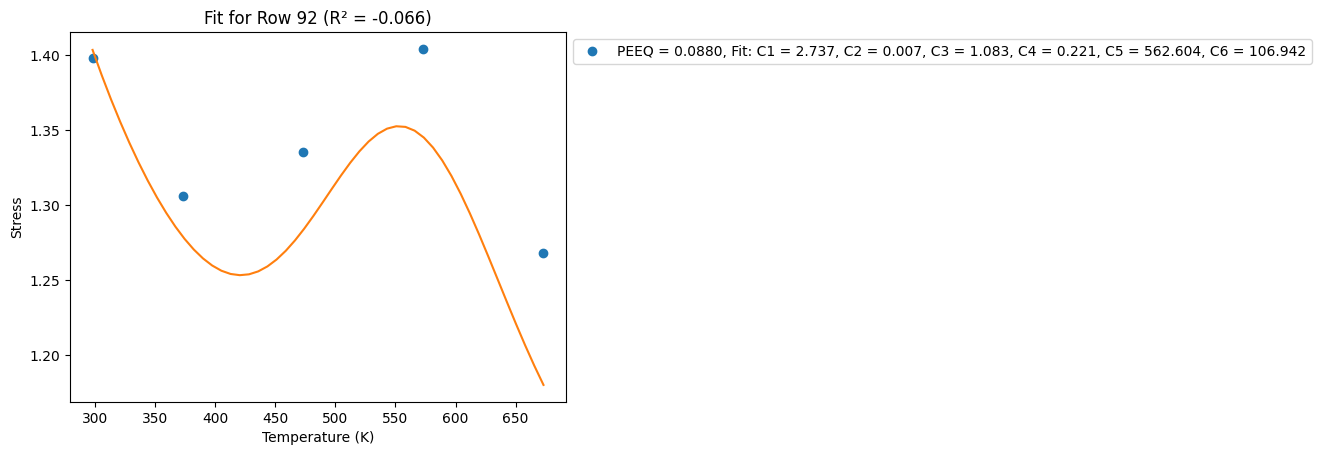

[1.39957061 1.3069322  1.33686458 1.40605727 1.27008574]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


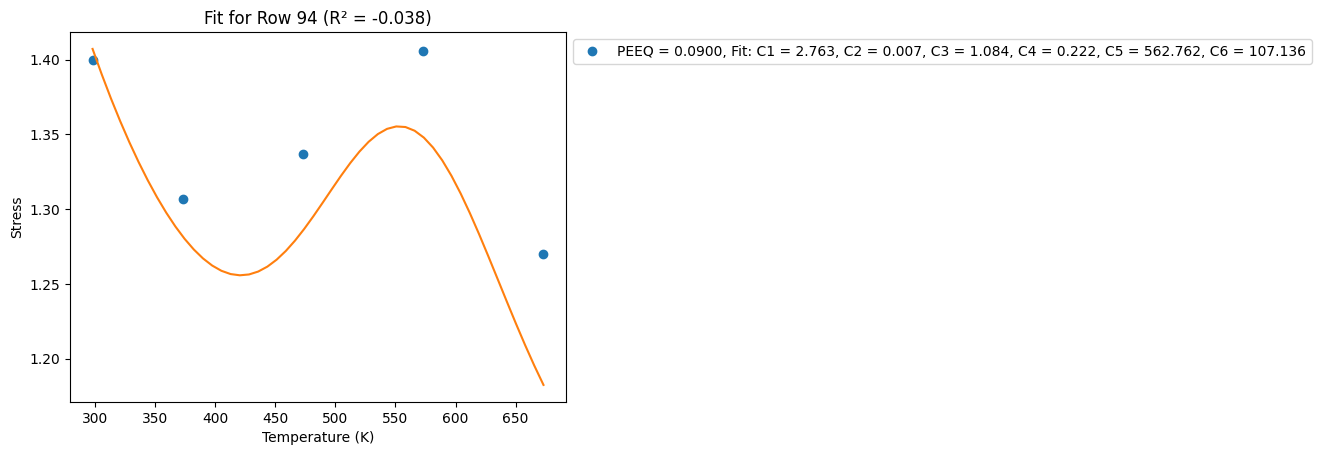

[1.4009339  1.30800458 1.3384148  1.40801928 1.27197308]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


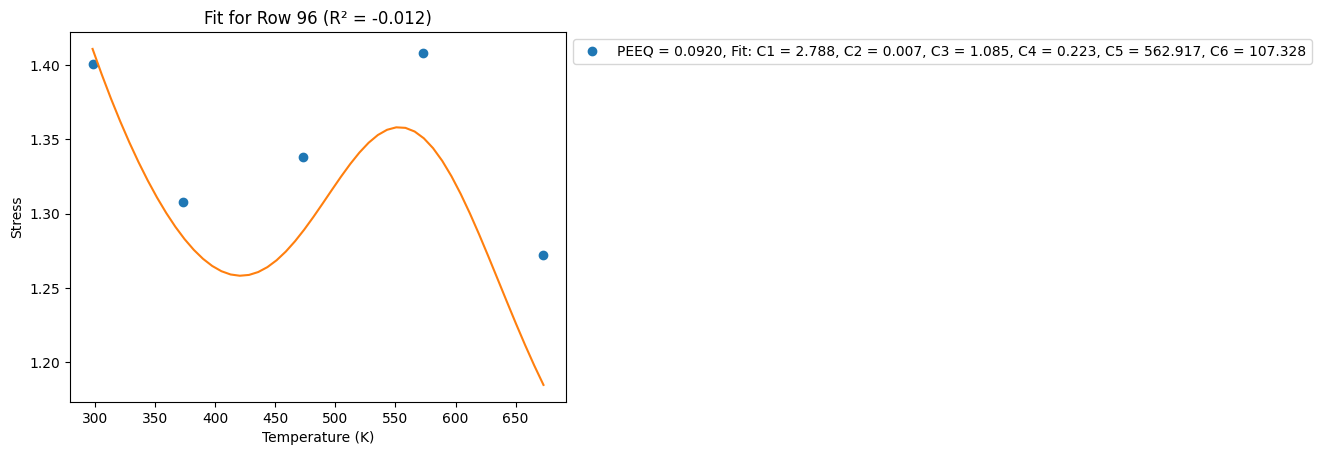

[1.40225826 1.30905802 1.33992786 1.40993583 1.2738194 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


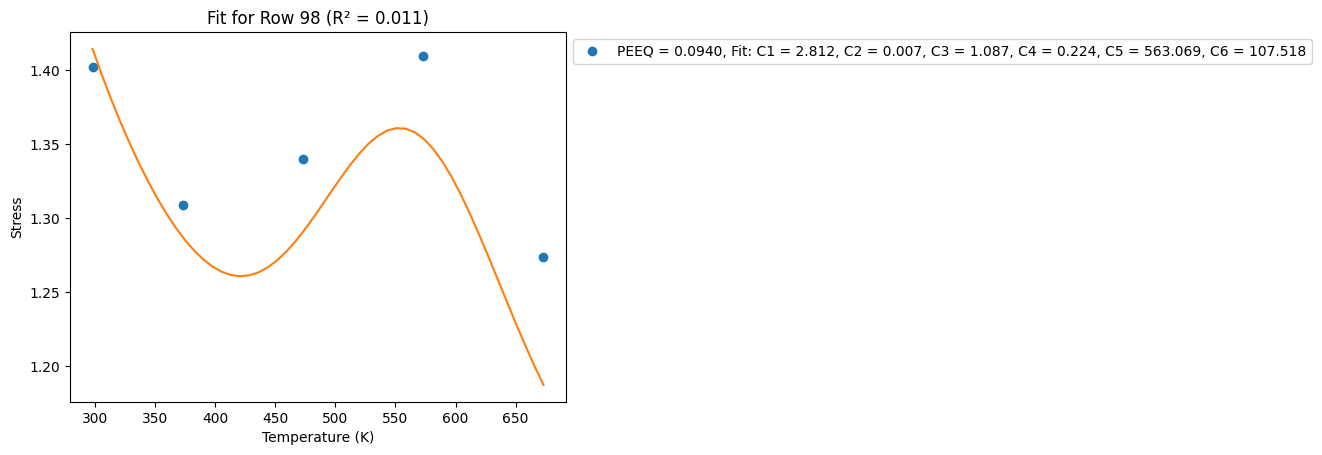

[1.40354559 1.31009324 1.34140566 1.41180891 1.27562644]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


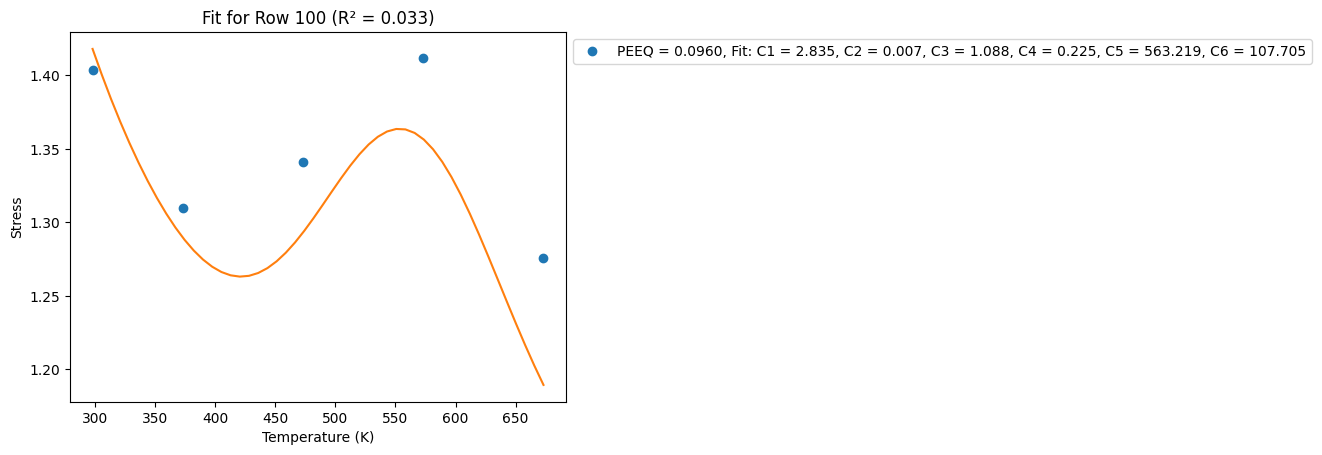

/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


[1.40479766 1.31111093 1.34284995 1.41364041 1.27739585]


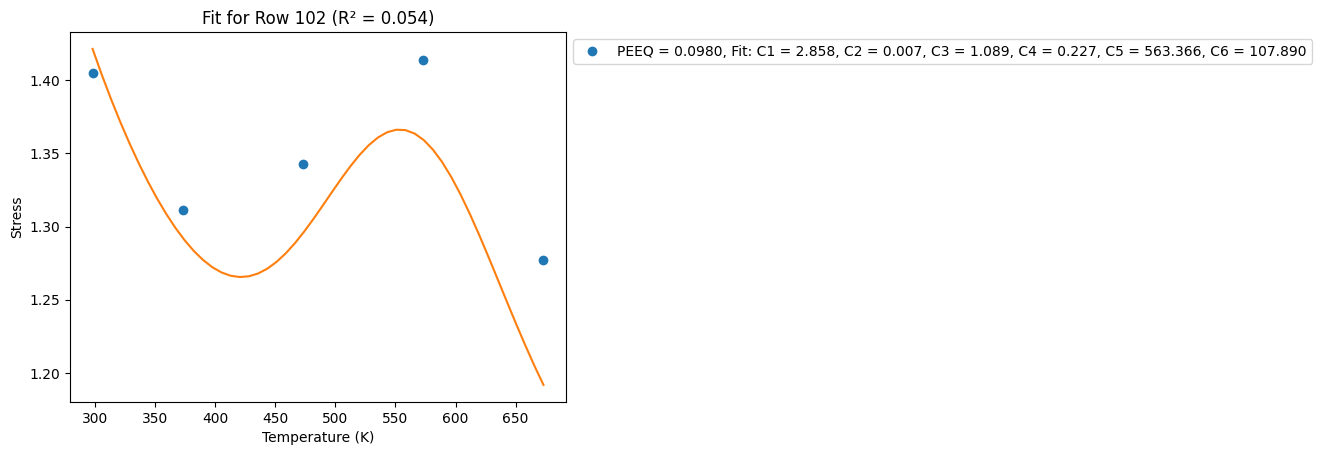

[1.40601612 1.31211175 1.34426236 1.41543207 1.27912916]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


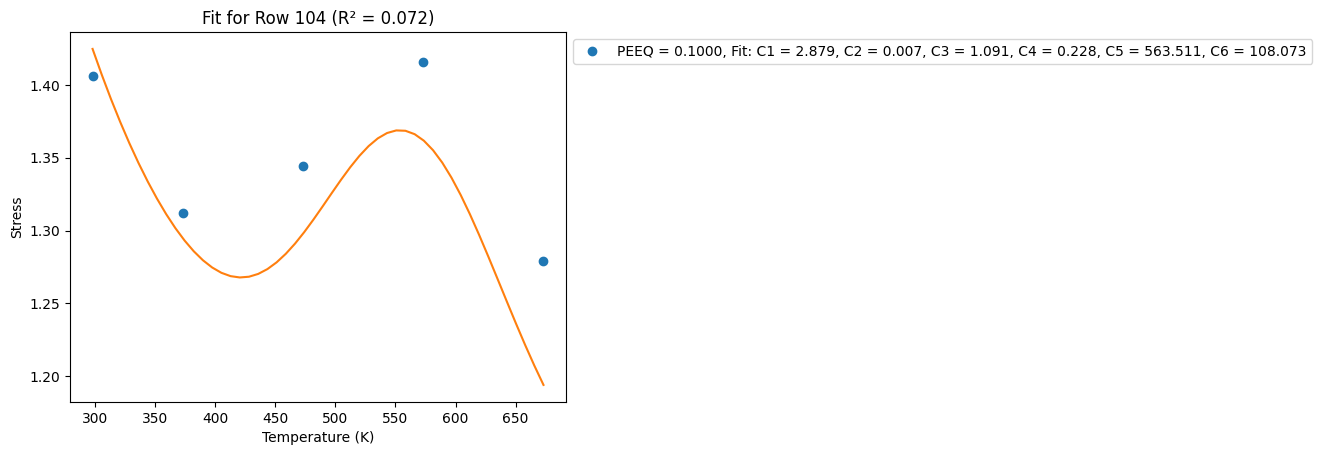

[1.41218111 1.31734033 1.35152281 1.42464279 1.28807752]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


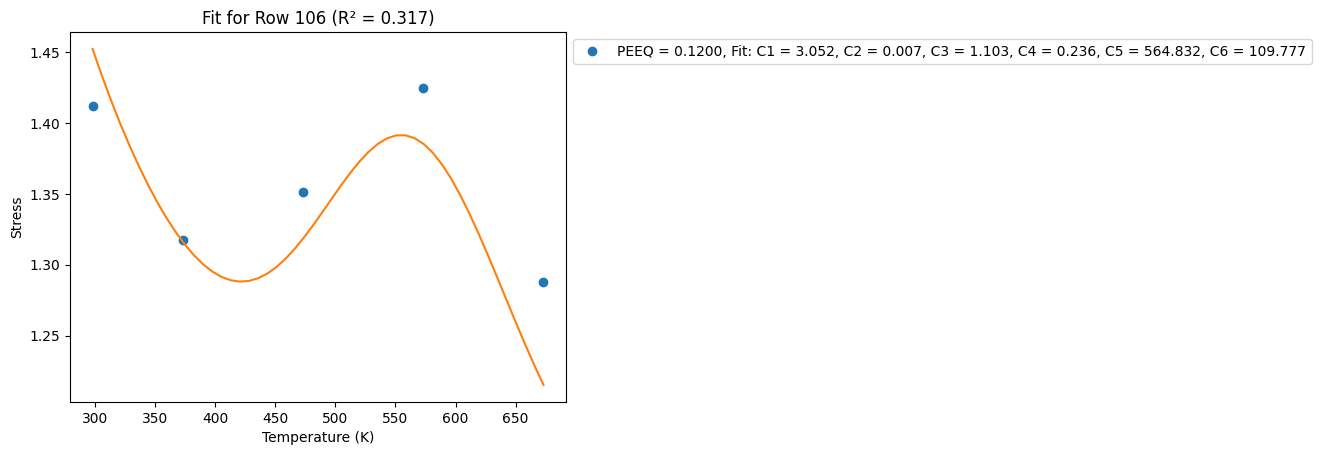

[1.42153646 1.32584697 1.3629649  1.43911452 1.30226618]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


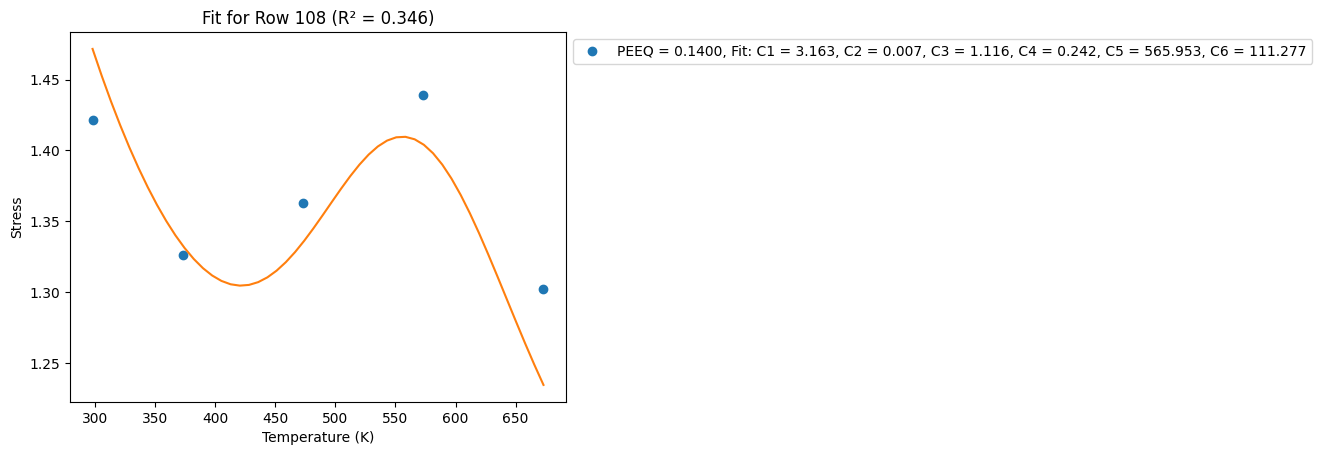

[1.42915606 1.33335061 1.37273374 1.4513829  1.31442092]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


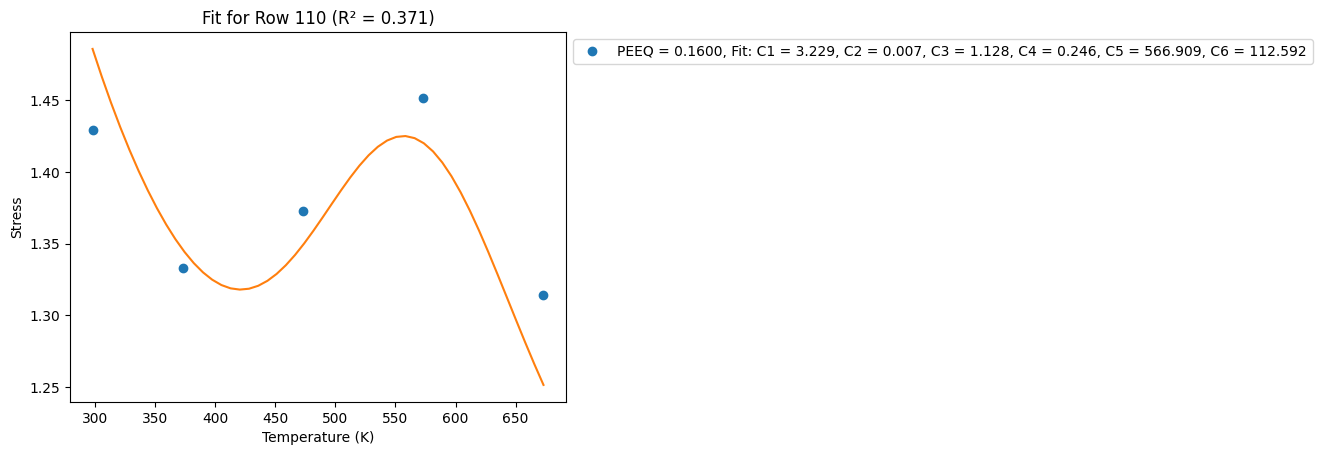

[1.43553398 1.3400822  1.3812688  1.46201701 1.32505244]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


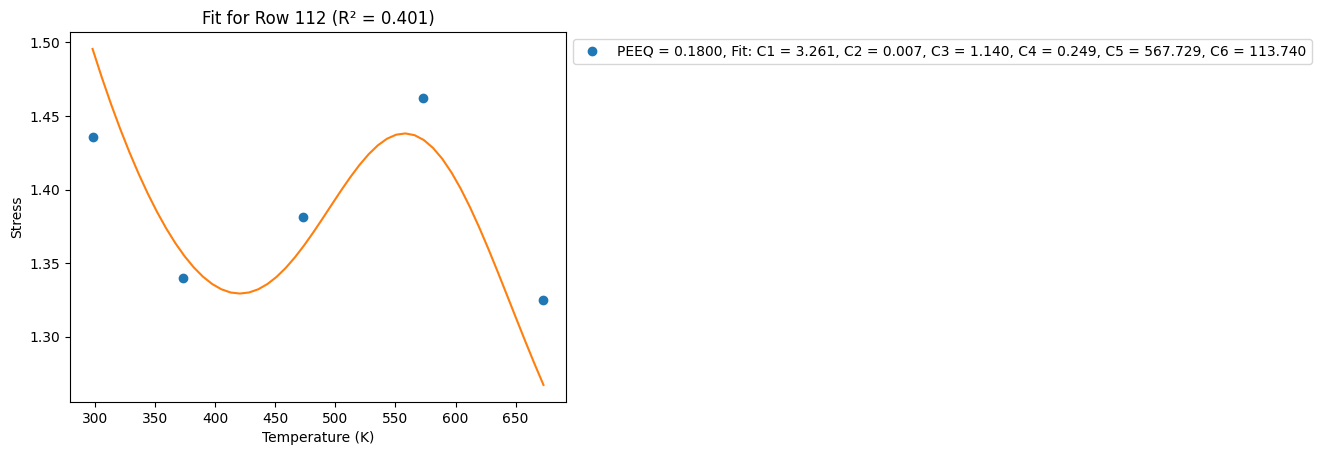

[1.44098526 1.34619935 1.38885099 1.47139192 1.33450035]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


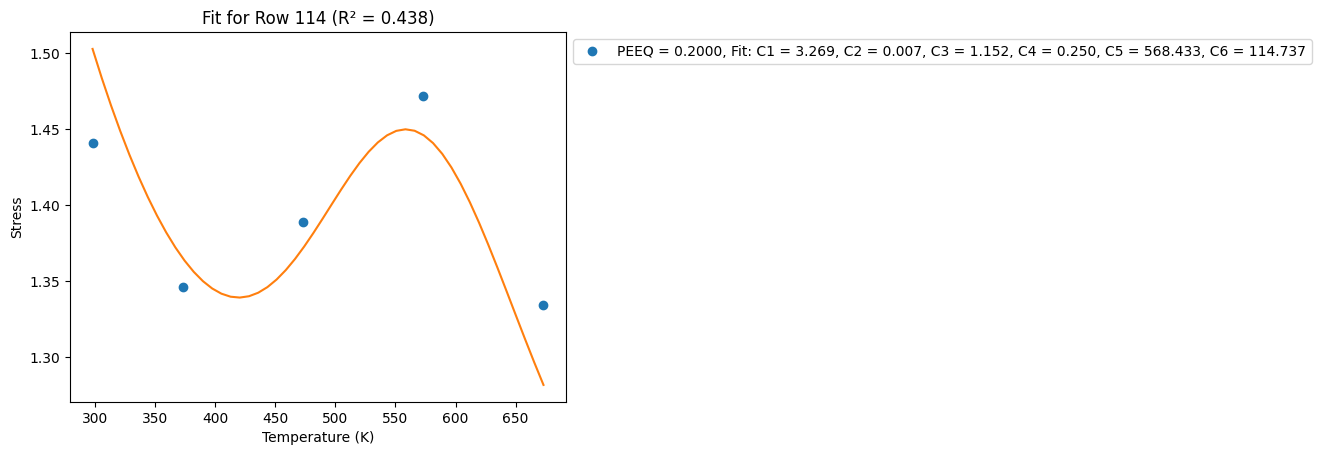

[1.44572198 1.35181476 1.3956731  1.47976765 1.34300202]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


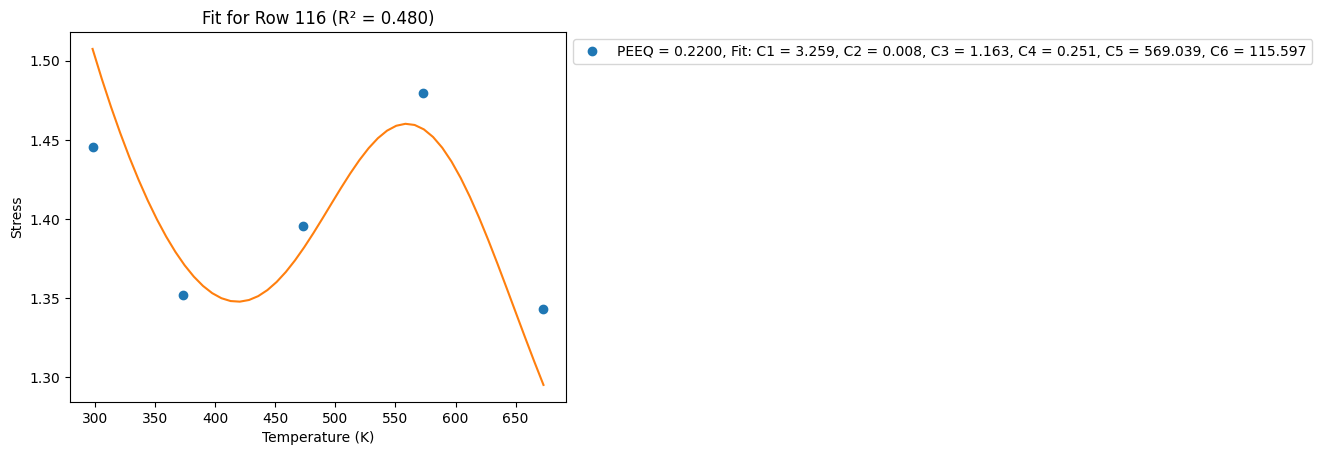

[1.4498931  1.35701194 1.40187411 1.48733178 1.35072985]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


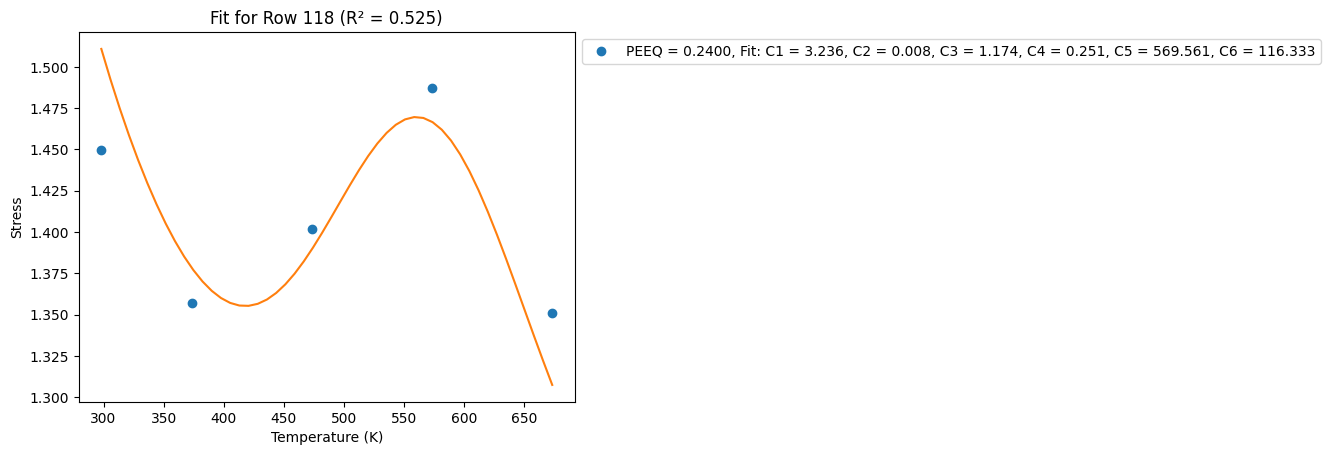

[1.45360686 1.36185466 1.40755785 1.49422396 1.35781304]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


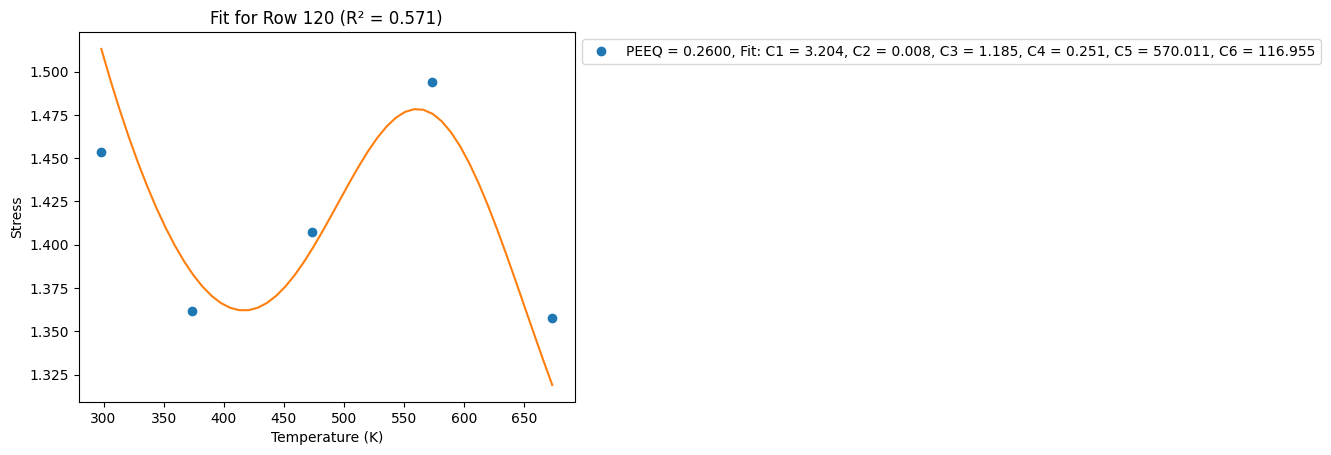

[1.4569442  1.36639275 1.41280407 1.50055092 1.36435091]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


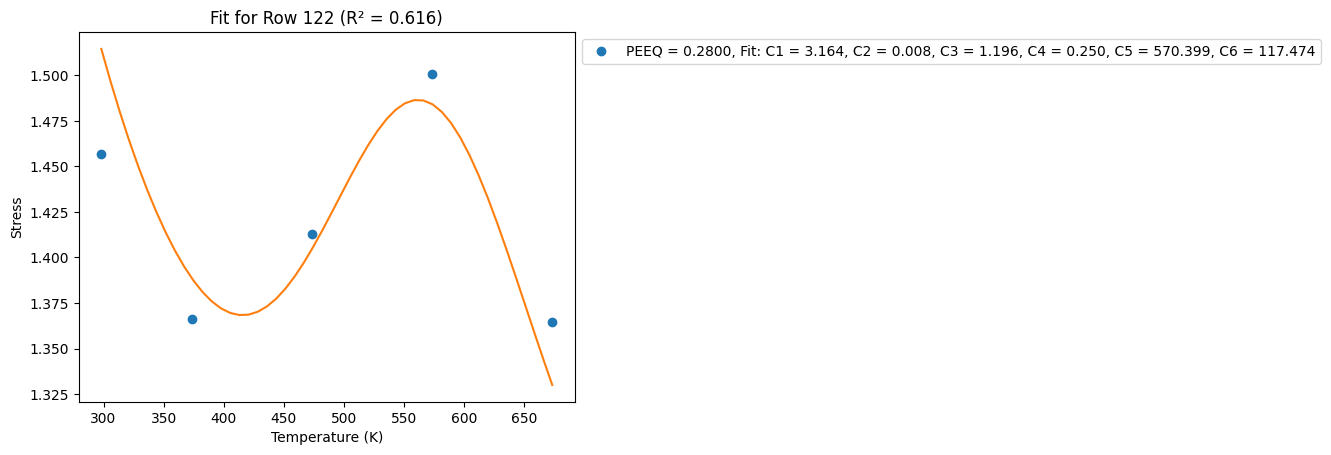

[1.45996701 1.37066593 1.41767534 1.50639602 1.37042147]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


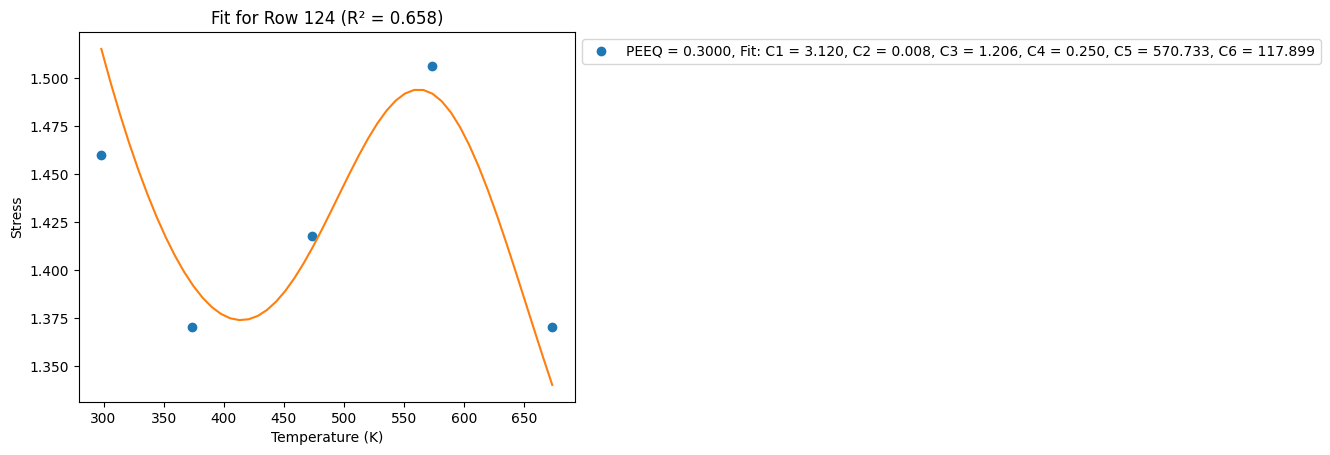

[1.46272365 1.37470644 1.42222172 1.5118256  1.37608708]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


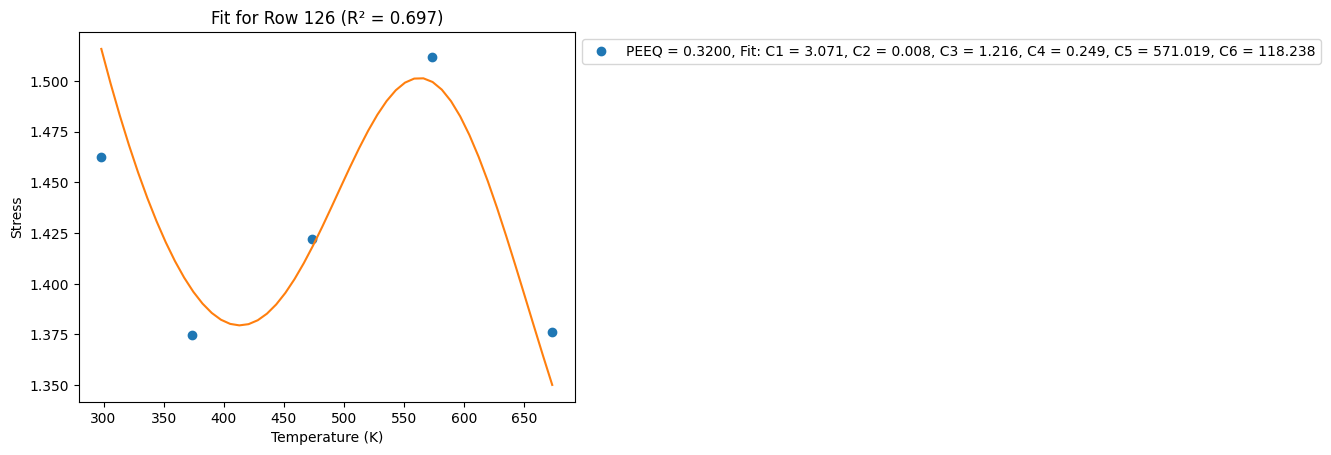

[1.4652525  1.37854079 1.42648385 1.51689329 1.38139842]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


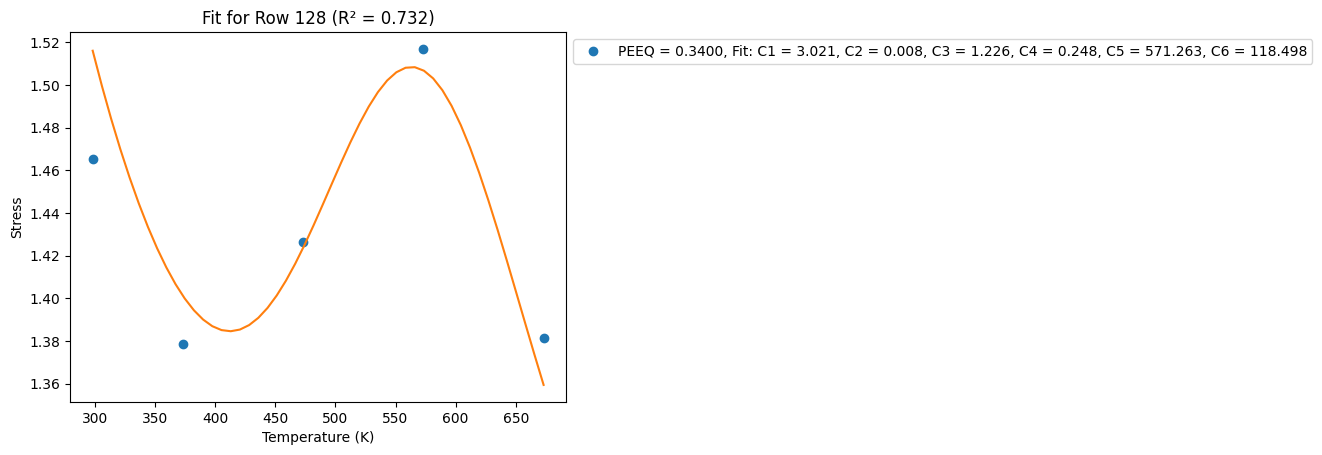

[1.4675845  1.3821911  1.43049519 1.52164304 1.3863972 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


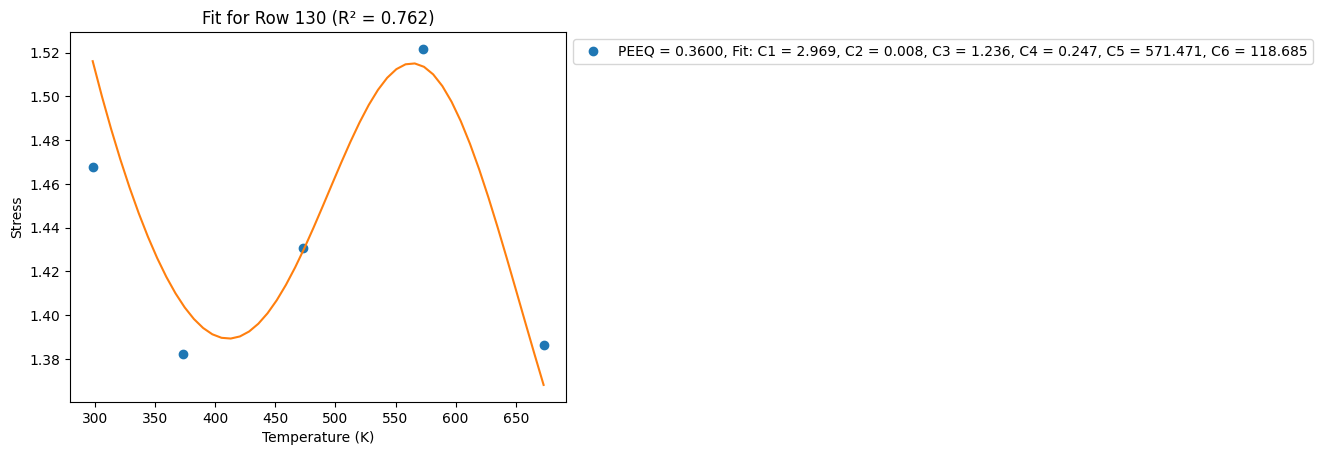

[1.46974492 1.385676   1.43428363 1.52611135 1.39111816]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


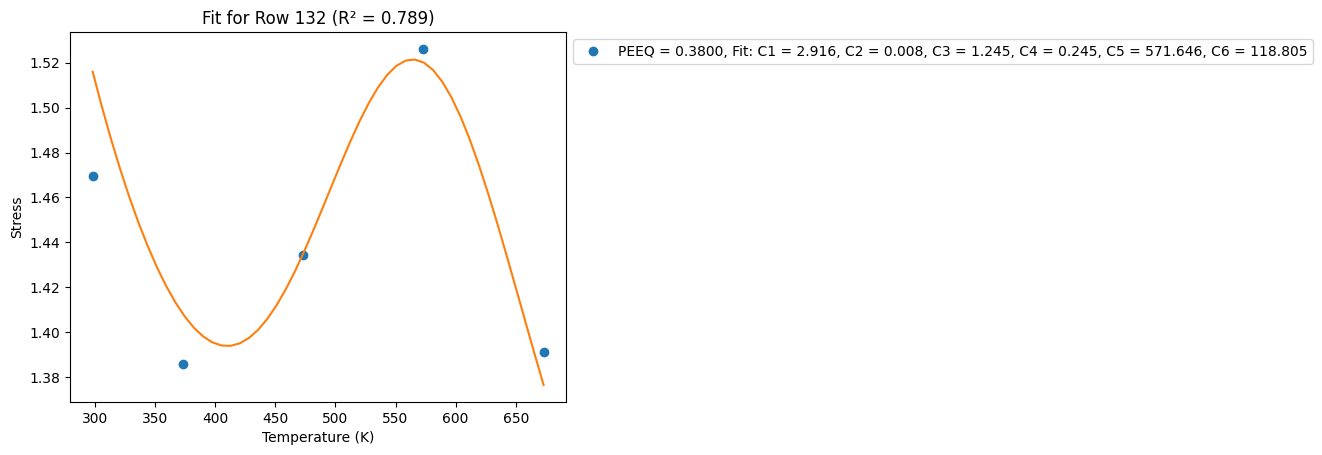

[1.47175466 1.38901134 1.43787264 1.5303288  1.39559058]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


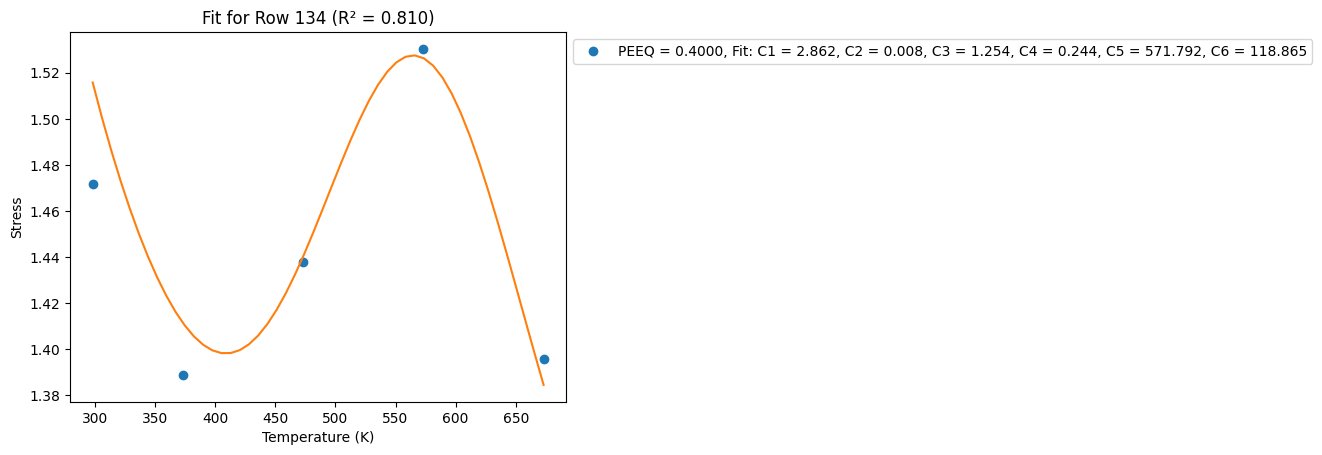

[1.47363115 1.39221074 1.44128217 1.5343213  1.39983932]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


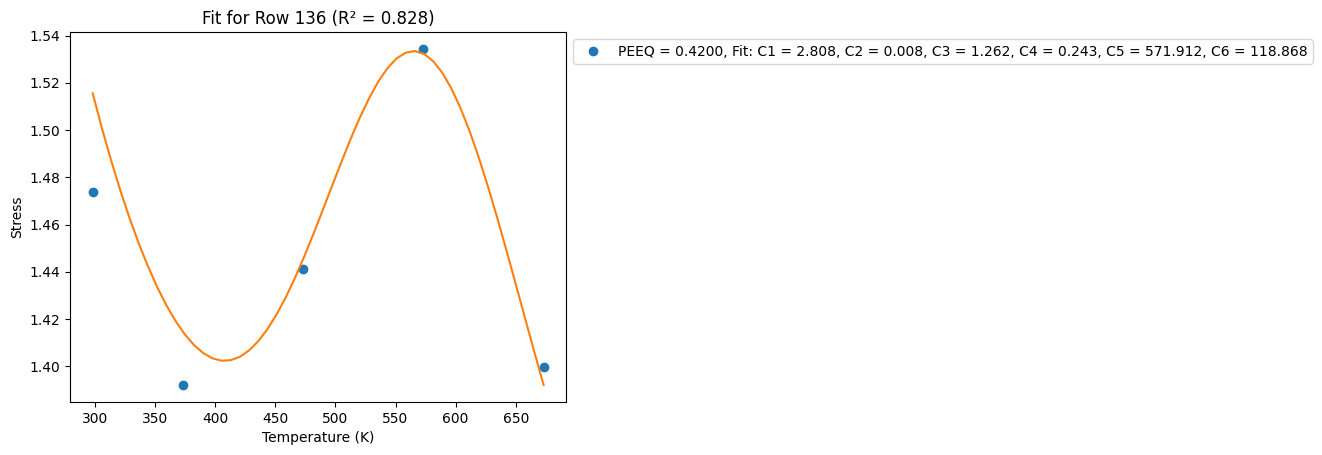

[1.47538907 1.39528598 1.44452933 1.53811097 1.40388569]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


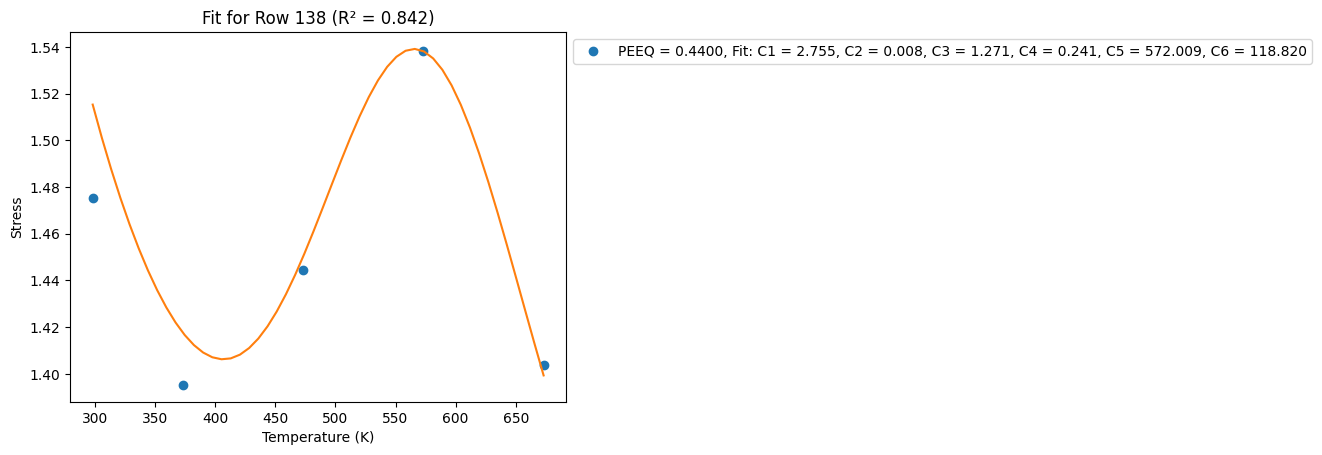

[1.47704092 1.39824733 1.44762888 1.54171686 1.40774809]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


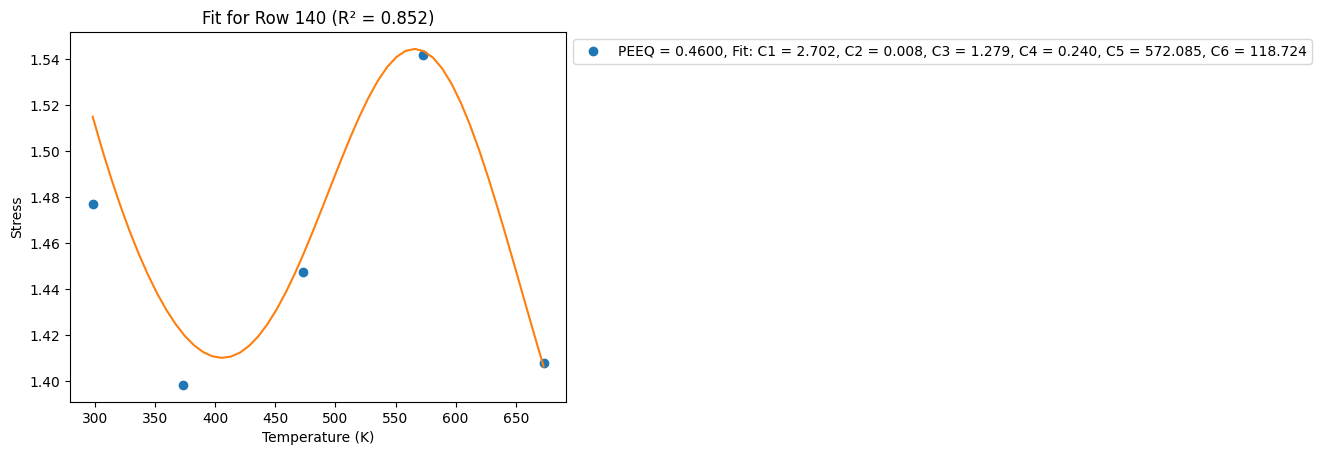

[1.47859737 1.4011038  1.45059367 1.54515547 1.41144254]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


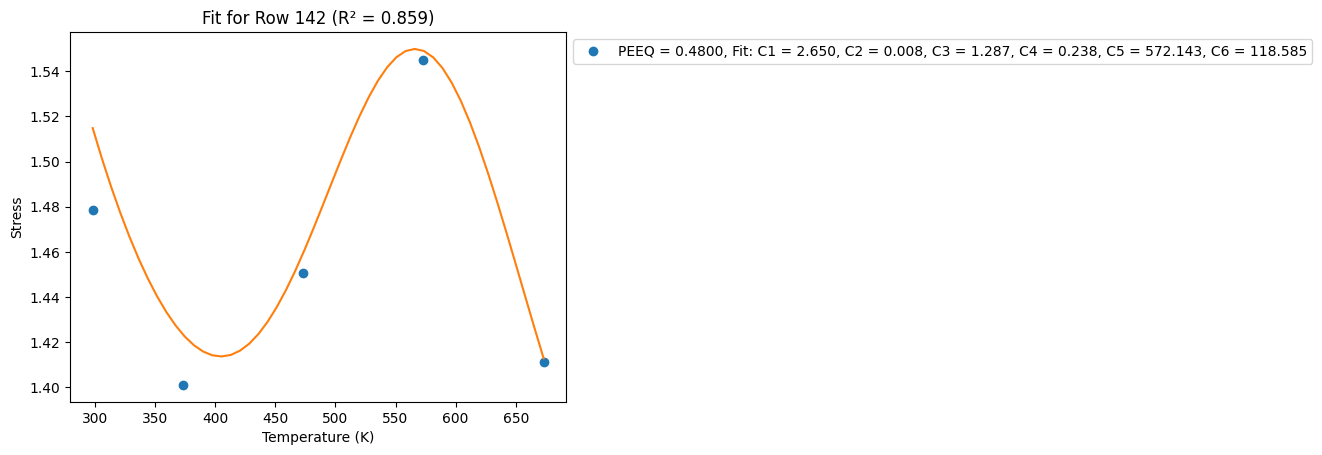

[1.48006766 1.40386335 1.45343491 1.54844121 1.41498304]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


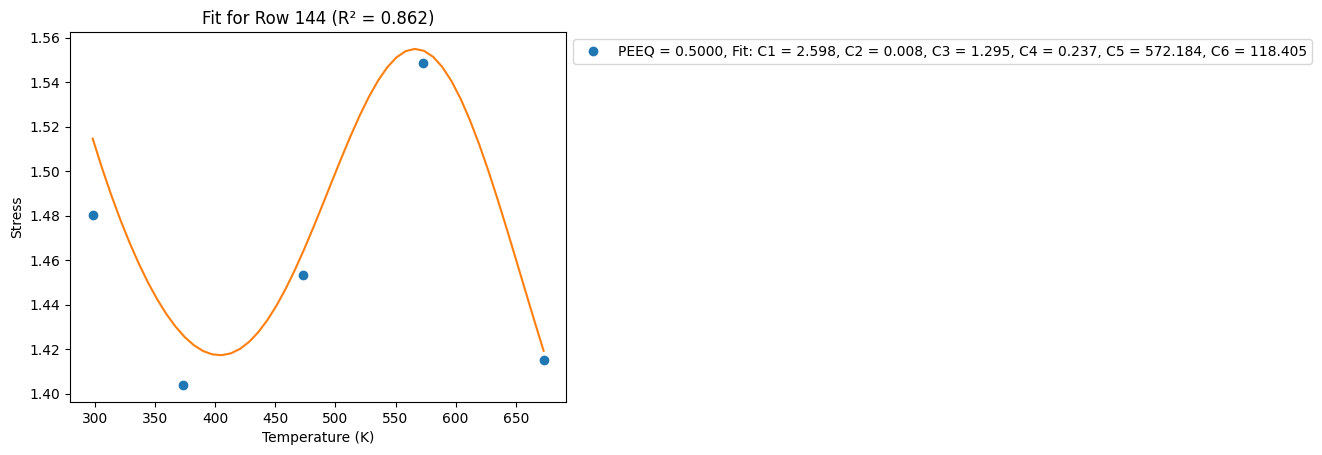

[1.48145977 1.40653302 1.45616251 1.5515867  1.41838189]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


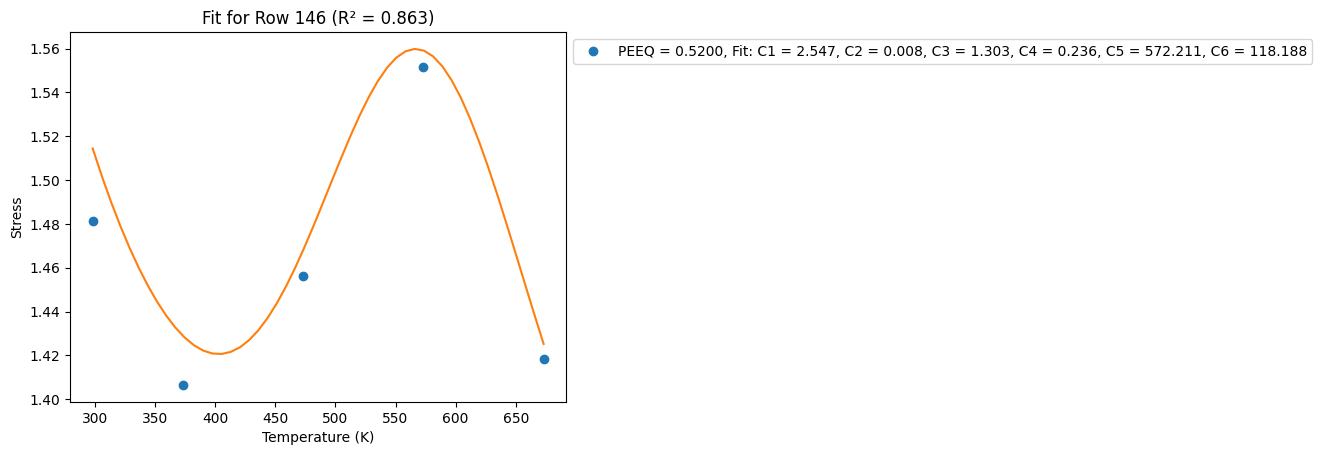

[1.48278068 1.4091191  1.4587852  1.55460309 1.42165001]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


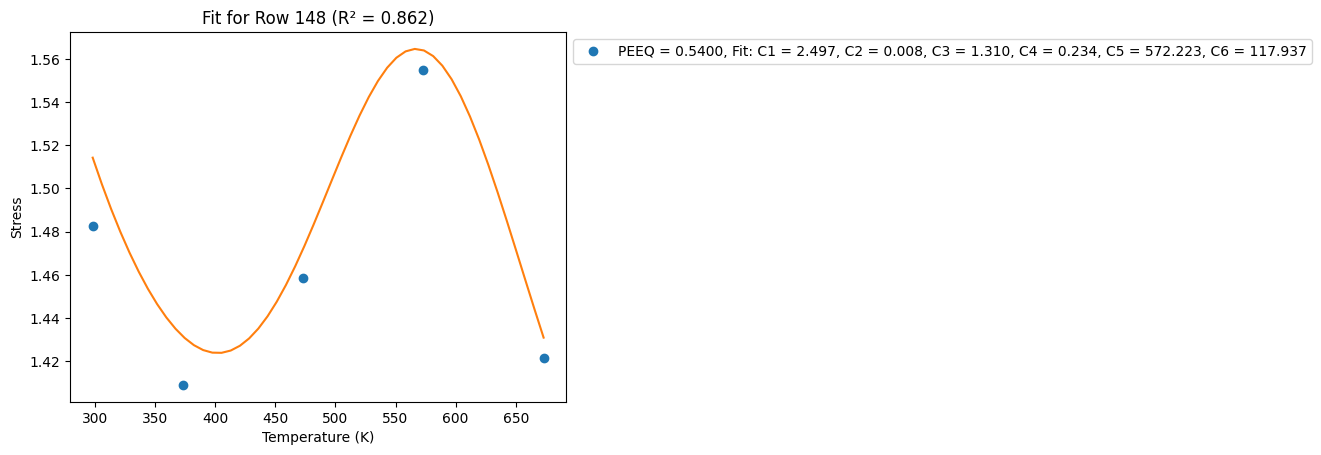

[1.48403651 1.41162721 1.46131076 1.55750026 1.42479707]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


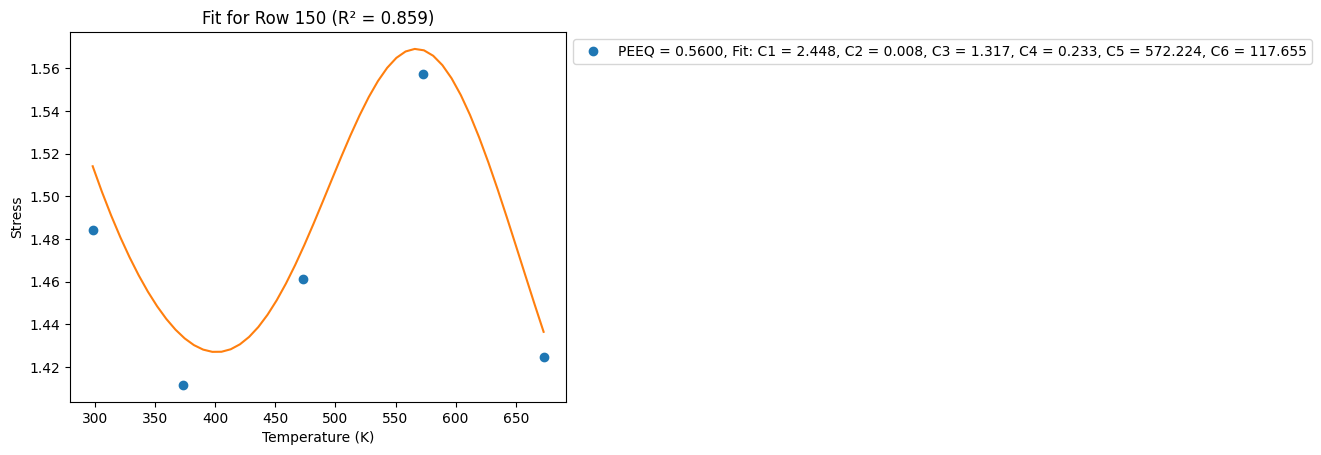

[1.48523265 1.41406242 1.46374612 1.56028701 1.42783174]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


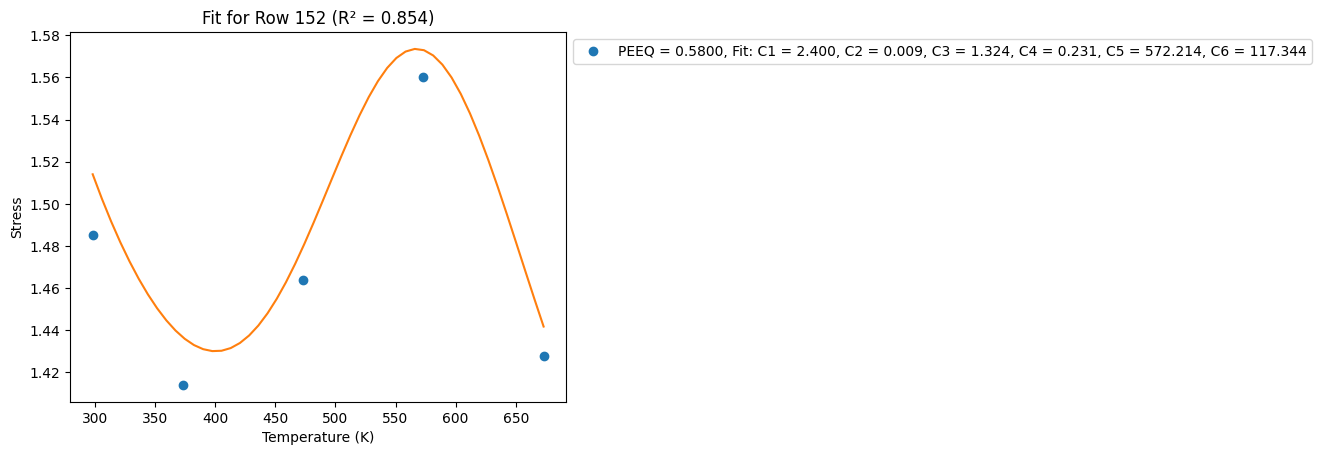

[1.4863739  1.4164293  1.46609751 1.56297119 1.43076175]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


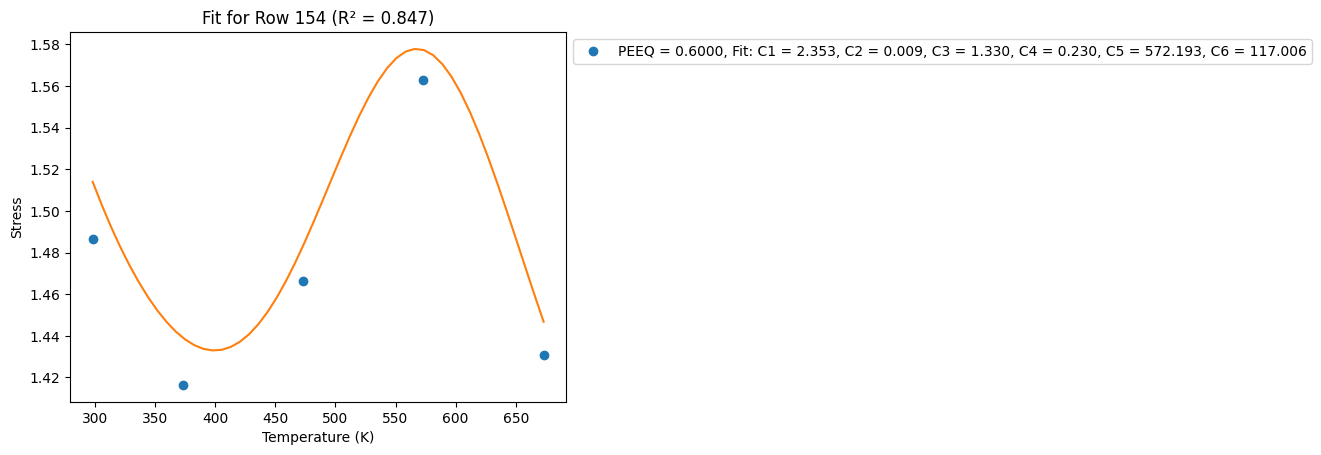

[1.48746449 1.41873198 1.46837052 1.56555988 1.43359409]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


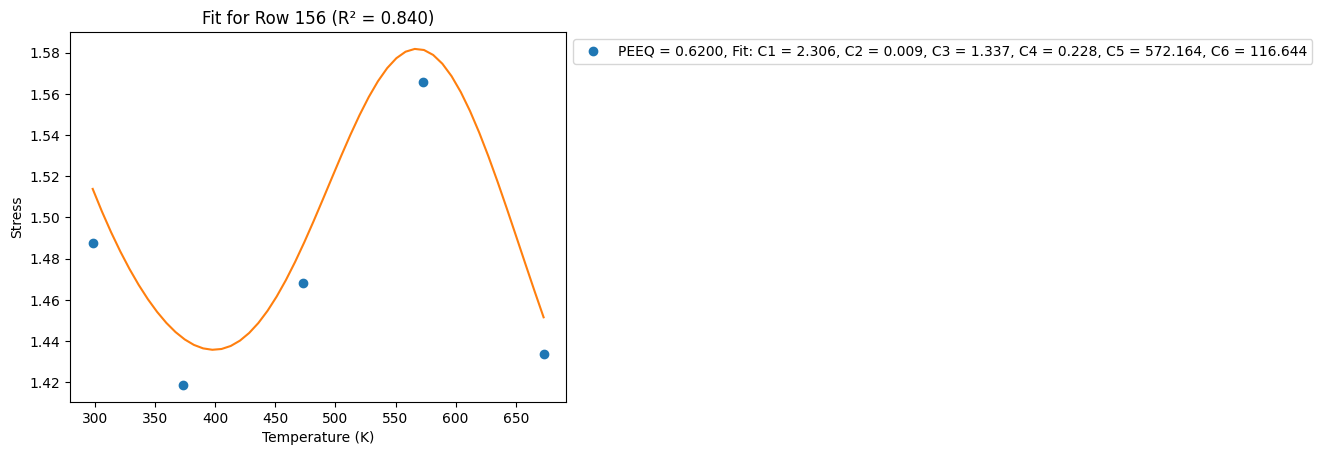

[1.48850824 1.42097424 1.47057022 1.56805944 1.43633507]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


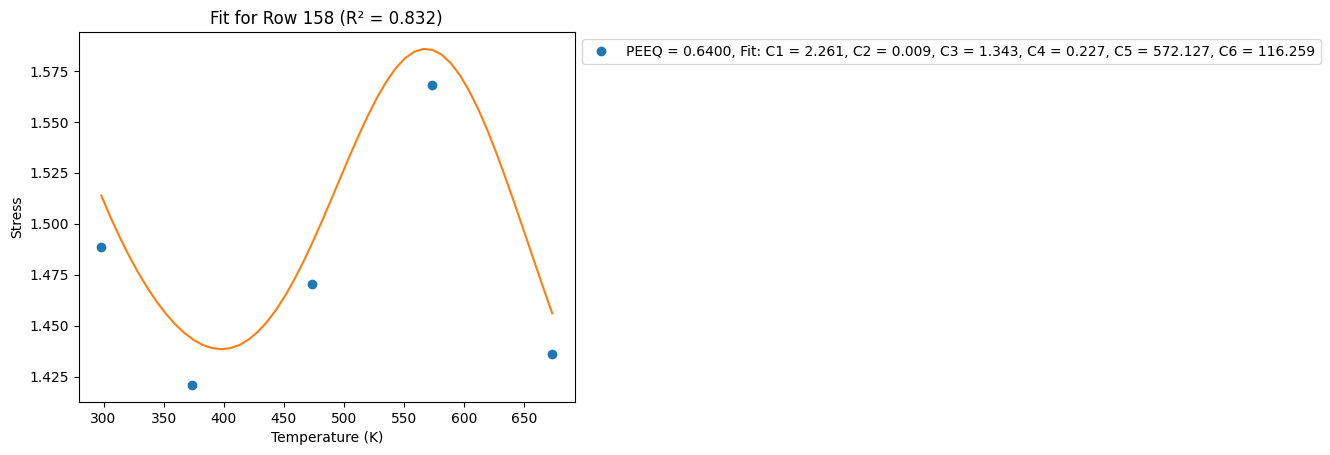

[1.48950853 1.42315949 1.47270118 1.57047563 1.43899038]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


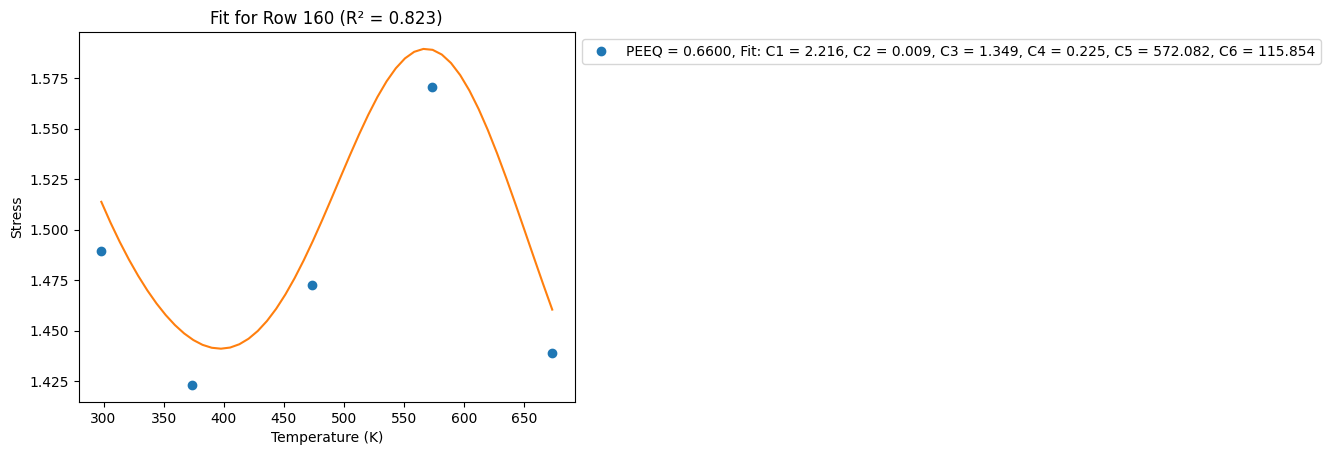

[1.49046843 1.42529088 1.47476757 1.57281367 1.44156523]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


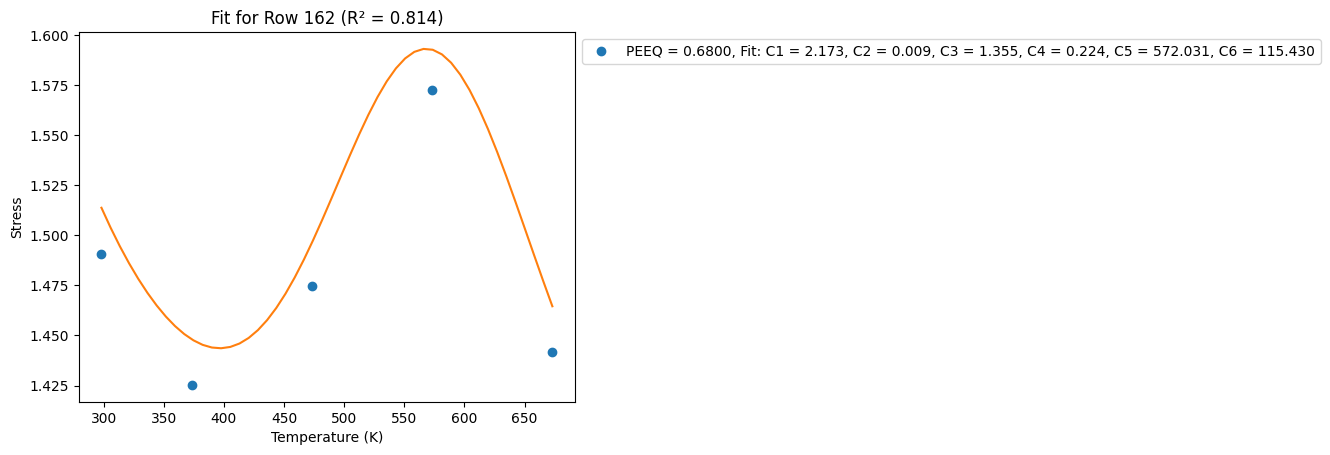

[1.49139071 1.42737128 1.4767732  1.5750783  1.44406435]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


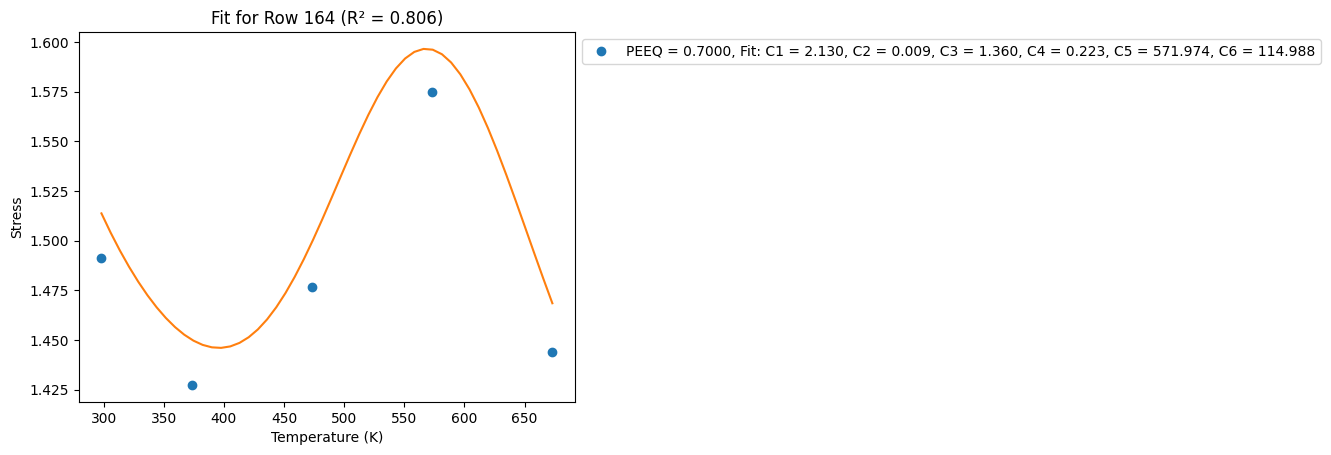

/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


[1.49227786 1.42940335 1.47872152 1.57727386 1.44649207]


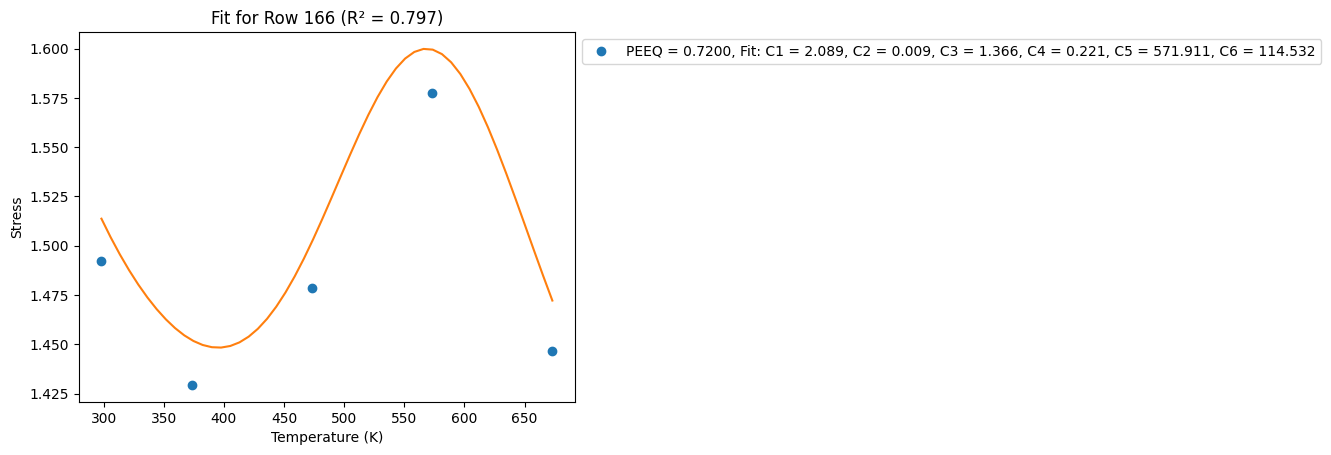

[1.49313215 1.43138951 1.48061574 1.57940432 1.44885235]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


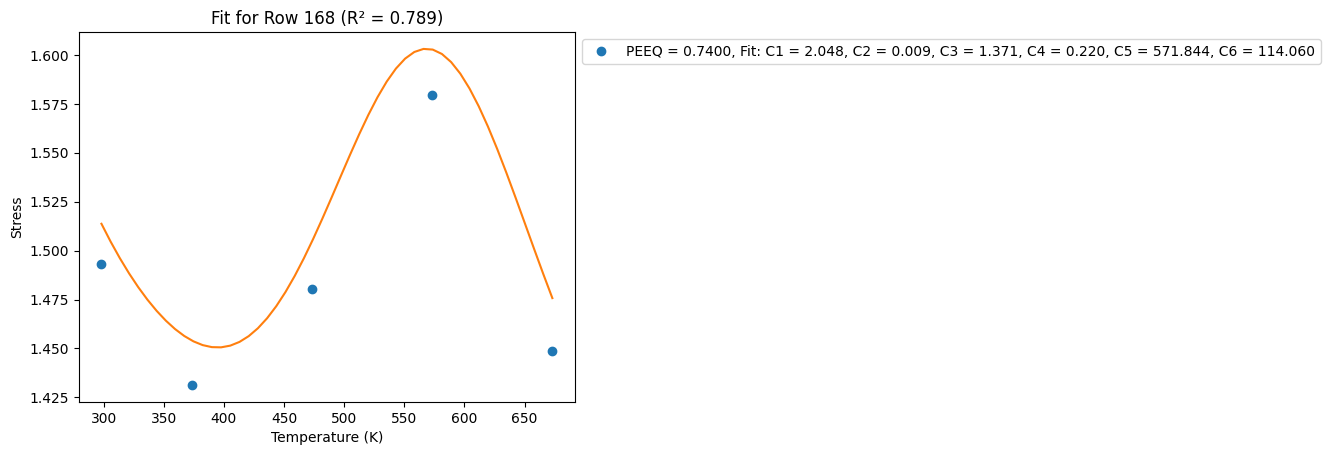

[1.49395566 1.43333203 1.48245876 1.58147331 1.45114884]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


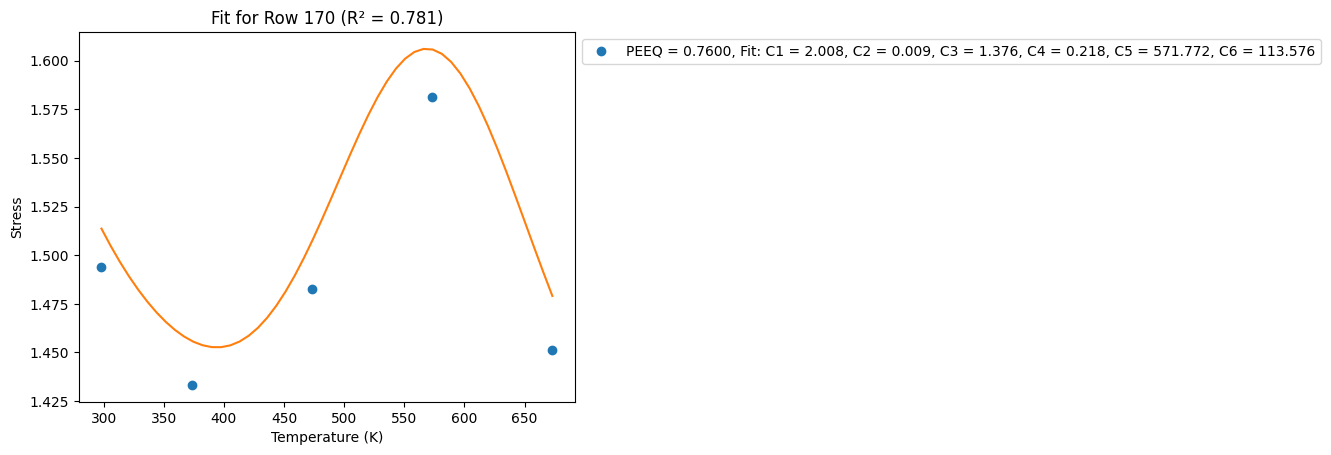

[1.49475026 1.43523298 1.48425329 1.58348418 1.45338489]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


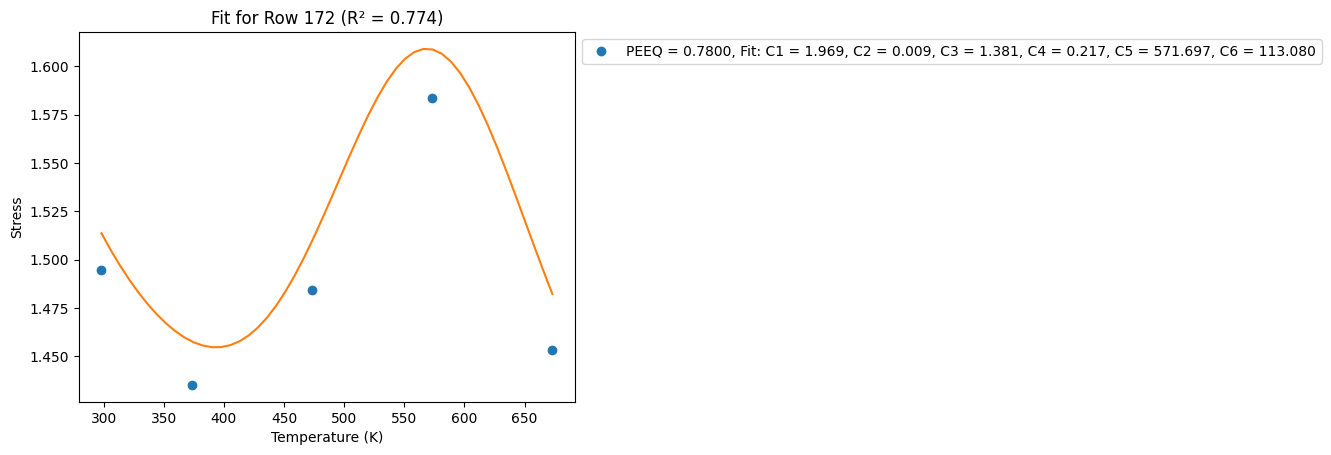

[1.49551768 1.43709431 1.48600181 1.58544    1.45556362]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


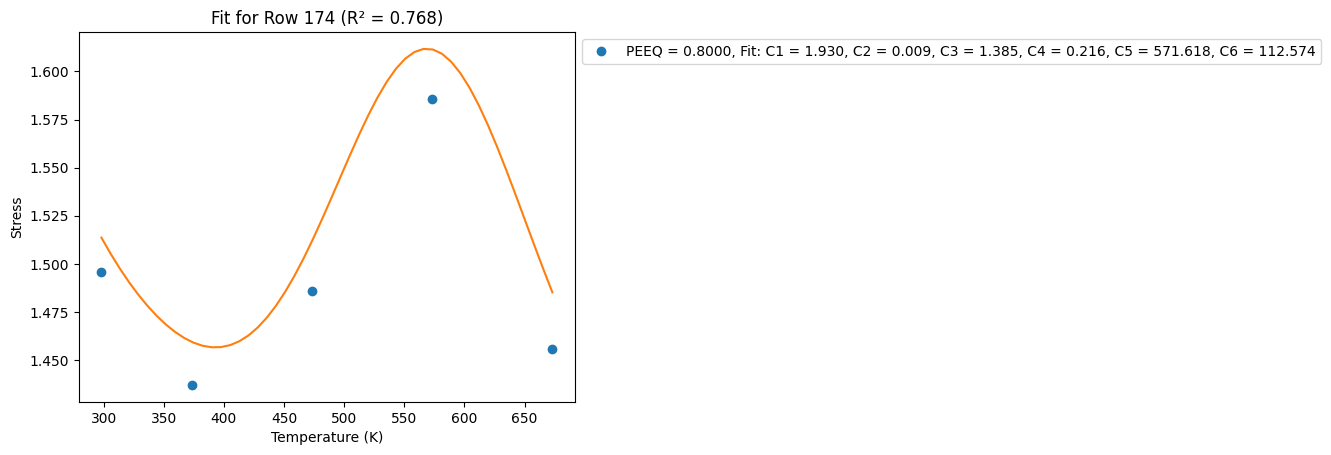

[1.49625951 1.4389178  1.48770662 1.58734362 1.45768787]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


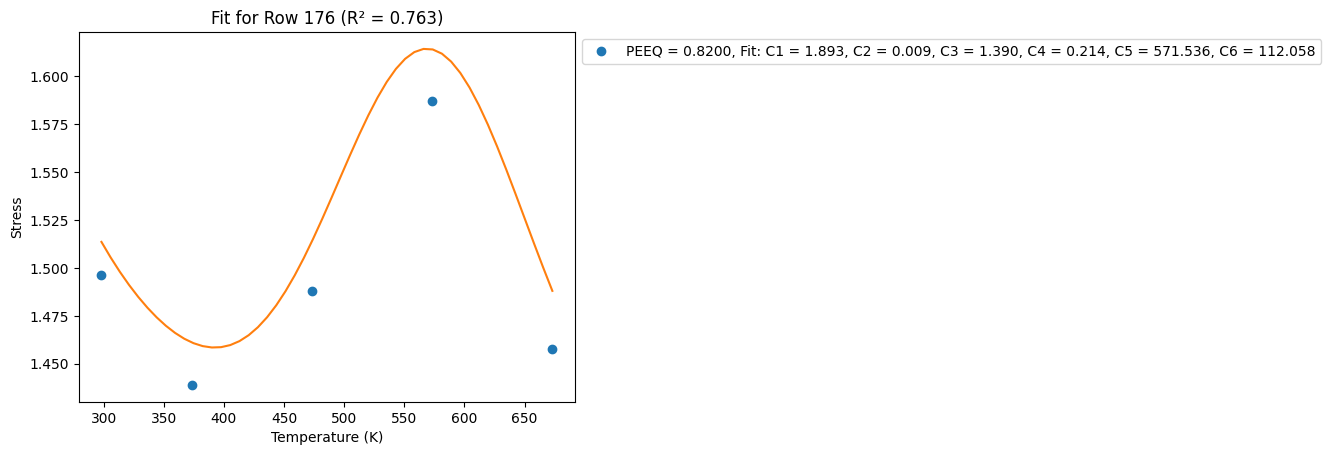

[1.49697719 1.44070515 1.48936986 1.58919766 1.45976032]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


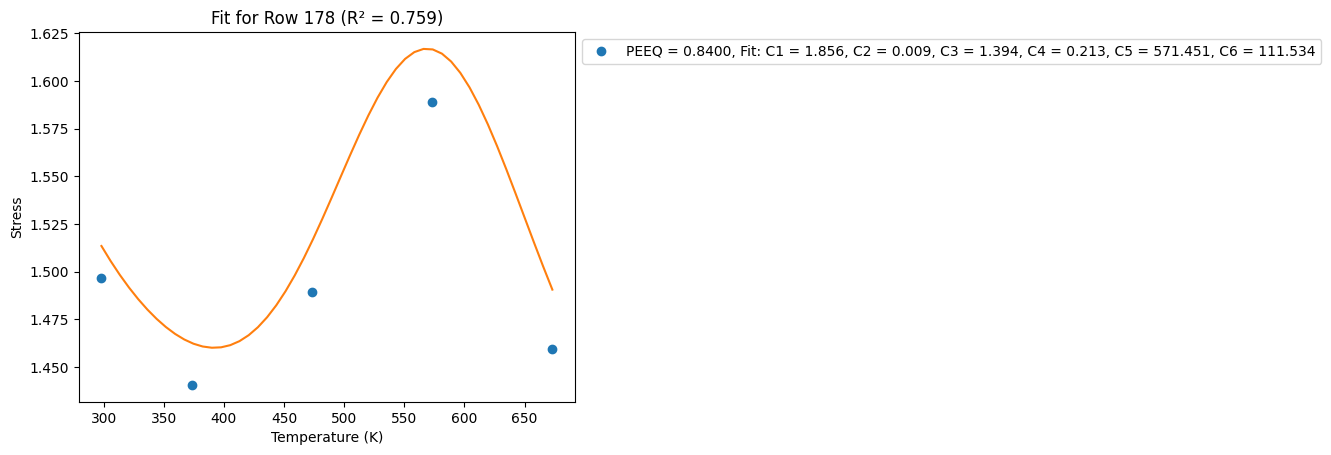

[1.49767206 1.4424579  1.49099351 1.59100458 1.46178343]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


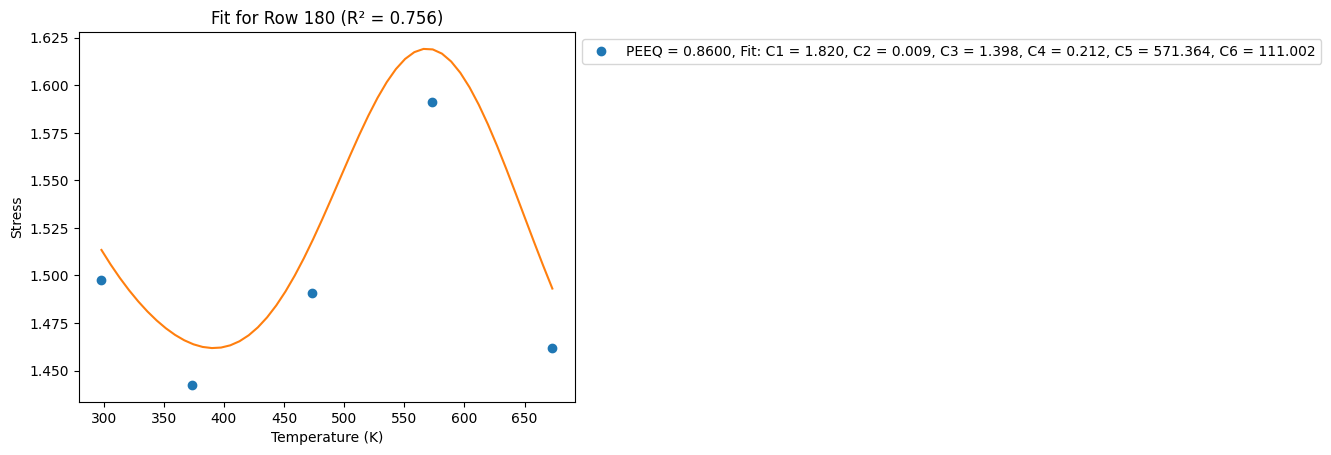

[1.49834537 1.44417752 1.4925794  1.59276664 1.46375949]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


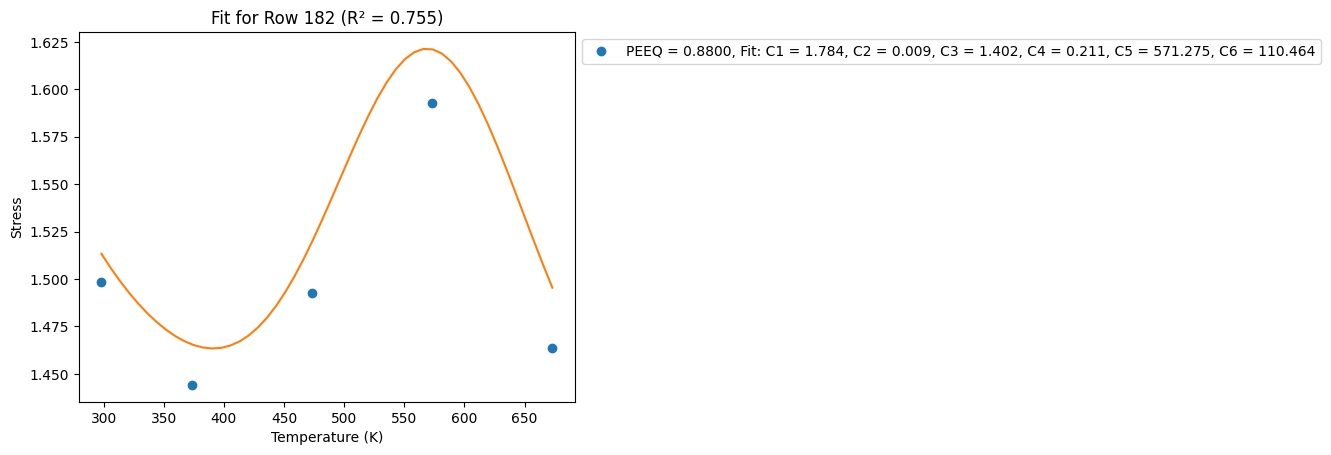

[1.49899825 1.44586538 1.49412925 1.59448593 1.46569064]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


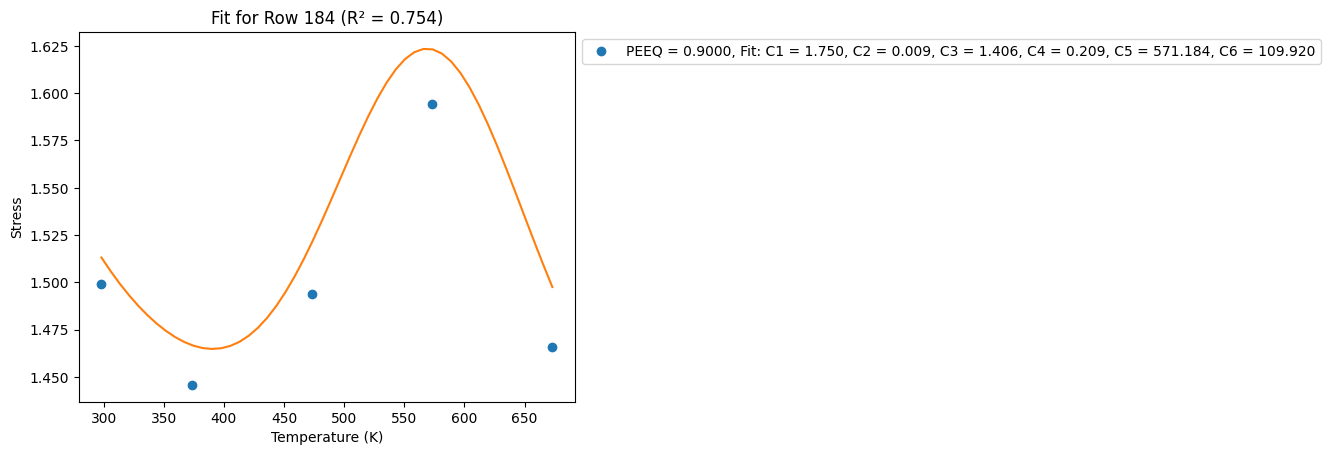

[1.49963176 1.44752276 1.49564467 1.59616444 1.46757887]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


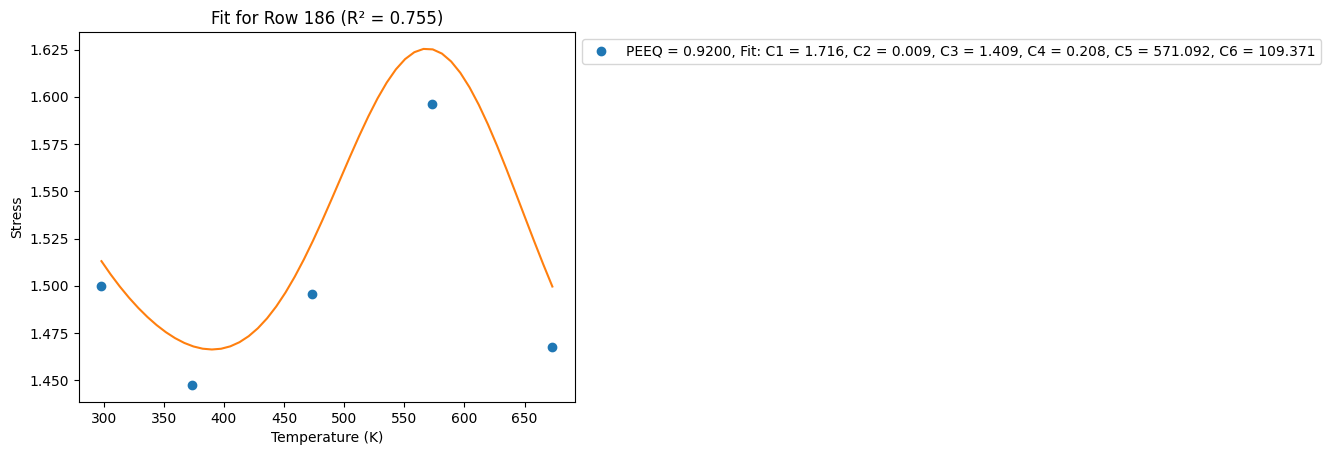

[1.50024688 1.44915085 1.49712714 1.59780398 1.46942607]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


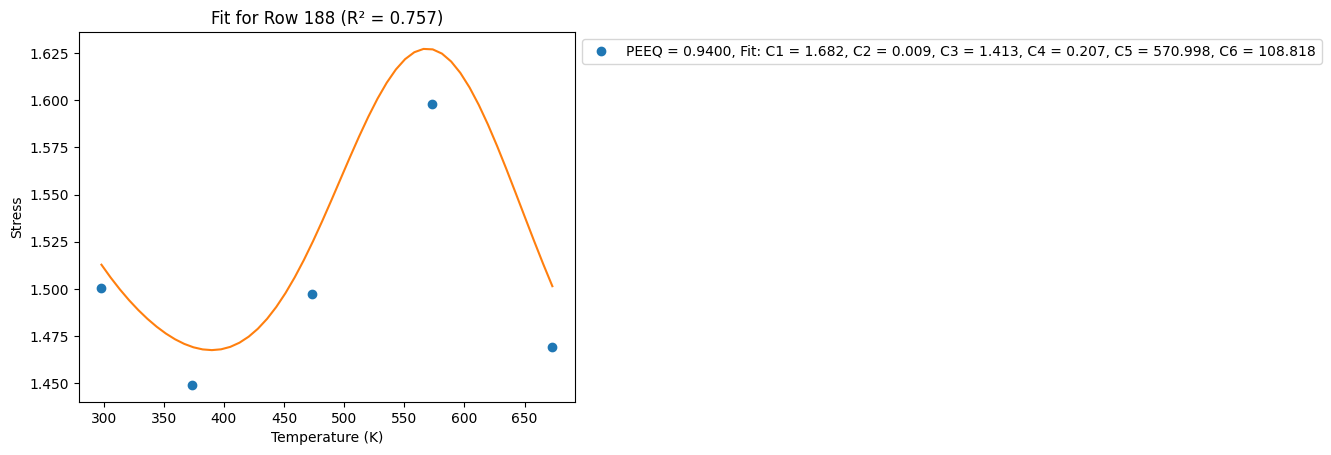

[1.50084452 1.4507508  1.49857808 1.59940627 1.47123396]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


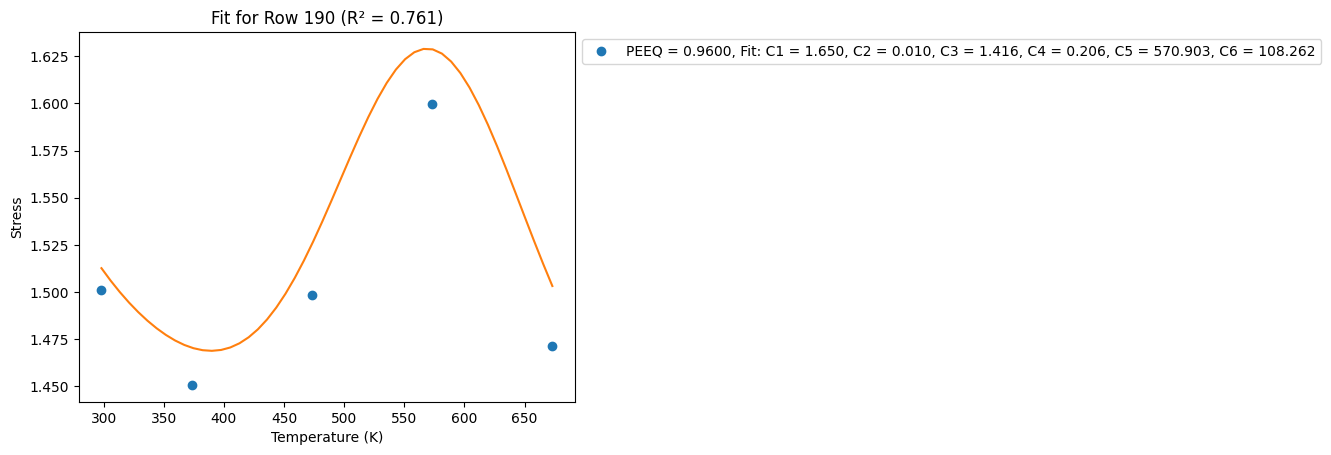

[1.50142553 1.45232366 1.4999988  1.60097292 1.47300419]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


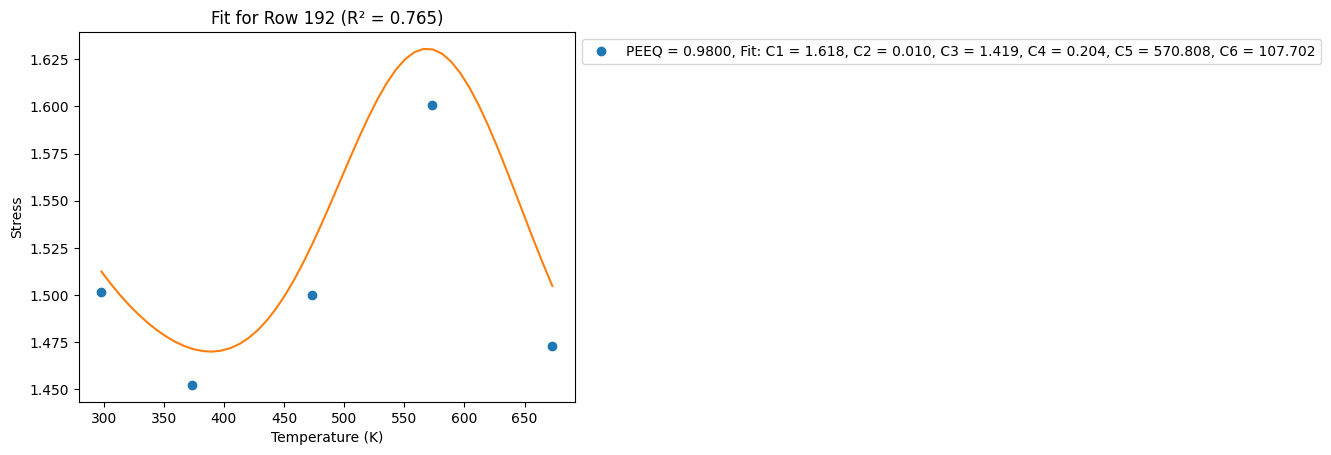

[1.50199071 1.45387044 1.50139053 1.60250544 1.47473829]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


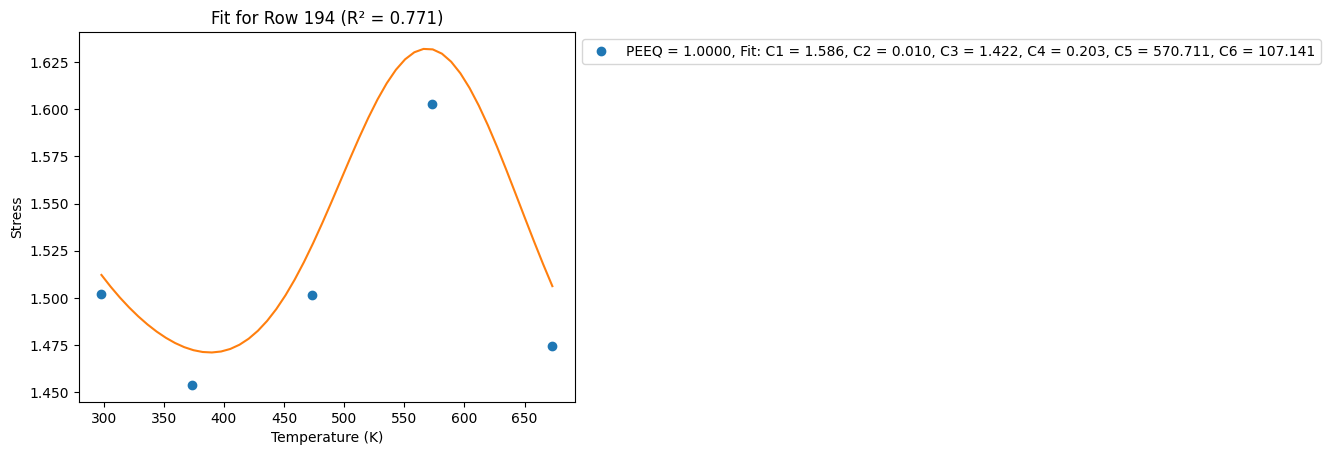

[1.50254078 1.45539208 1.50275443 1.60400522 1.47643772]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


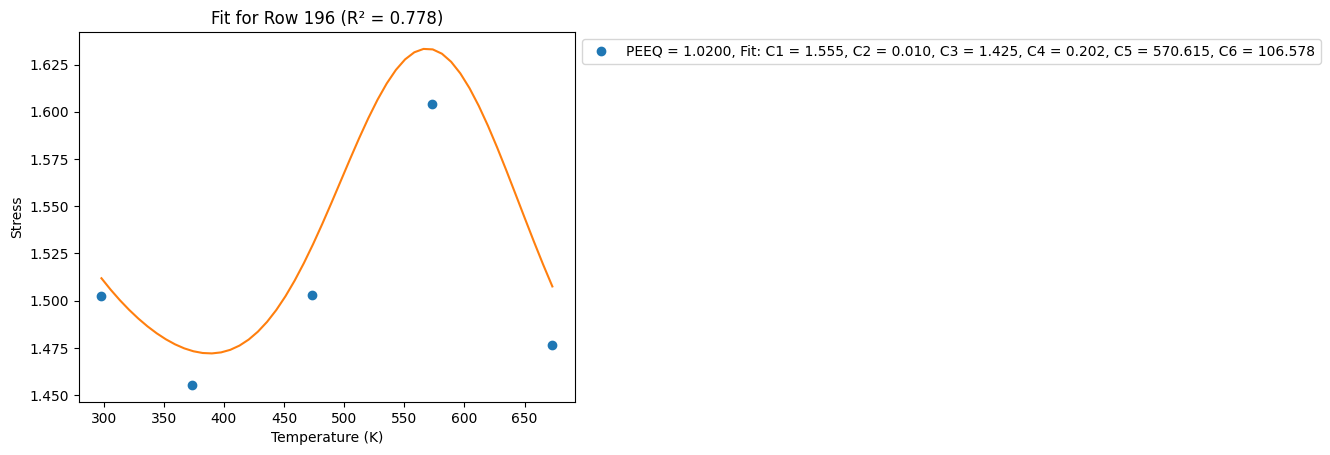

[1.50307645 1.45688948 1.50409159 1.6054736  1.47810382]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


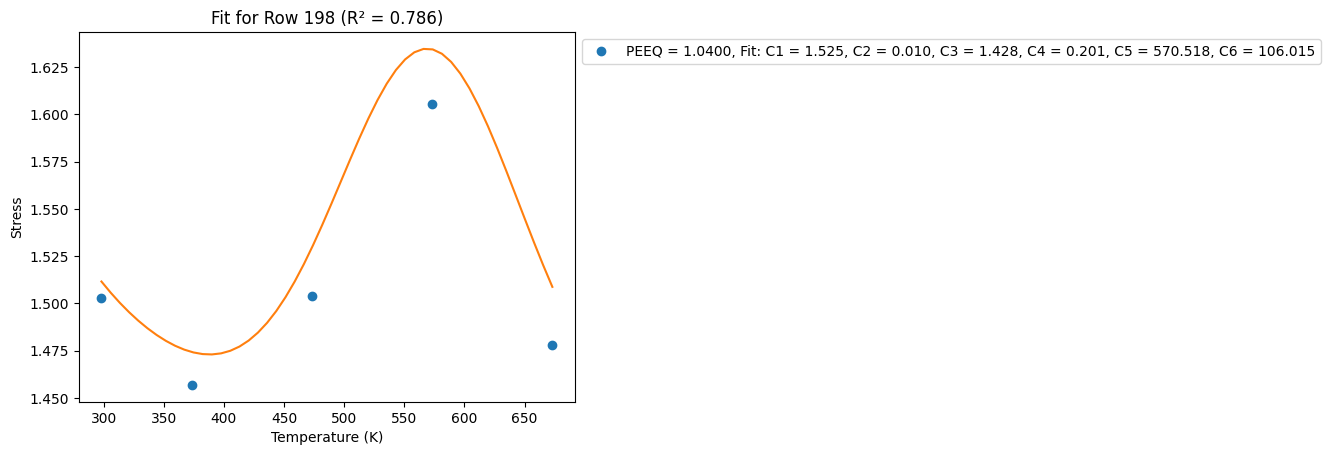

[1.50359835 1.45836348 1.50540303 1.60691183 1.47973789]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


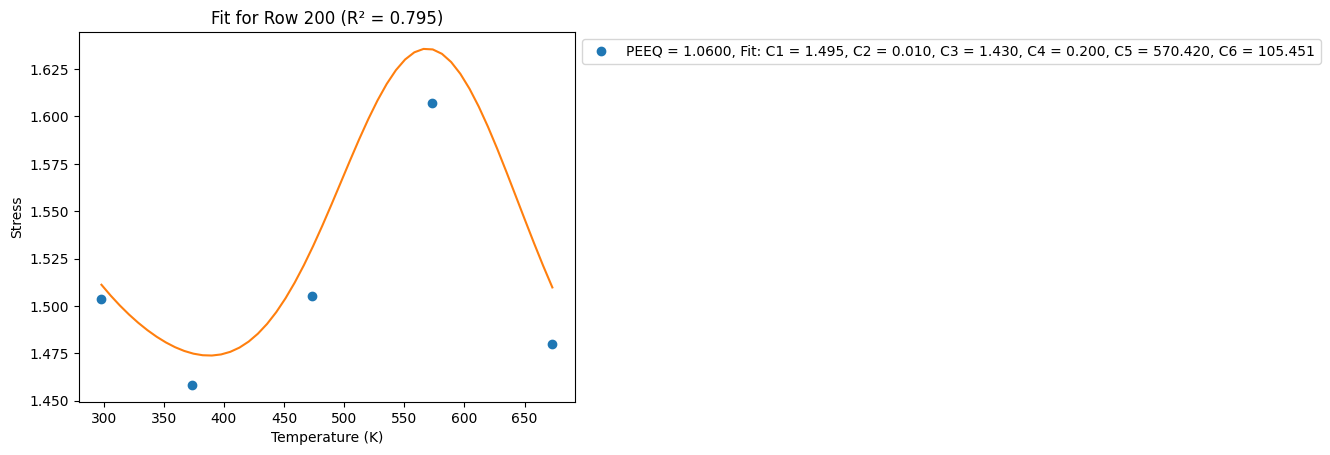

[1.50410709 1.45981489 1.50668974 1.60832108 1.48134113]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


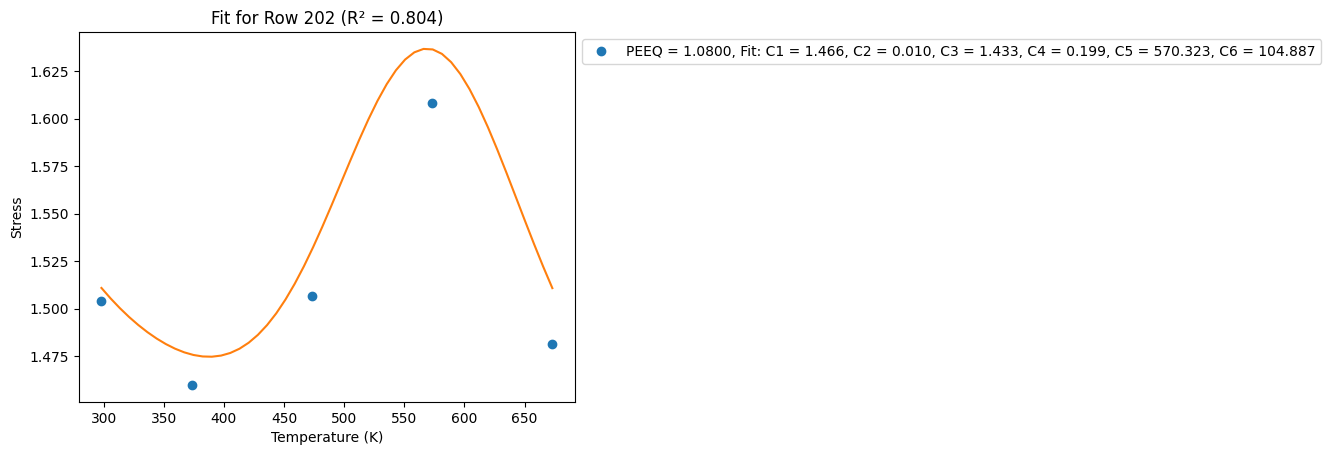

[1.50460325 1.46124447 1.50795263 1.60970246 1.48291468]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


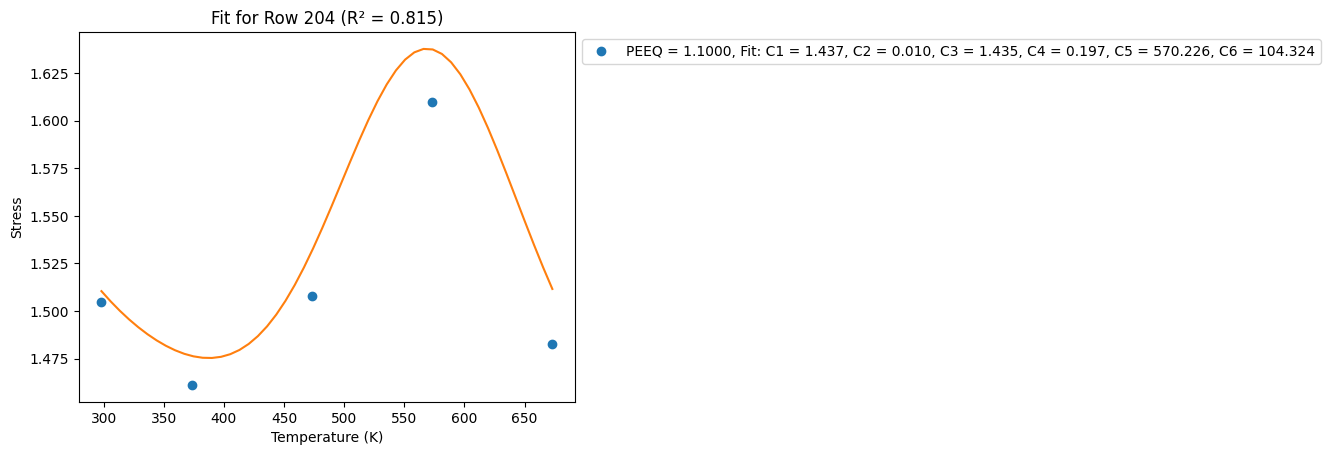

[1.50508734 1.46265293 1.50919255 1.61105703 1.48445962]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


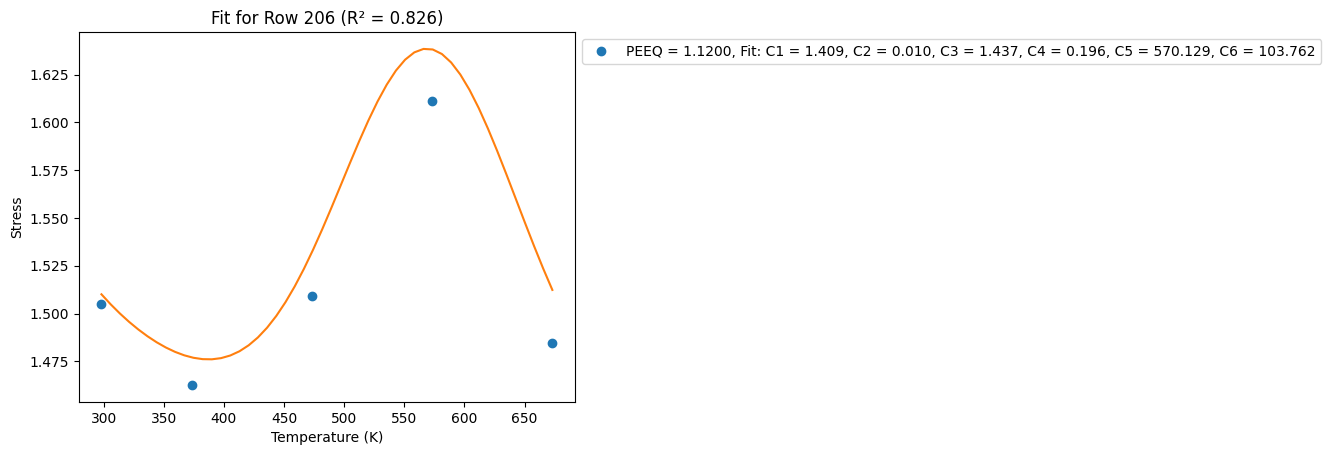

[1.50555989 1.46404095 1.51041034 1.61238576 1.48597697]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


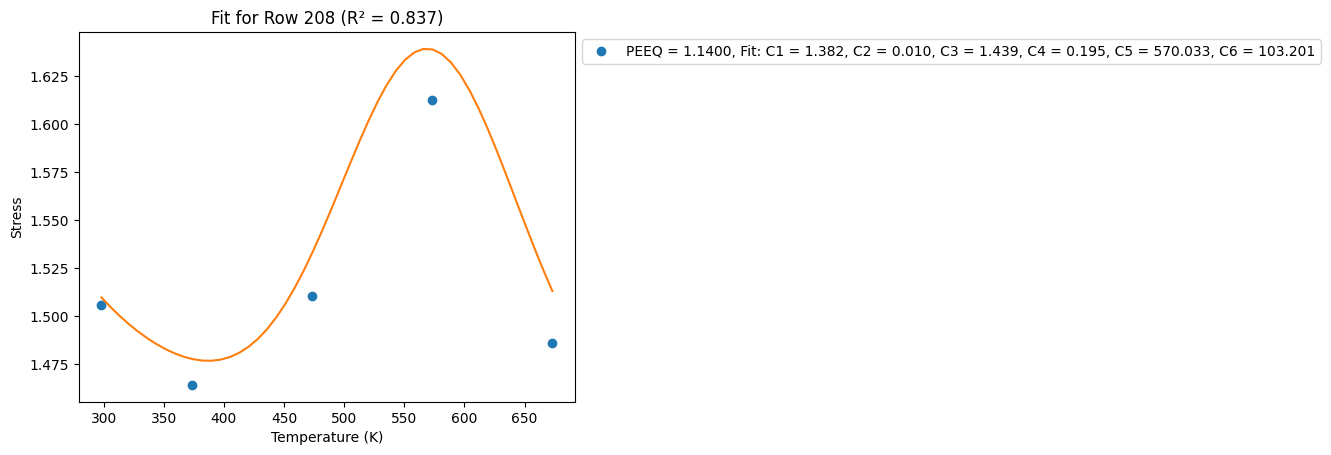

[1.50602135 1.4654092  1.51160677 1.6136896  1.48746771]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


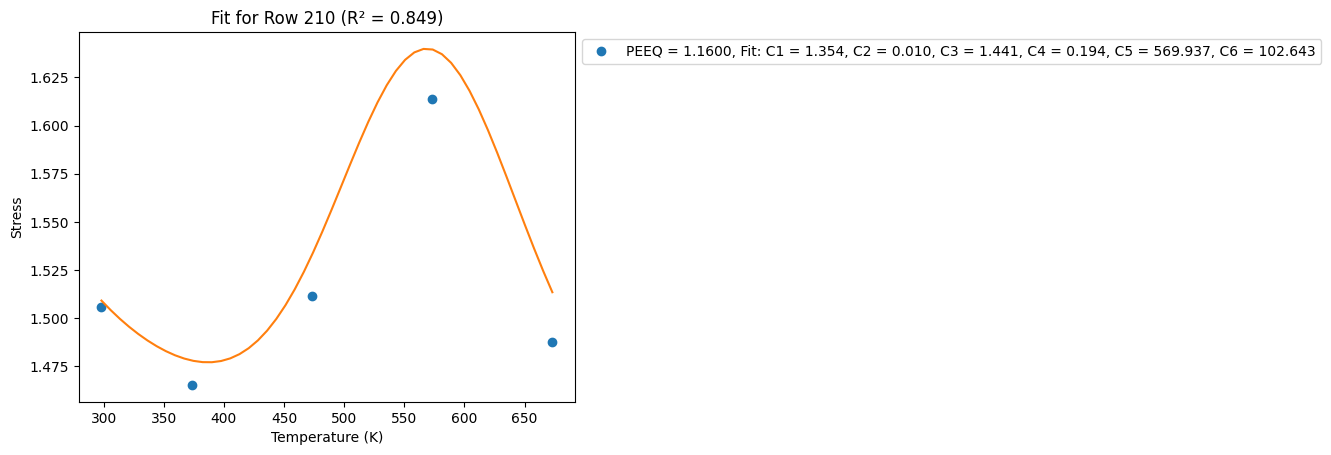

[1.50647218 1.46675828 1.51278257 1.61496943 1.48893275]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


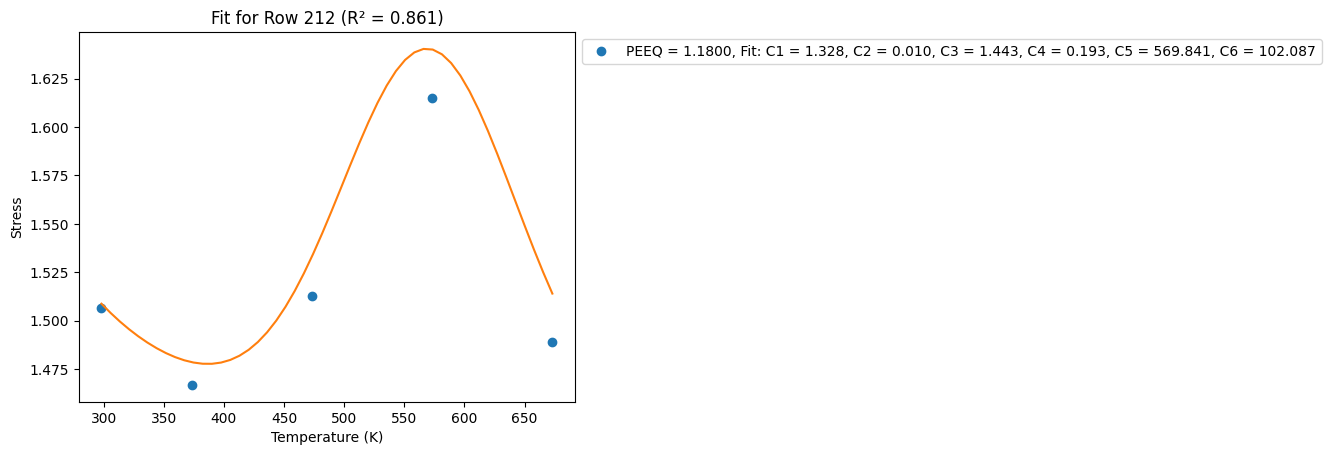

[1.50691279 1.4680888  1.51393845 1.61622609 1.49037296]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


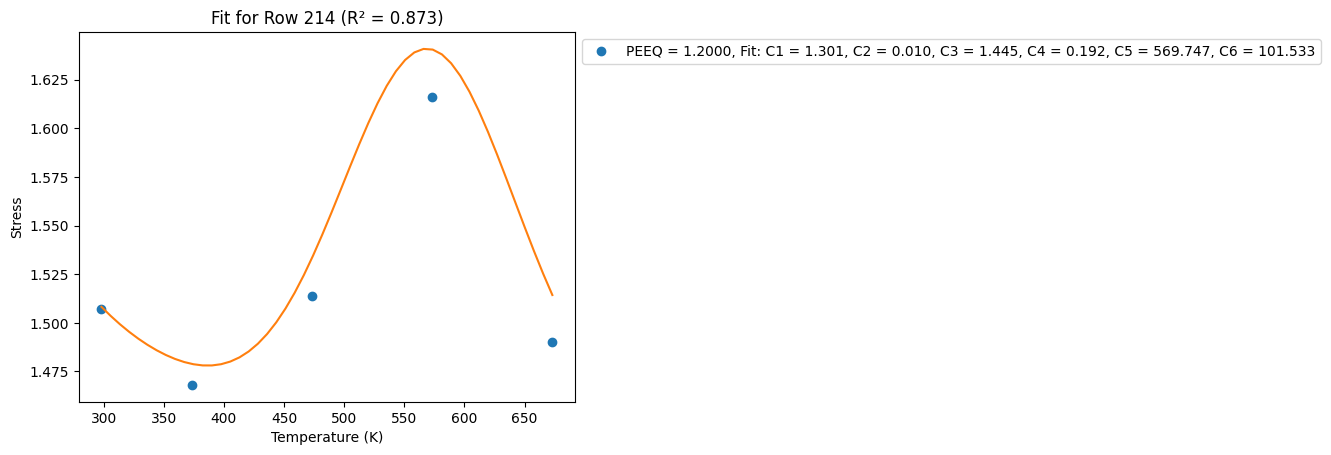

/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


[1.50734358 1.46940129 1.51507507 1.61746039 1.49178916]


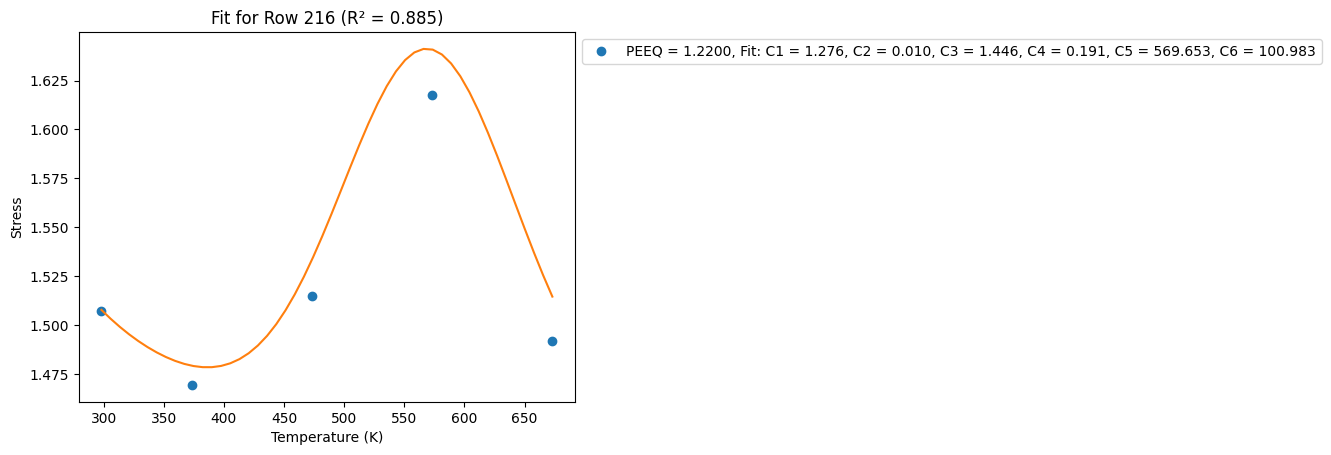

[1.50776493 1.47069632 1.51619306 1.61867308 1.49318215]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


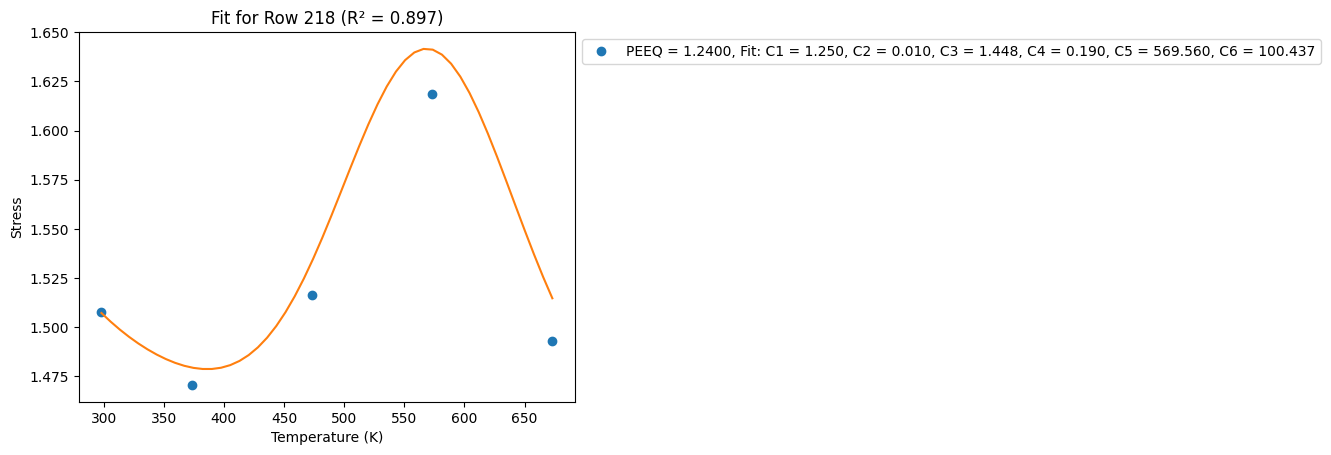

[1.50817719 1.47197438 1.51729301 1.61986488 1.49455268]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


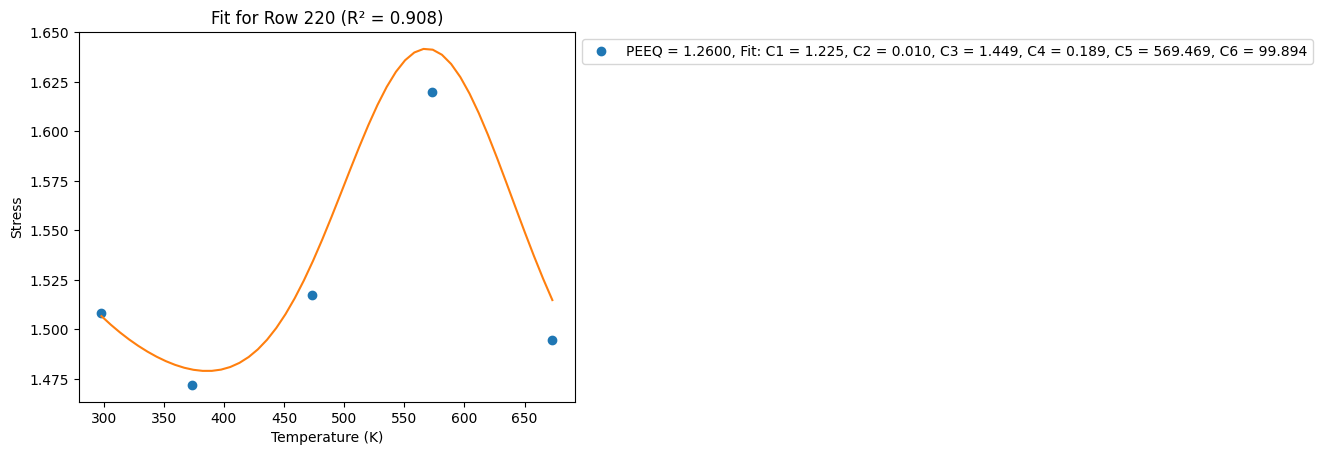

[1.50858071 1.47323596 1.51837552 1.62103648 1.49590145]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


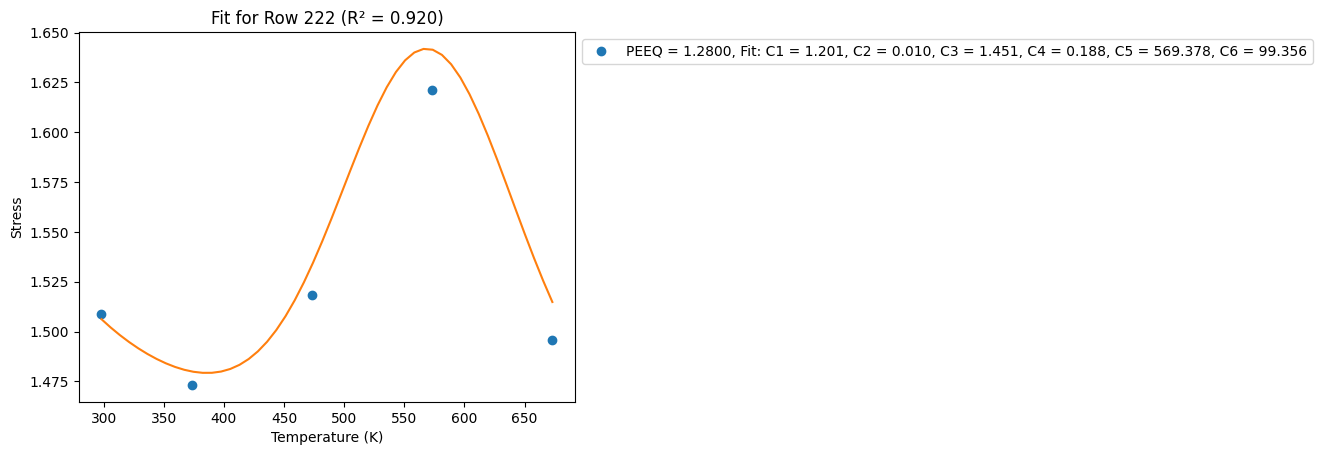

[1.50897579 1.47448153 1.51944111 1.62218853 1.49722915]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


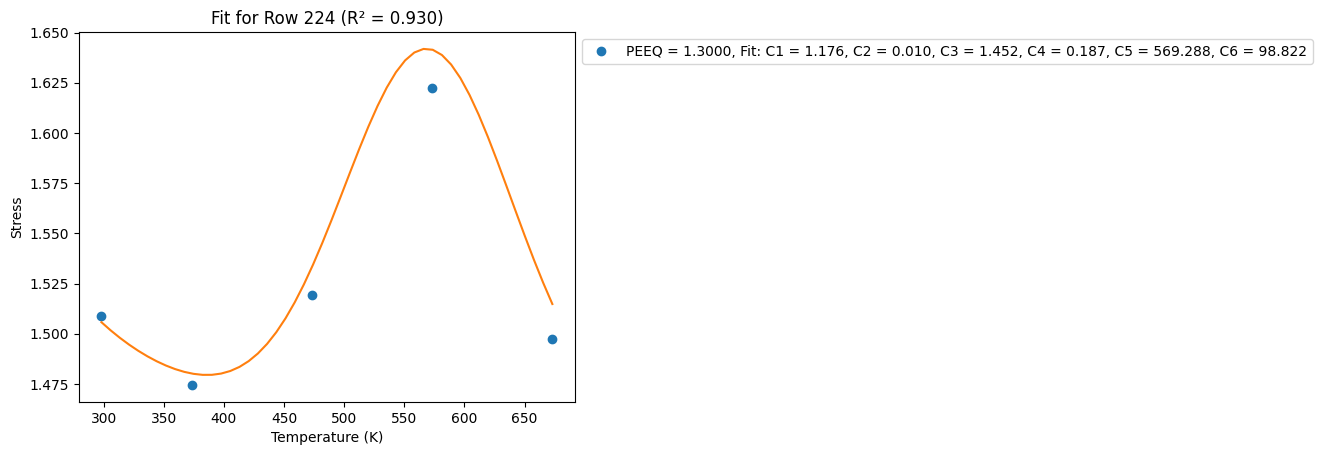

[1.50936274 1.47571154 1.52049031 1.62332164 1.49853643]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


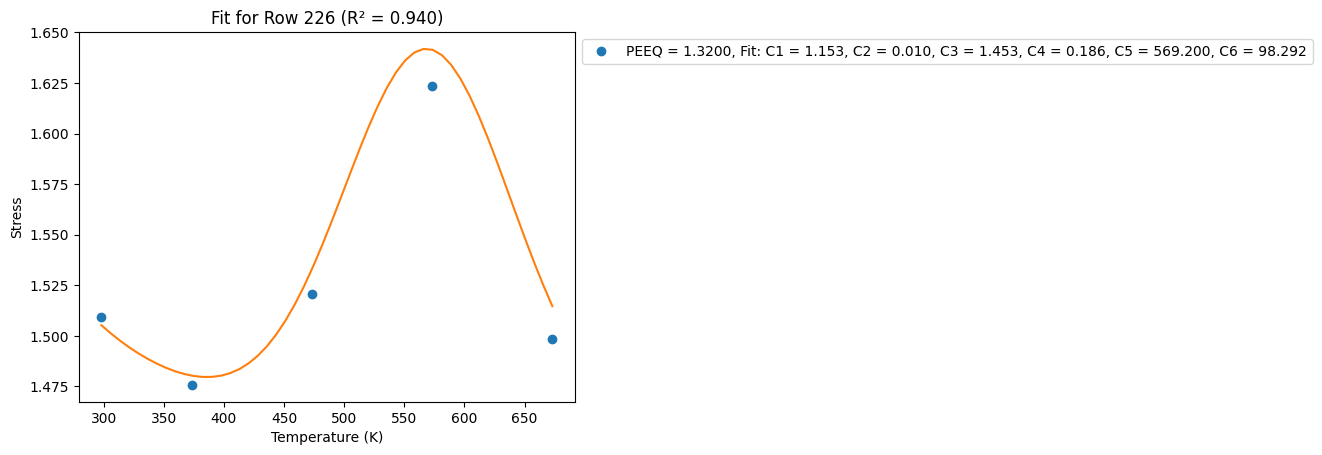

[1.50974185 1.47692641 1.52152361 1.62443642 1.4998239 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


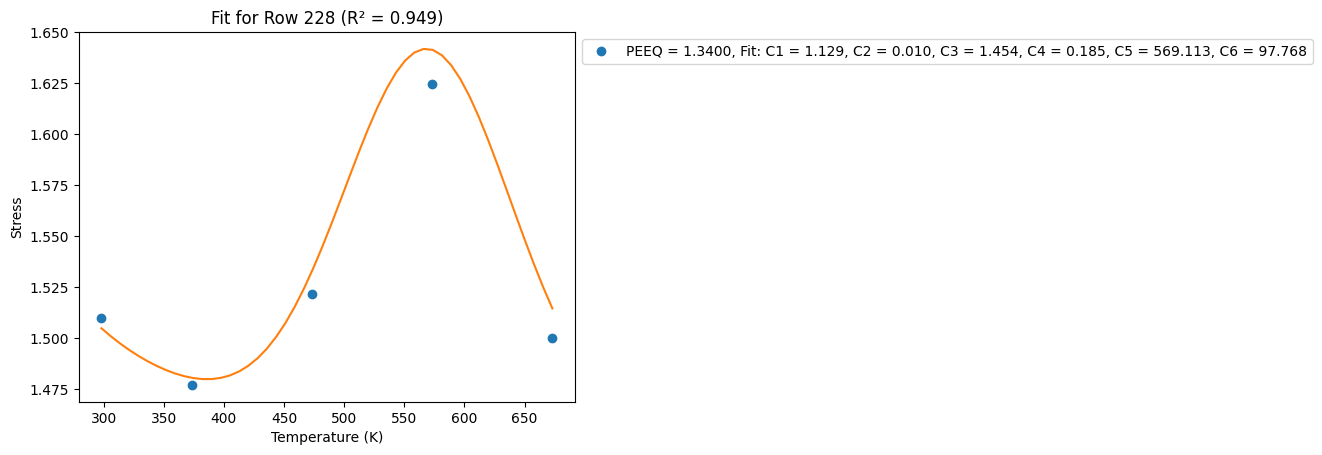

[1.51011339 1.47812656 1.5225415  1.62553344 1.50109216]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


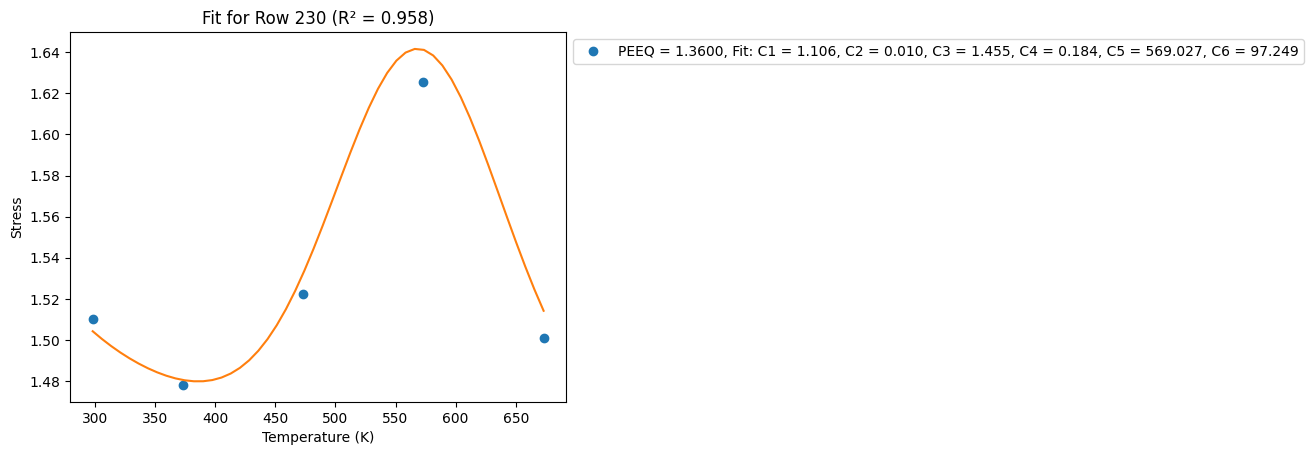

[1.51047763 1.47931238 1.52354442 1.62661322 1.50234176]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


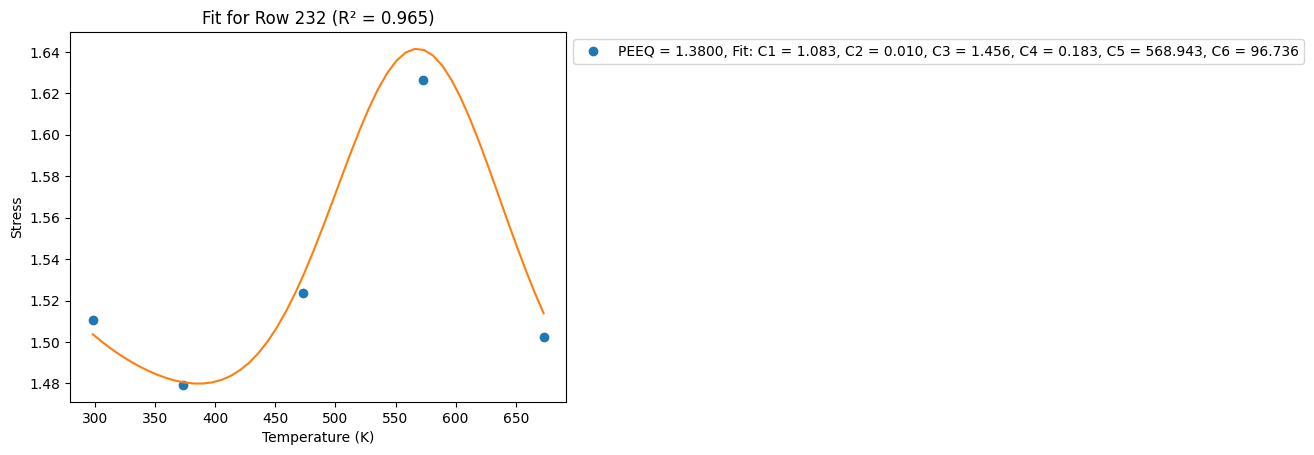

[1.5108348  1.48048424 1.52453281 1.62767629 1.50357326]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


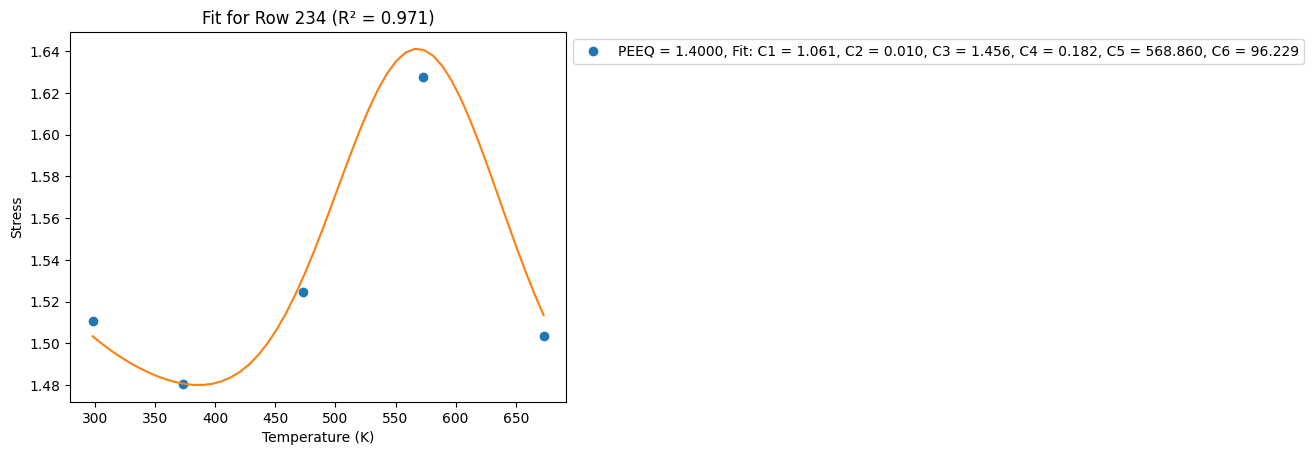

[1.51118515 1.4816425  1.52550708 1.62872314 1.50478717]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


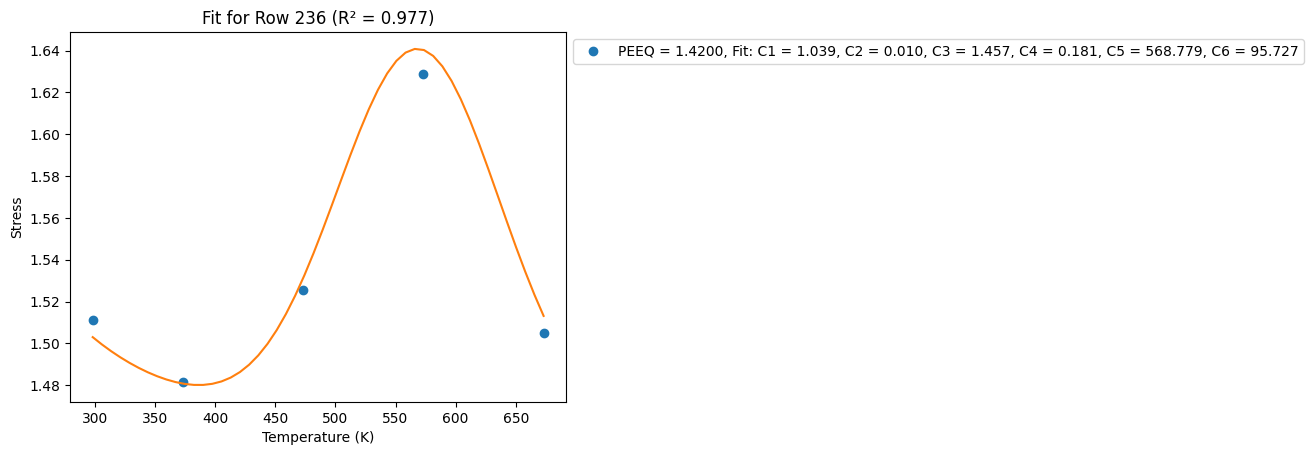

[1.51152889 1.48278752 1.52646763 1.62975424 1.50598398]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


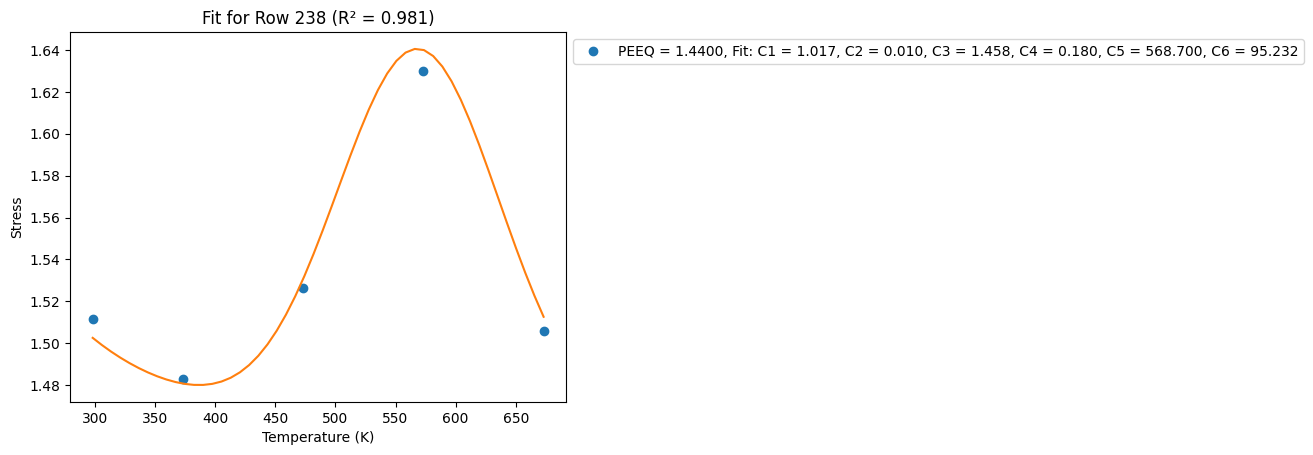

[1.51186625 1.48391963 1.52741484 1.63077004 1.50716417]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


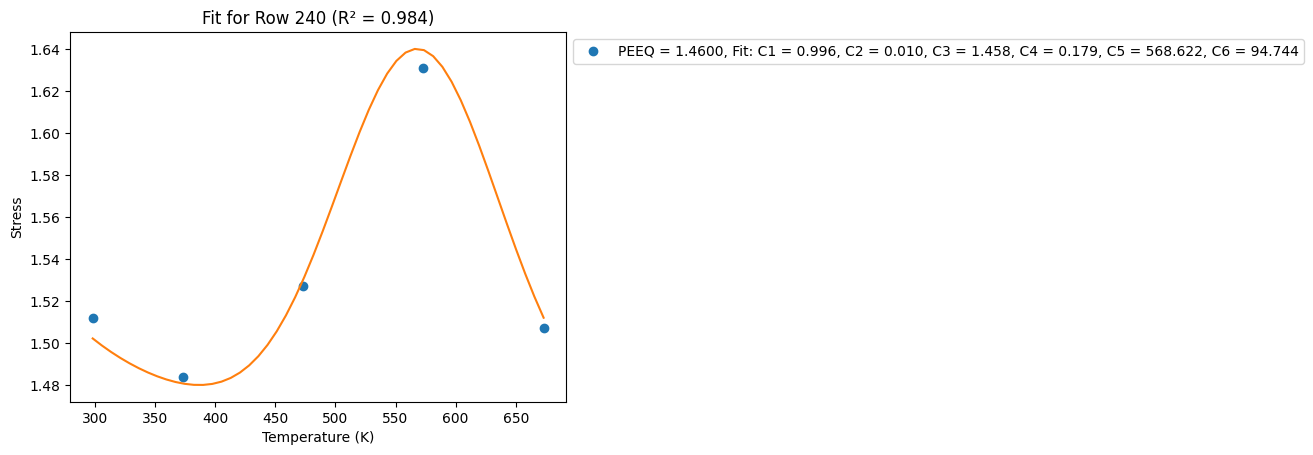

[1.51219742 1.48503914 1.52834908 1.63177099 1.5083282 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


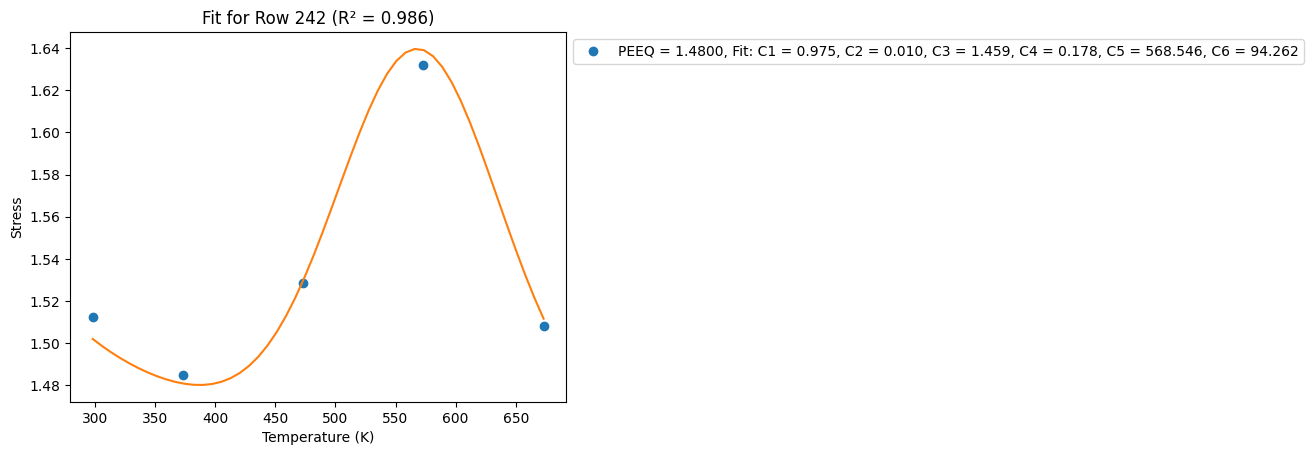

[1.51252261 1.48614637 1.5292707  1.63275748 1.50947649]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


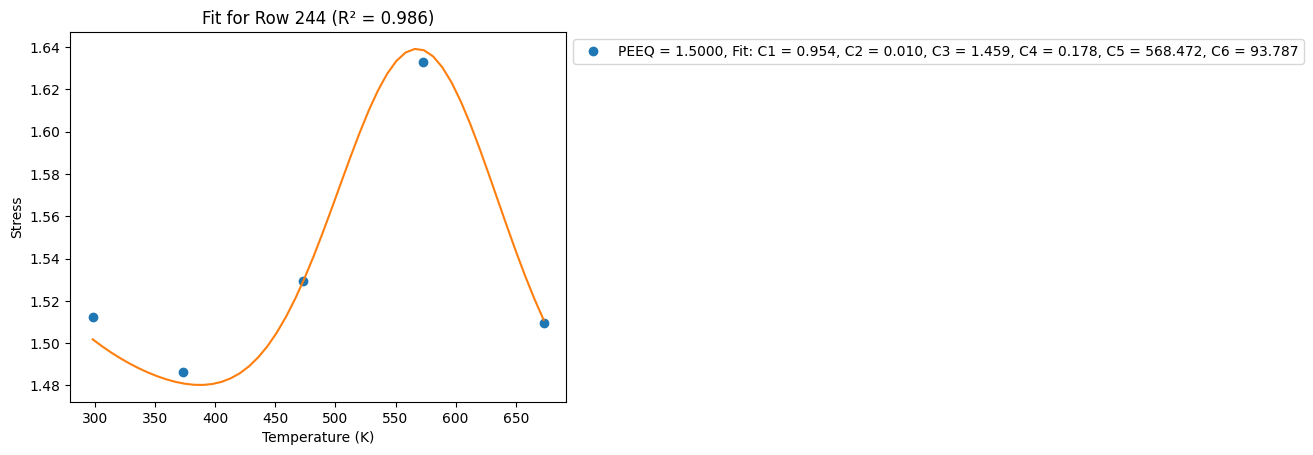

[1.512842   1.48724161 1.53018003 1.63372993 1.51060948]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


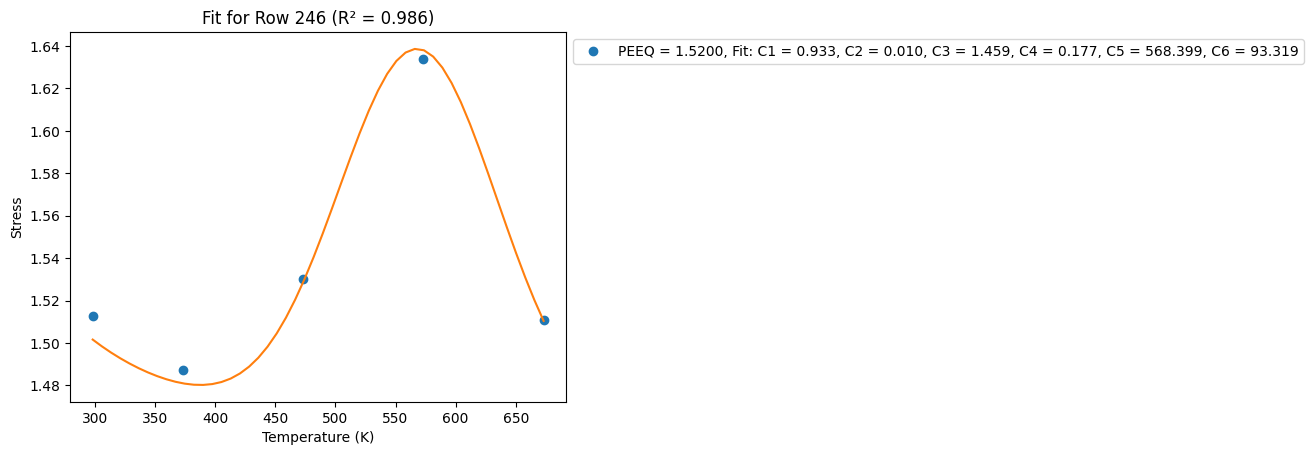

[1.51315576 1.48832515 1.53107739 1.63468871 1.51172756]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


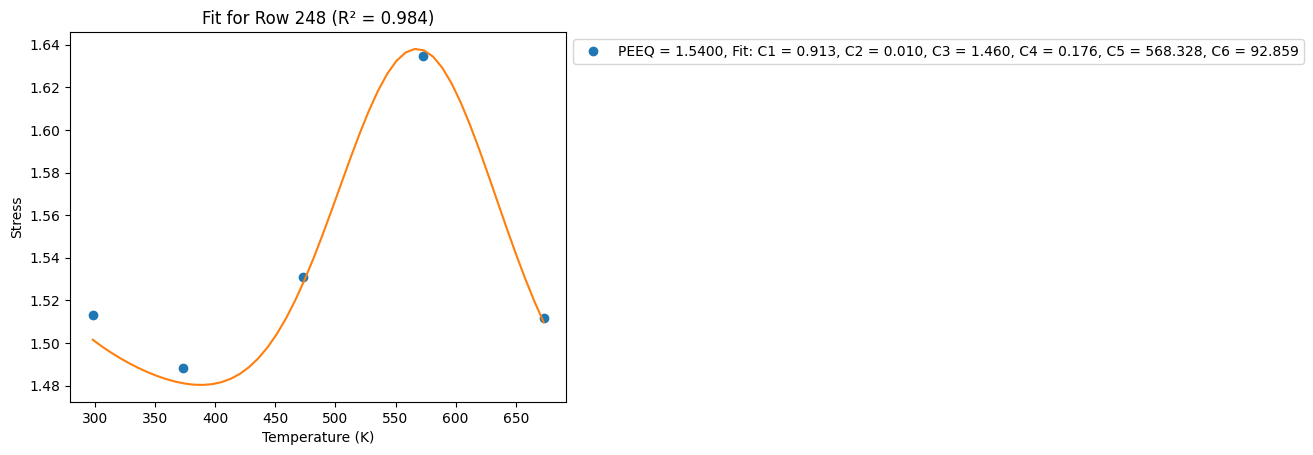

[1.51346406 1.48939726 1.53196311 1.6356342  1.51283112]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


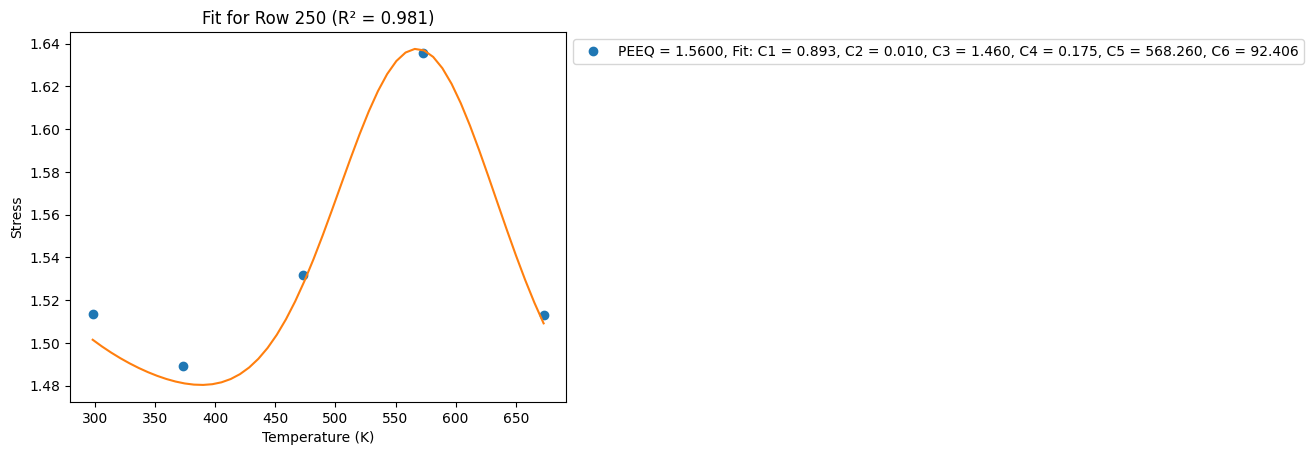

[1.51376708 1.49045821 1.53283747 1.63656673 1.51392054]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


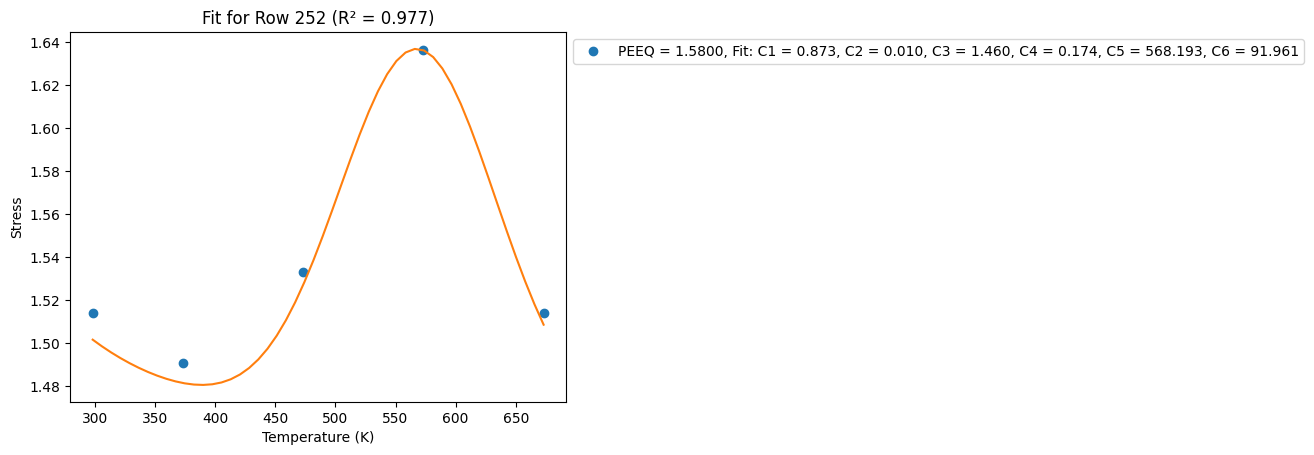

[1.51406497 1.49150826 1.53370077 1.63748666 1.51499617]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


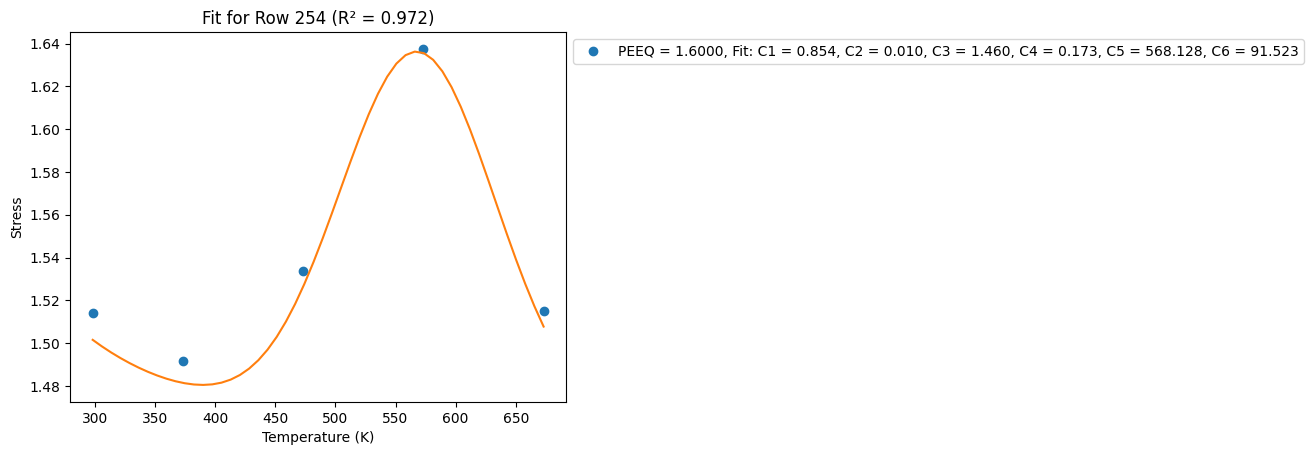

[1.51435787 1.49254766 1.53455328 1.6383943  1.51605835]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


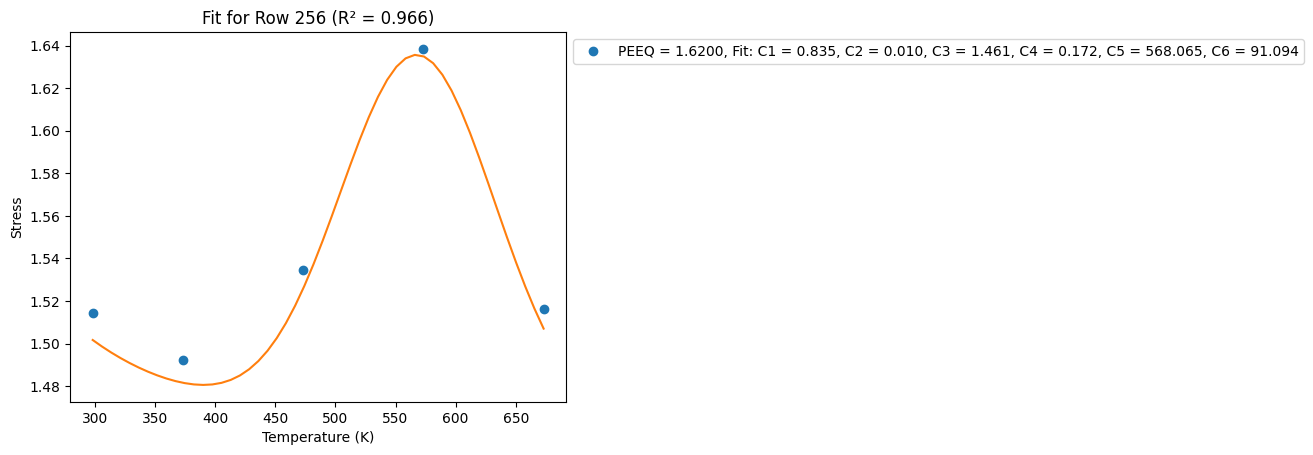

[1.51464593 1.49357663 1.53539526 1.63928998 1.51710742]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


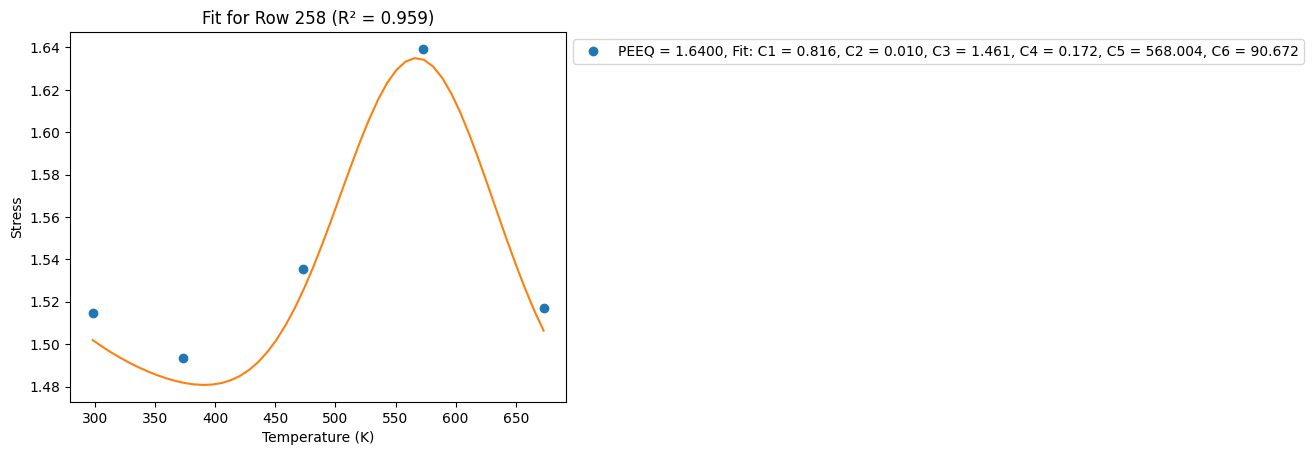

[1.51492929 1.49459542 1.53622698 1.64017399 1.5181437 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


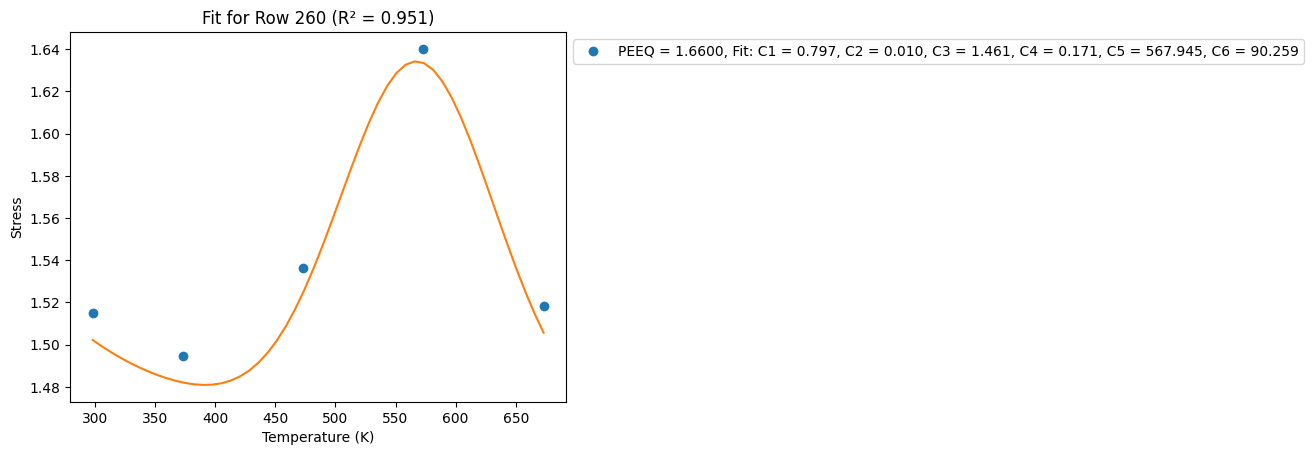

[1.51520808 1.49560424 1.53704868 1.64104662 1.51916749]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


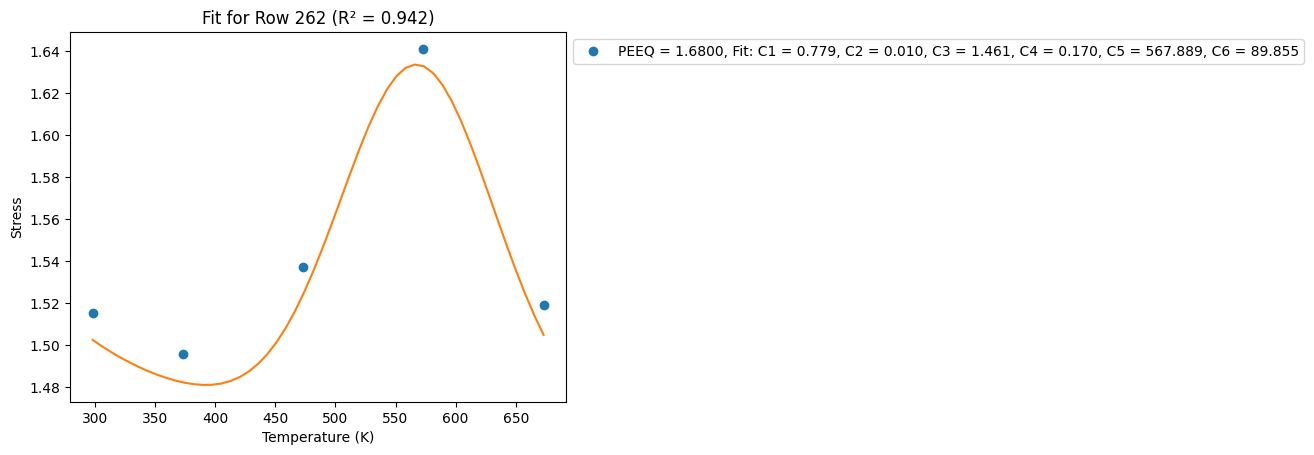

[1.51548243 1.49660331 1.5378606  1.64190816 1.5201791 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


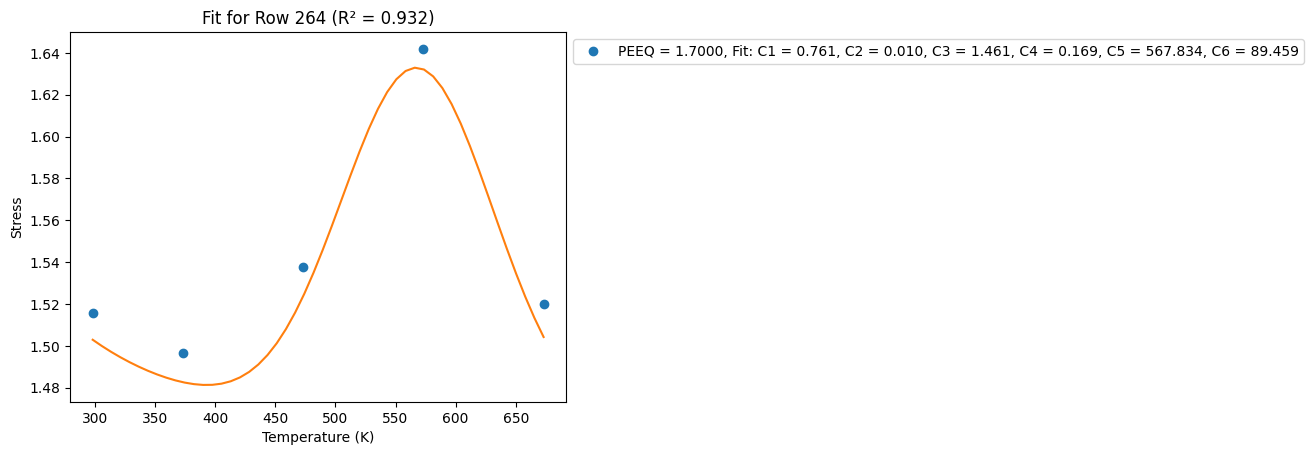

[1.51575246 1.49759284 1.53866297 1.64275887 1.5211788 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


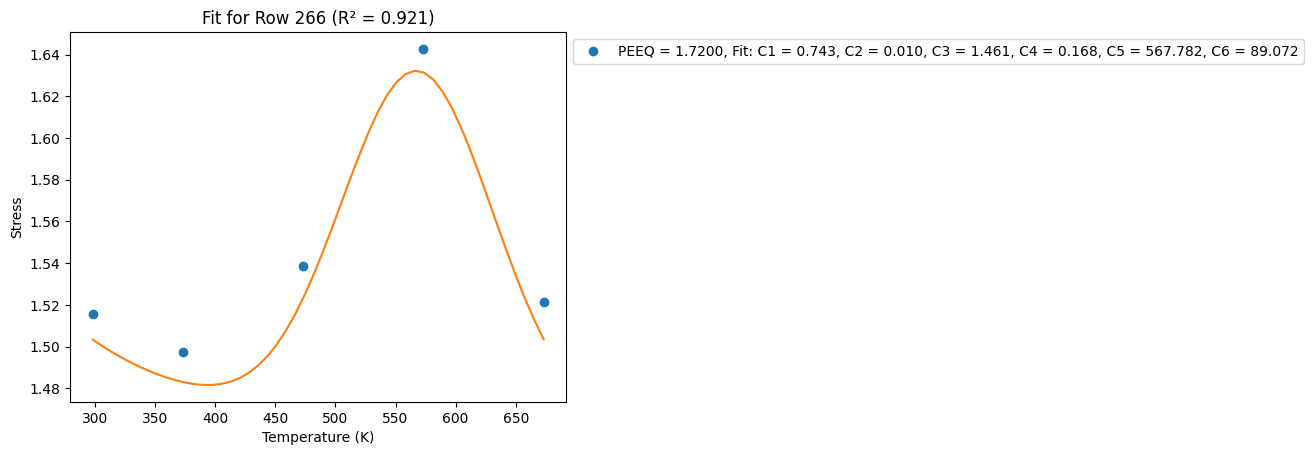

[1.51601828 1.49857303 1.53945601 1.64359901 1.52216689]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


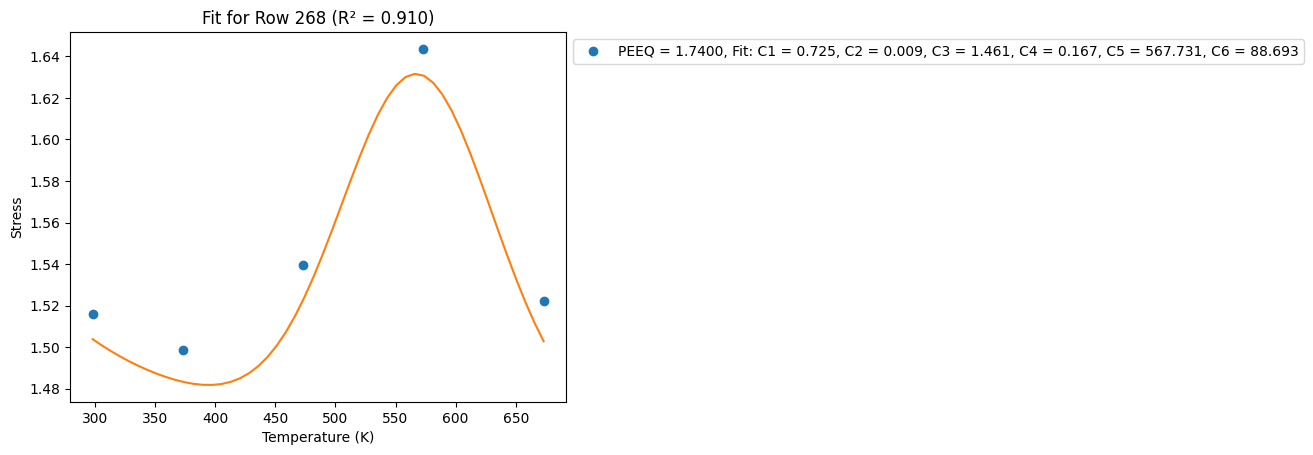

[1.51628002 1.49954407 1.54023994 1.64442884 1.52314362]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


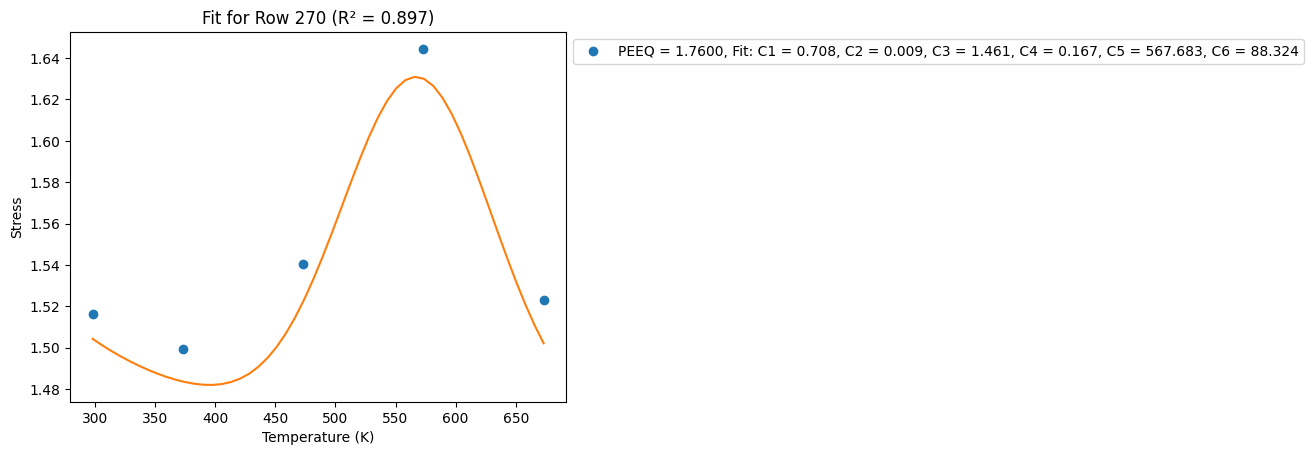

[1.51653777 1.50050615 1.54101496 1.6452486  1.52410924]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


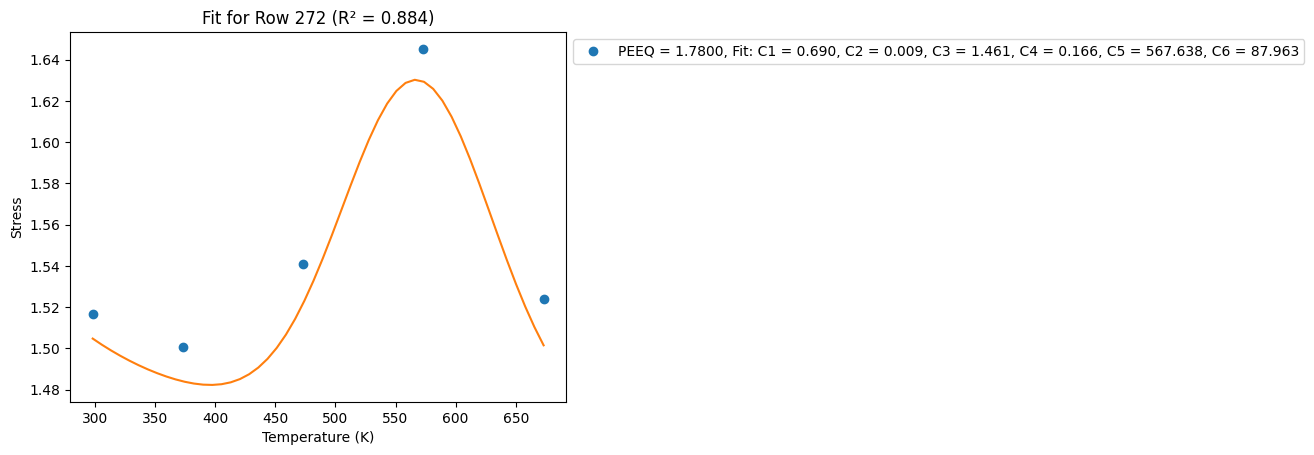

[1.51679164 1.50145946 1.54178128 1.64605851 1.52506403]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


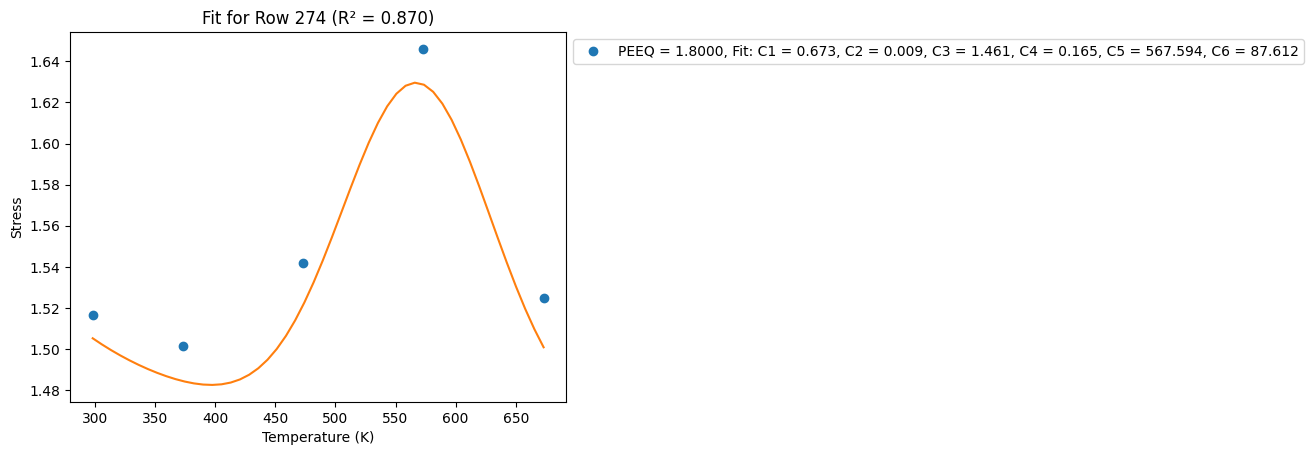

[1.51704174 1.50240417 1.54253908 1.64685882 1.5260082 ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


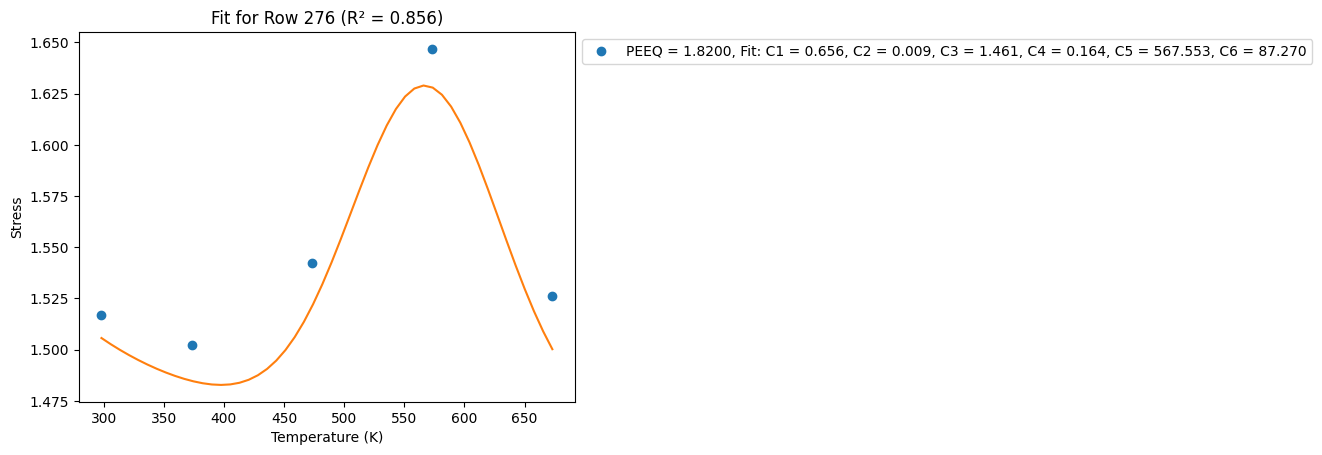

[1.51728816 1.50334045 1.54328855 1.64764973 1.526942  ]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


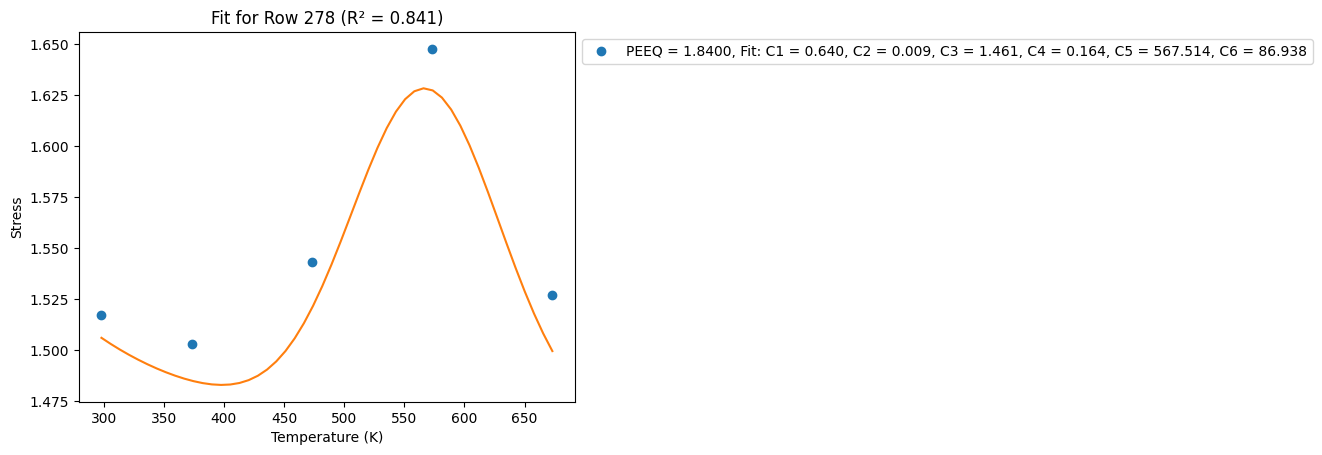

[1.51753099 1.50426847 1.54402988 1.64843146 1.52786565]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


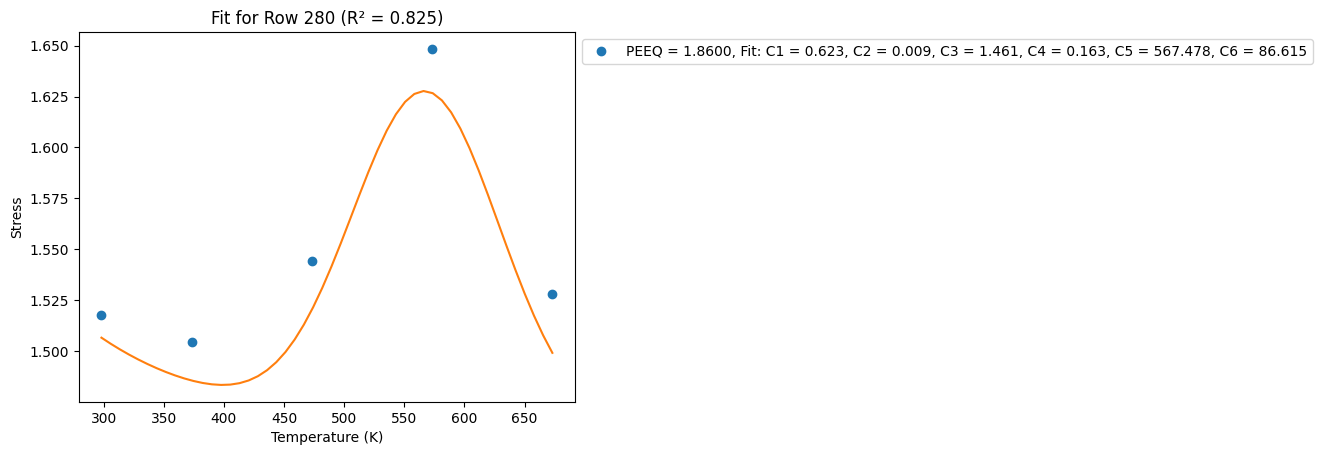

[1.51777033 1.50518839 1.54476325 1.64920421 1.52877937]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


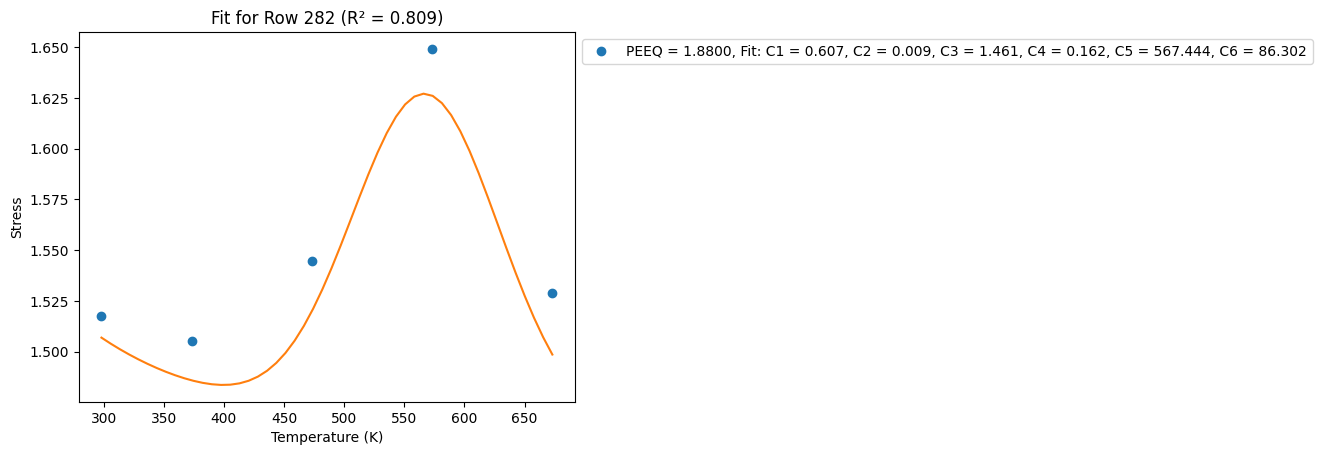

[1.51800625 1.50610036 1.54548881 1.64996818 1.52968337]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


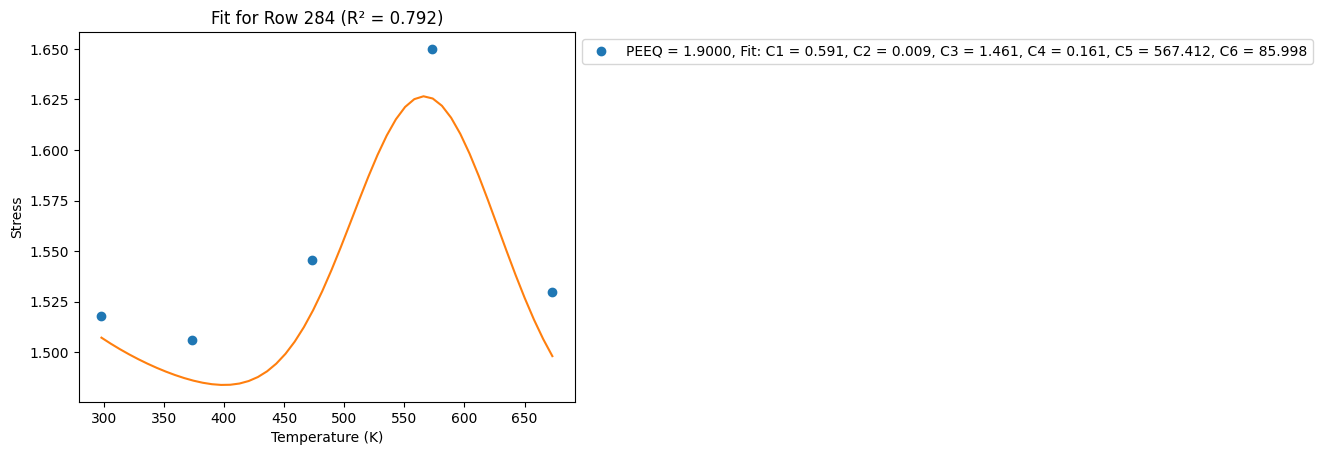

[1.51823885 1.50700455 1.54620673 1.65072355 1.53057785]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


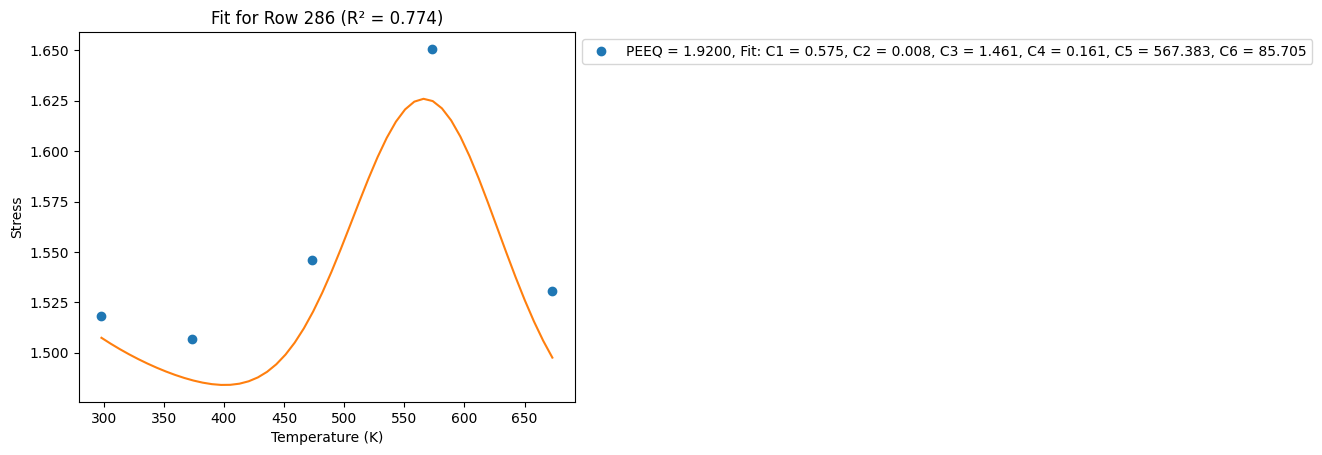

[1.51846821 1.50790108 1.54691718 1.65147053 1.53146302]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


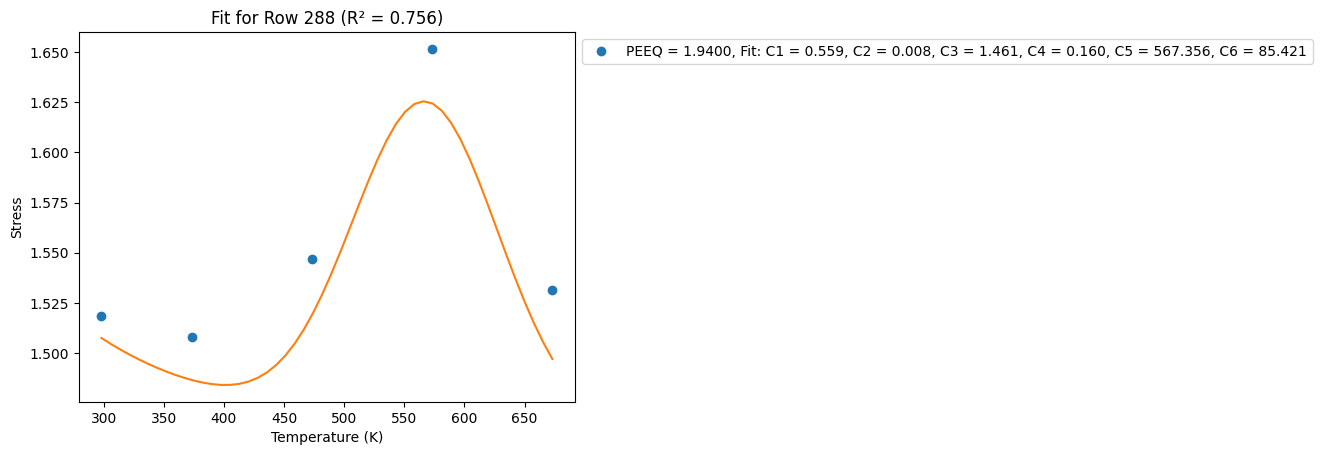

[1.5186944  1.50879012 1.5476203  1.65220927 1.53233906]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


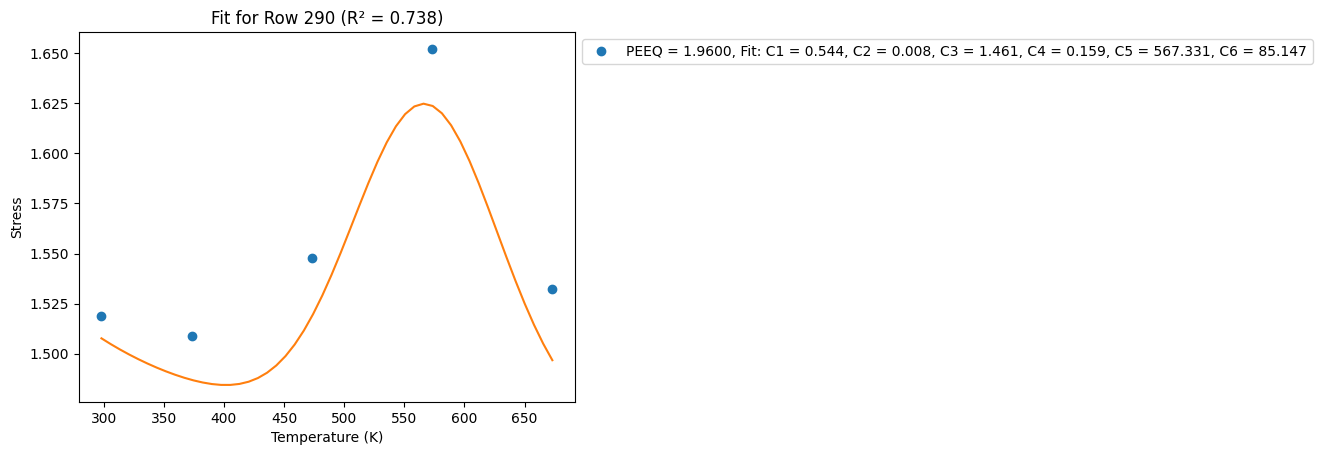

[1.5189175  1.50967179 1.54831626 1.65293997 1.53320617]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


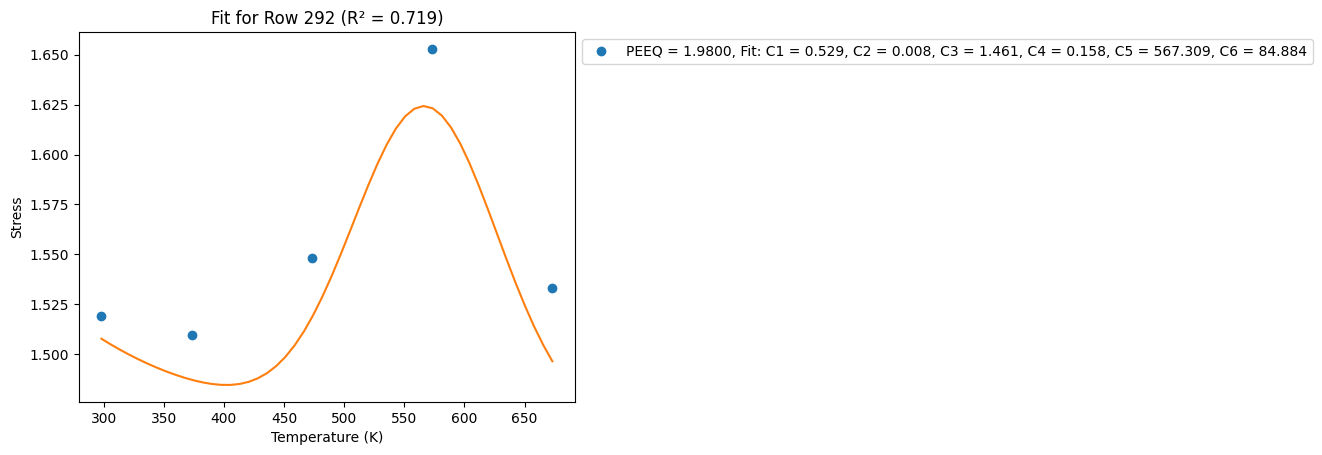

[1.51913758 1.51054623 1.54900518 1.65366278 1.53406451]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


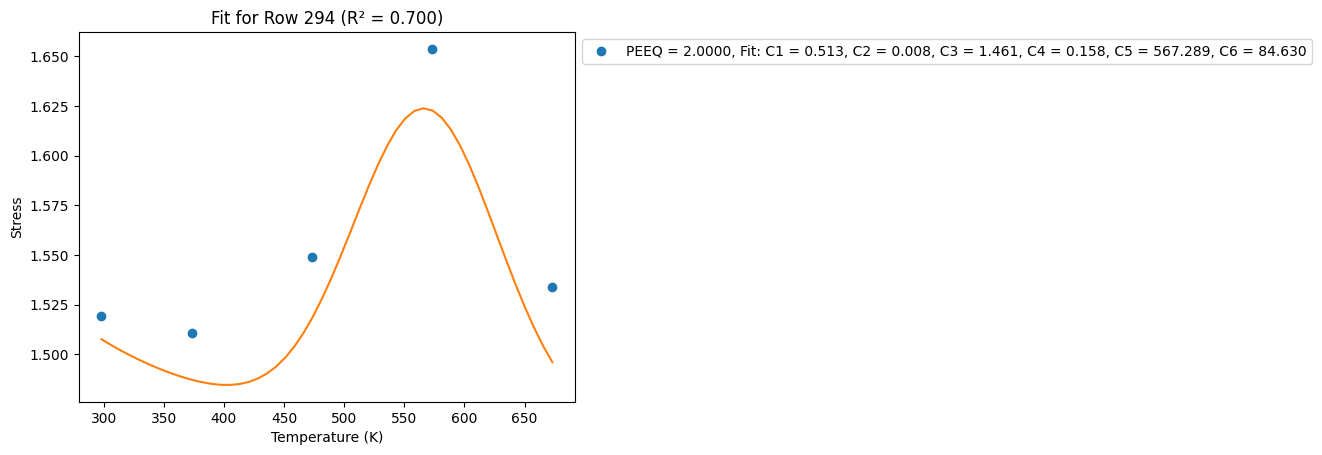

[1.51935472 1.51141358 1.54968721 1.65437787 1.53491428]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


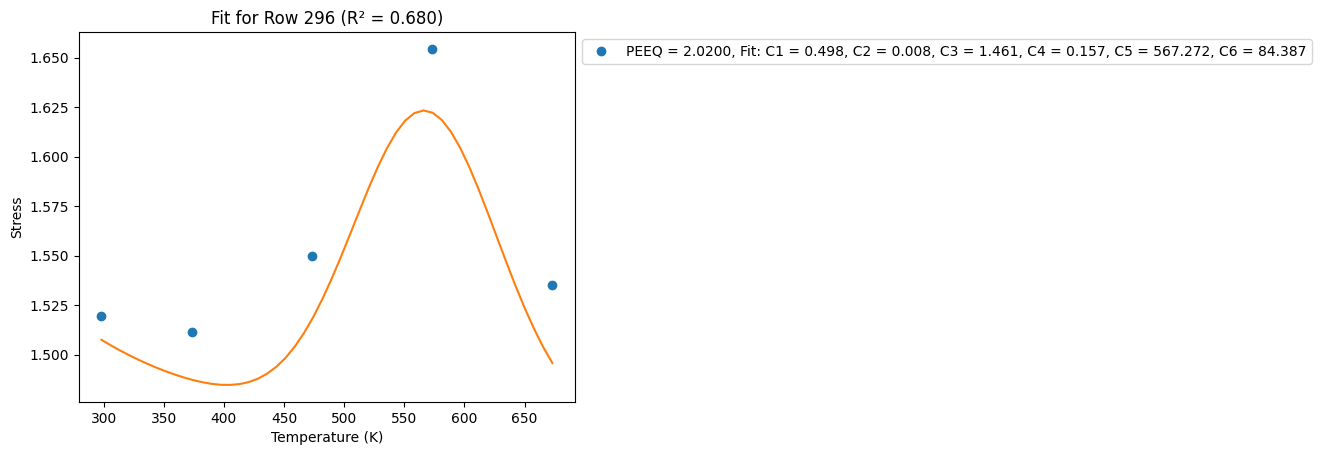

[1.51956897 1.51227395 1.5503625  1.65508539 1.53575563]


/tmp/ipykernel_2910/1517986124.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))


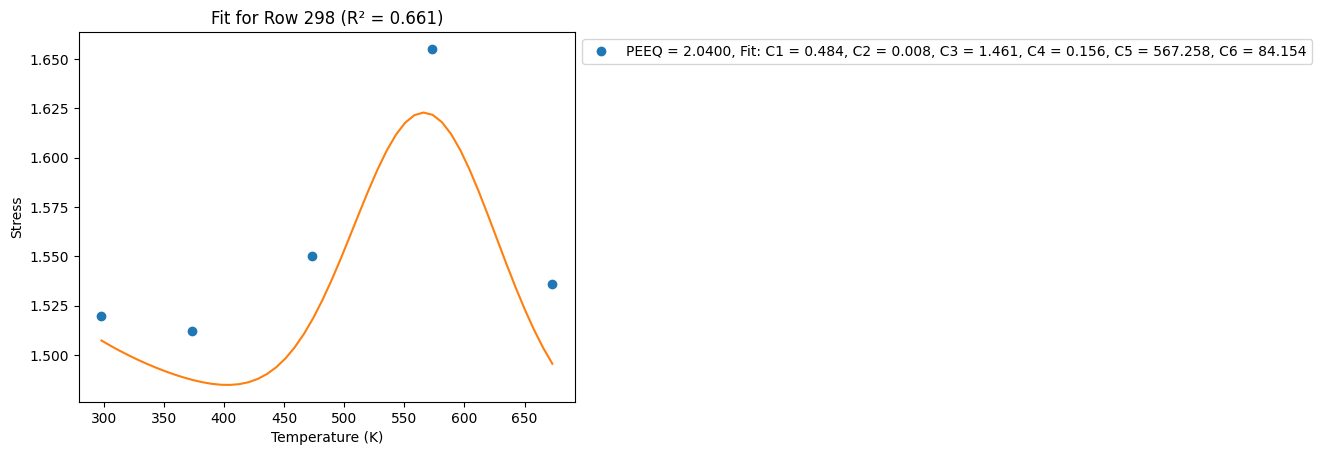

In [ ]:
# Temperarute data points
T = np.array([298.15, 373.15, 473.15, 573.15, 673.15])

# Temperature function
def f_func(T, cT1, cT2, cT3, cT4, cT5, cT6):
    return cT1*(np.exp(-cT2*T))+cT3+cT4*(np.exp(-((T-cT5)/cT6)**2))

for j, i in enumerate(np.arange(0,300,2)):
    T_fit = np.linspace(np.min(T), np.max(T), 50)
    [C1, C2, C3, C4, C5, C6] = fitted_para.iloc[i, 1:]
    y = stress_data.iloc[i, 6:].values
    print(y)
    gaussian_fit = f_func(T_fit, C1, C2, C3, C4, C5, C6)
    y_pred = f_func(T,C1,C2,C3,C4,C5,C6)   
    r_squared = r2_score(y, y_pred)
    plt.plot(T, y, 'o', T_fit, gaussian_fit)
    plt.xlabel("Temperature (K)")
    plt.ylabel("Stress")
    plt.title(f"Fit for Row {i} (R² = {r_squared:.3f})")
    plt.legend([f'PEEQ = {fitted_para.iloc[i][0]:.4f}, Fit: C1 = {C1:.3f}, C2 = {C2:.3f}, C3 = {C3:.3f}, C4 = {C4:.3f}, C5 = {C5:.3f}, C6 = {C6:.3f}'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
else:
    str(0)